In [1]:
%matplotlib inline

# Gaussian process models for stellar variability

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.1


When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

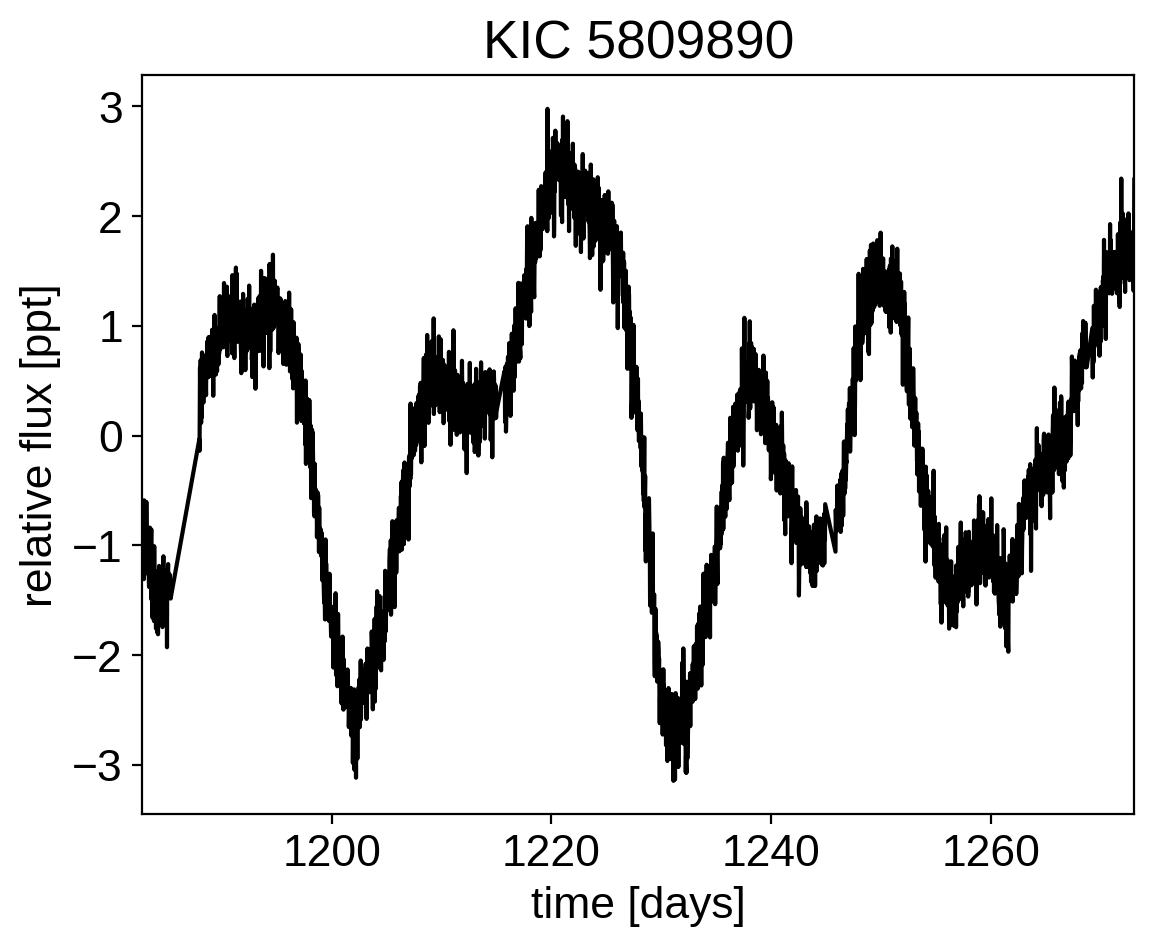

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

url = "https://archive.stsci.edu/missions/kepler/lightcurves/0058/005809890/kplr005809890-2012179063303_llc.fits"
with fits.open(url) as hdus:
    data = hdus[1].data
    hdr = hdus[1].header
    
# Work out the exposure time
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0    

x = data["TIME"]
y = data["PDCSAP_FLUX"]
yerr = data["PDCSAP_FLUX_ERR"]
m = (data["SAP_QUALITY"] == 0) & np.isfinite(x) & np.isfinite(y)

x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m], dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

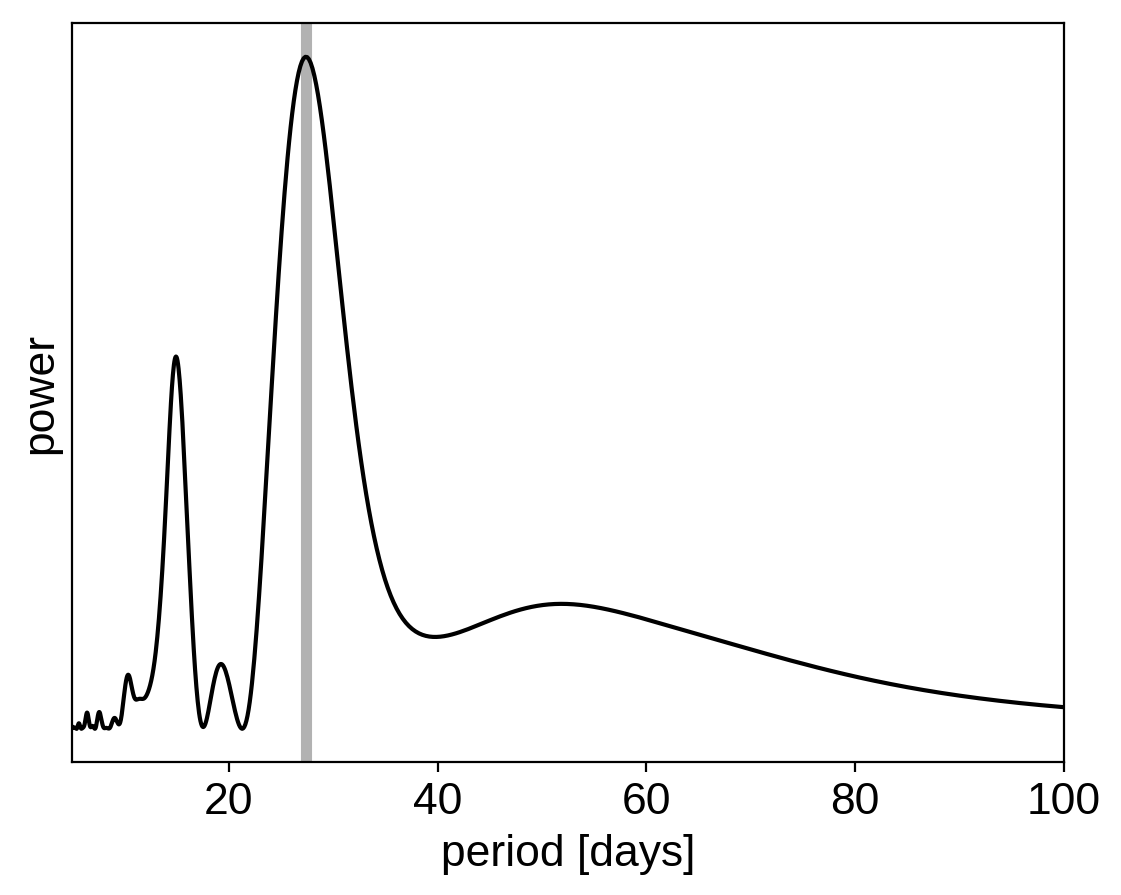

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1/freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1/freq).min(), (1/freq).max())
plt.yticks([])
plt.xlabel("period [days]")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    
    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)
    
    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)
    
    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))
    
    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)
    
    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.631022e+02]

1it [00:00, 77.68it/s, logp=2.631022e+02]

2it [00:00, 116.04it/s, logp=2.631022e+02]

3it [00:00, 135.60it/s, logp=6.002739e+02]

4it [00:00, 149.24it/s, logp=-6.359152e+03]

5it [00:00, 160.48it/s, logp=6.096027e+02] 

6it [00:00, 159.39it/s, logp=6.144153e+02]

7it [00:00, 165.55it/s, logp=6.229963e+02]

8it [00:00, 171.36it/s, logp=6.384733e+02]

9it [00:00, 175.55it/s, logp=6.617642e+02]

10it [00:00, 178.52it/s, logp=6.549842e+02]

11it [00:00, 182.25it/s, logp=6.725488e+02]

12it [00:00, 184.95it/s, logp=6.824959e+02]

13it [00:00, 187.18it/s, logp=6.848040e+02]

14it [00:00, 188.66it/s, logp=6.856831e+02]

15it [00:00, 189.45it/s, logp=6.861401e+02]

16it [00:00, 190.40it/s, logp=6.867518e+02]

17it [00:00, 191.79it/s, logp=6.871650e+02]

18it [00:00, 193.21it/s, logp=6.872785e+02]

19it [00:00, 195.10it/s, logp=6.873790e+02]

20it [00:00, 196.67it/s, logp=6.875105e+02]

21it [00:00, 204.89it/s, logp=6.875105e+02]

21it [00:00, 204.89it/s, logp=6.876236e+02]

22it [00:00, 204.89it/s, logp=6.877974e+02]

23it [00:00, 204.89it/s, logp=6.886909e+02]

24it [00:00, 204.89it/s, logp=6.294322e+02]

25it [00:00, 204.89it/s, logp=6.896081e+02]

26it [00:00, 204.89it/s, logp=6.898125e+02]

27it [00:00, 204.89it/s, logp=6.901252e+02]

28it [00:00, 204.89it/s, logp=6.887494e+02]

29it [00:00, 204.89it/s, logp=6.901908e+02]

30it [00:00, 204.89it/s, logp=6.903124e+02]

31it [00:00, 204.89it/s, logp=6.905094e+02]

32it [00:00, 204.89it/s, logp=6.906341e+02]

33it [00:00, 204.89it/s, logp=6.906554e+02]

34it [00:00, 204.89it/s, logp=6.906909e+02]

35it [00:00, 204.89it/s, logp=6.907126e+02]

36it [00:00, 204.89it/s, logp=6.907143e+02]

37it [00:00, 204.89it/s, logp=6.907154e+02]

38it [00:00, 204.89it/s, logp=6.907173e+02]

39it [00:00, 204.89it/s, logp=6.907212e+02]

40it [00:00, 204.89it/s, logp=6.907329e+02]

41it [00:00, 204.89it/s, logp=6.907621e+02]

42it [00:00, 204.89it/s, logp=6.911467e+02]

43it [00:00, 204.89it/s, logp=6.867649e+02]

44it [00:00, 211.22it/s, logp=6.867649e+02]

44it [00:00, 211.22it/s, logp=6.914540e+02]

45it [00:00, 211.22it/s, logp=6.914544e+02]

46it [00:00, 211.22it/s, logp=6.540995e+02]

47it [00:00, 211.22it/s, logp=6.914159e+02]

48it [00:00, 211.22it/s, logp=6.914573e+02]

49it [00:00, 211.22it/s, logp=6.914630e+02]

50it [00:00, 211.22it/s, logp=6.914855e+02]

51it [00:00, 211.22it/s, logp=6.915684e+02]

52it [00:00, 211.22it/s, logp=6.917563e+02]

53it [00:00, 211.22it/s, logp=6.919380e+02]

54it [00:00, 211.22it/s, logp=6.919757e+02]

55it [00:00, 211.22it/s, logp=6.920240e+02]

56it [00:00, 211.22it/s, logp=6.920344e+02]

57it [00:00, 211.22it/s, logp=6.920353e+02]

58it [00:00, 211.22it/s, logp=6.920354e+02]

59it [00:00, 211.22it/s, logp=6.920355e+02]

60it [00:00, 211.22it/s, logp=6.920355e+02]

61it [00:00, 211.22it/s, logp=6.920355e+02]

62it [00:00, 211.22it/s, logp=6.920355e+02]

63it [00:00, 211.22it/s, logp=6.920355e+02]

64it [00:09,  6.59it/s, logp=6.920355e+02] 


message: Optimization terminated successfully.
logp: 263.10222197490816 -> 692.0354844282873


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

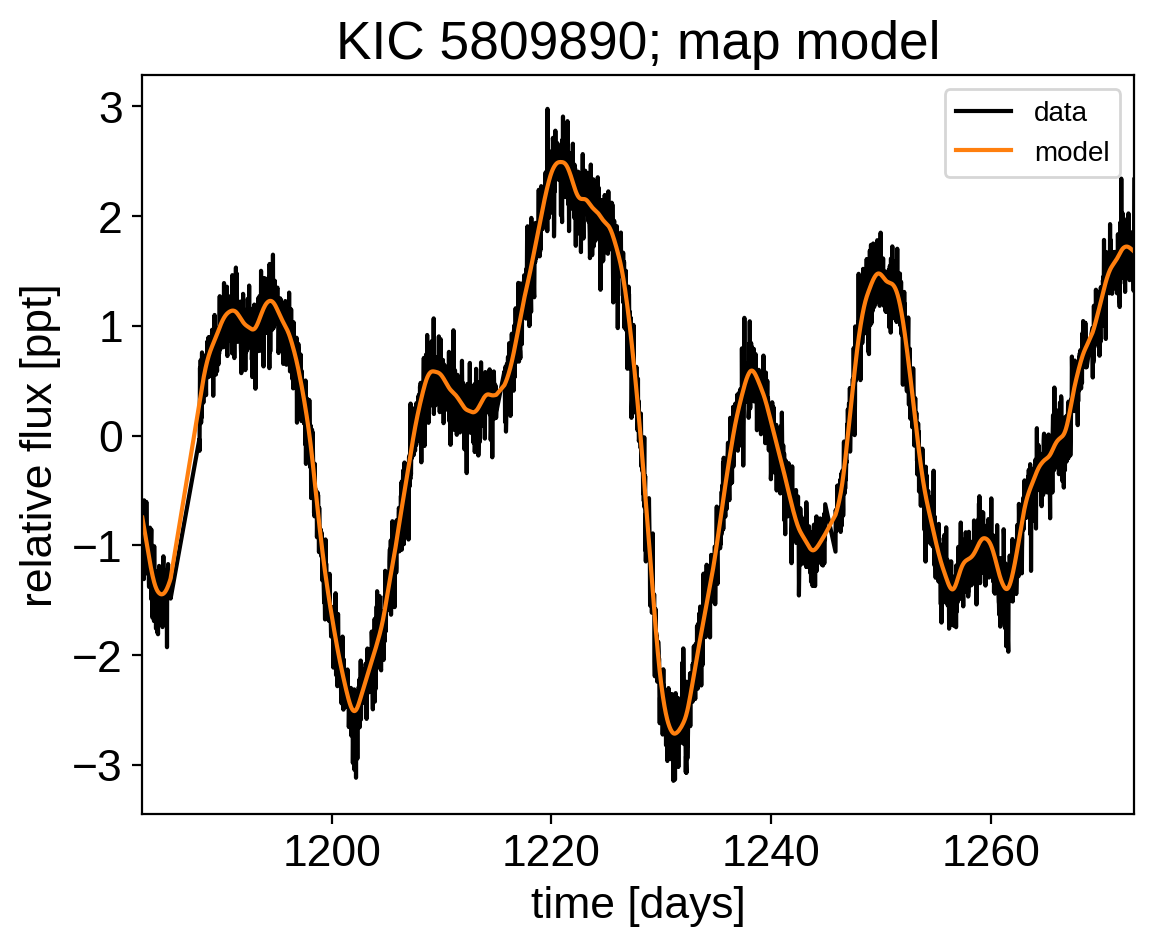

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=2000, draws=2000, start=map_soln, step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 7/16000 [00:00<05:44, 46.42draws/s]

Sampling 4 chains:   0%|          | 11/16000 [00:00<10:38, 25.03draws/s]

Sampling 4 chains:   0%|          | 13/16000 [00:00<22:30, 11.83draws/s]

Sampling 4 chains:   0%|          | 16/16000 [00:01<20:58, 12.70draws/s]

Sampling 4 chains:   0%|          | 19/16000 [00:01<18:06, 14.71draws/s]

Sampling 4 chains:   0%|          | 21/16000 [00:01<21:02, 12.65draws/s]

Sampling 4 chains:   0%|          | 23/16000 [00:01<24:57, 10.67draws/s]

Sampling 4 chains:   0%|          | 27/16000 [00:01<23:55, 11.12draws/s]

Sampling 4 chains:   0%|          | 29/16000 [00:02<23:57, 11.11draws/s]

Sampling 4 chains:   0%|          | 32/16000 [00:02<22:35, 11.78draws/s]

Sampling 4 chains:   0%|          | 34/16000 [00:02<21:31, 12.36draws/s]

Sampling 4 chains:   0%|          | 36/16000 [00:02<21:05, 12.61draws/s]

Sampling 4 chains:   0%|          | 39/16000 [00:02<19:18, 13.77draws/s]

Sampling 4 chains:   0%|          | 41/16000 [00:02<19:45, 13.46draws/s]

Sampling 4 chains:   0%|          | 43/16000 [00:03<21:25, 12.41draws/s]

Sampling 4 chains:   0%|          | 46/16000 [00:03<18:35, 14.30draws/s]

Sampling 4 chains:   0%|          | 48/16000 [00:03<17:20, 15.33draws/s]

Sampling 4 chains:   0%|          | 50/16000 [00:03<17:29, 15.19draws/s]

Sampling 4 chains:   0%|          | 52/16000 [00:03<23:11, 11.46draws/s]

Sampling 4 chains:   0%|          | 55/16000 [00:03<19:31, 13.61draws/s]

Sampling 4 chains:   0%|          | 58/16000 [00:04<20:34, 12.91draws/s]

Sampling 4 chains:   0%|          | 60/16000 [00:04<20:38, 12.87draws/s]

Sampling 4 chains:   0%|          | 64/16000 [00:04<17:38, 15.05draws/s]

Sampling 4 chains:   0%|          | 66/16000 [00:04<19:24, 13.68draws/s]

Sampling 4 chains:   0%|          | 70/16000 [00:04<15:44, 16.87draws/s]

Sampling 4 chains:   0%|          | 73/16000 [00:04<15:37, 16.99draws/s]

Sampling 4 chains:   0%|          | 76/16000 [00:05<15:21, 17.27draws/s]

Sampling 4 chains:   0%|          | 78/16000 [00:05<17:22, 15.27draws/s]

Sampling 4 chains:   0%|          | 80/16000 [00:05<17:49, 14.89draws/s]

Sampling 4 chains:   1%|          | 82/16000 [00:05<17:18, 15.32draws/s]

Sampling 4 chains:   1%|          | 84/16000 [00:05<17:53, 14.82draws/s]

Sampling 4 chains:   1%|          | 86/16000 [00:06<25:51, 10.26draws/s]

Sampling 4 chains:   1%|          | 88/16000 [00:06<28:01,  9.46draws/s]

Sampling 4 chains:   1%|          | 91/16000 [00:06<22:58, 11.54draws/s]

Sampling 4 chains:   1%|          | 93/16000 [00:06<22:24, 11.83draws/s]

Sampling 4 chains:   1%|          | 95/16000 [00:06<20:50, 12.72draws/s]

Sampling 4 chains:   1%|          | 97/16000 [00:07<26:24, 10.04draws/s]

Sampling 4 chains:   1%|          | 100/16000 [00:07<21:36, 12.26draws/s]

Sampling 4 chains:   1%|          | 102/16000 [00:07<19:12, 13.80draws/s]

Sampling 4 chains:   1%|          | 106/16000 [00:07<16:22, 16.18draws/s]

Sampling 4 chains:   1%|          | 109/16000 [00:07<14:51, 17.82draws/s]

Sampling 4 chains:   1%|          | 112/16000 [00:07<15:49, 16.73draws/s]

Sampling 4 chains:   1%|          | 117/16000 [00:07<13:45, 19.25draws/s]

Sampling 4 chains:   1%|          | 121/16000 [00:08<11:55, 22.20draws/s]

Sampling 4 chains:   1%|          | 124/16000 [00:08<11:20, 23.32draws/s]

Sampling 4 chains:   1%|          | 127/16000 [00:08<12:18, 21.50draws/s]

Sampling 4 chains:   1%|          | 130/16000 [00:08<12:58, 20.39draws/s]

Sampling 4 chains:   1%|          | 133/16000 [00:08<14:50, 17.81draws/s]

Sampling 4 chains:   1%|          | 136/16000 [00:08<16:56, 15.61draws/s]

Sampling 4 chains:   1%|          | 138/16000 [00:09<18:31, 14.28draws/s]

Sampling 4 chains:   1%|          | 141/16000 [00:09<16:09, 16.36draws/s]

Sampling 4 chains:   1%|          | 144/16000 [00:09<13:58, 18.91draws/s]

Sampling 4 chains:   1%|          | 147/16000 [00:09<14:11, 18.62draws/s]

Sampling 4 chains:   1%|          | 150/16000 [00:09<13:37, 19.39draws/s]

Sampling 4 chains:   1%|          | 153/16000 [00:09<13:01, 20.27draws/s]

Sampling 4 chains:   1%|          | 156/16000 [00:09<11:51, 22.28draws/s]

Sampling 4 chains:   1%|          | 159/16000 [00:10<12:46, 20.67draws/s]

Sampling 4 chains:   1%|          | 162/16000 [00:10<12:20, 21.39draws/s]

Sampling 4 chains:   1%|          | 167/16000 [00:10<10:13, 25.81draws/s]

Sampling 4 chains:   1%|          | 172/16000 [00:10<09:29, 27.81draws/s]

Sampling 4 chains:   1%|          | 176/16000 [00:10<09:40, 27.27draws/s]

Sampling 4 chains:   1%|          | 183/16000 [00:10<07:54, 33.37draws/s]

Sampling 4 chains:   1%|          | 189/16000 [00:10<06:53, 38.22draws/s]

Sampling 4 chains:   1%|          | 194/16000 [00:10<06:32, 40.31draws/s]

Sampling 4 chains:   1%|          | 199/16000 [00:11<07:39, 34.40draws/s]

Sampling 4 chains:   1%|▏         | 204/16000 [00:11<07:11, 36.58draws/s]

Sampling 4 chains:   1%|▏         | 209/16000 [00:11<07:22, 35.65draws/s]

Sampling 4 chains:   1%|▏         | 214/16000 [00:11<07:39, 34.37draws/s]

Sampling 4 chains:   1%|▏         | 219/16000 [00:11<07:06, 36.99draws/s]

Sampling 4 chains:   1%|▏         | 224/16000 [00:11<06:38, 39.59draws/s]

Sampling 4 chains:   1%|▏         | 229/16000 [00:11<06:57, 37.79draws/s]

Sampling 4 chains:   1%|▏         | 233/16000 [00:12<08:01, 32.72draws/s]

Sampling 4 chains:   1%|▏         | 237/16000 [00:12<07:46, 33.79draws/s]

Sampling 4 chains:   2%|▏         | 243/16000 [00:12<07:00, 37.47draws/s]

Sampling 4 chains:   2%|▏         | 249/16000 [00:12<06:16, 41.85draws/s]

Sampling 4 chains:   2%|▏         | 254/16000 [00:12<06:21, 41.29draws/s]

Sampling 4 chains:   2%|▏         | 259/16000 [00:12<08:11, 32.05draws/s]

Sampling 4 chains:   2%|▏         | 263/16000 [00:12<07:47, 33.63draws/s]

Sampling 4 chains:   2%|▏         | 268/16000 [00:13<09:02, 28.98draws/s]

Sampling 4 chains:   2%|▏         | 274/16000 [00:13<08:34, 30.57draws/s]

Sampling 4 chains:   2%|▏         | 278/16000 [00:13<09:14, 28.35draws/s]

Sampling 4 chains:   2%|▏         | 282/16000 [00:13<09:20, 28.05draws/s]

Sampling 4 chains:   2%|▏         | 285/16000 [00:13<09:09, 28.60draws/s]

Sampling 4 chains:   2%|▏         | 292/16000 [00:13<08:01, 32.61draws/s]

Sampling 4 chains:   2%|▏         | 299/16000 [00:13<06:52, 38.04draws/s]

Sampling 4 chains:   2%|▏         | 304/16000 [00:13<06:35, 39.73draws/s]

Sampling 4 chains:   2%|▏         | 309/16000 [00:14<06:37, 39.48draws/s]

Sampling 4 chains:   2%|▏         | 316/16000 [00:14<06:09, 42.40draws/s]

Sampling 4 chains:   2%|▏         | 323/16000 [00:14<05:42, 45.79draws/s]

Sampling 4 chains:   2%|▏         | 330/16000 [00:14<05:09, 50.64draws/s]

Sampling 4 chains:   2%|▏         | 336/16000 [00:14<05:26, 47.95draws/s]

Sampling 4 chains:   2%|▏         | 342/16000 [00:14<05:25, 48.12draws/s]

Sampling 4 chains:   2%|▏         | 347/16000 [00:14<05:41, 45.81draws/s]

Sampling 4 chains:   2%|▏         | 352/16000 [00:15<06:03, 43.02draws/s]

Sampling 4 chains:   2%|▏         | 357/16000 [00:15<05:54, 44.09draws/s]

Sampling 4 chains:   2%|▏         | 362/16000 [00:15<05:52, 44.32draws/s]

Sampling 4 chains:   2%|▏         | 367/16000 [00:15<06:25, 40.53draws/s]

Sampling 4 chains:   2%|▏         | 372/16000 [00:15<06:03, 42.94draws/s]

Sampling 4 chains:   2%|▏         | 377/16000 [00:15<06:40, 39.05draws/s]

Sampling 4 chains:   2%|▏         | 383/16000 [00:15<06:34, 39.60draws/s]

Sampling 4 chains:   2%|▏         | 389/16000 [00:15<06:02, 43.10draws/s]

Sampling 4 chains:   2%|▏         | 394/16000 [00:15<05:48, 44.79draws/s]

Sampling 4 chains:   2%|▏         | 399/16000 [00:16<06:22, 40.81draws/s]

Sampling 4 chains:   3%|▎         | 405/16000 [00:16<05:49, 44.65draws/s]

Sampling 4 chains:   3%|▎         | 410/16000 [00:16<06:21, 40.88draws/s]

Sampling 4 chains:   3%|▎         | 415/16000 [00:16<06:08, 42.34draws/s]

Sampling 4 chains:   3%|▎         | 420/16000 [00:16<05:56, 43.76draws/s]

Sampling 4 chains:   3%|▎         | 426/16000 [00:16<05:48, 44.64draws/s]

Sampling 4 chains:   3%|▎         | 431/16000 [00:16<05:43, 45.36draws/s]

Sampling 4 chains:   3%|▎         | 438/16000 [00:16<05:10, 50.20draws/s]

Sampling 4 chains:   3%|▎         | 444/16000 [00:17<06:04, 42.66draws/s]

Sampling 4 chains:   3%|▎         | 452/16000 [00:17<05:28, 47.27draws/s]

Sampling 4 chains:   3%|▎         | 462/16000 [00:17<04:39, 55.59draws/s]

Sampling 4 chains:   3%|▎         | 470/16000 [00:17<04:24, 58.74draws/s]

Sampling 4 chains:   3%|▎         | 479/16000 [00:17<04:12, 61.49draws/s]

Sampling 4 chains:   3%|▎         | 489/16000 [00:17<03:53, 66.31draws/s]

Sampling 4 chains:   3%|▎         | 497/16000 [00:17<04:03, 63.61draws/s]

Sampling 4 chains:   3%|▎         | 505/16000 [00:17<03:58, 65.05draws/s]

Sampling 4 chains:   3%|▎         | 513/16000 [00:18<03:51, 66.93draws/s]

Sampling 4 chains:   3%|▎         | 520/16000 [00:18<03:48, 67.78draws/s]

Sampling 4 chains:   3%|▎         | 528/16000 [00:18<03:41, 69.89draws/s]

Sampling 4 chains:   3%|▎         | 536/16000 [00:18<03:56, 65.52draws/s]

Sampling 4 chains:   3%|▎         | 543/16000 [00:18<04:06, 62.78draws/s]

Sampling 4 chains:   3%|▎         | 551/16000 [00:18<03:58, 64.82draws/s]

Sampling 4 chains:   4%|▎         | 561/16000 [00:18<03:47, 67.96draws/s]

Sampling 4 chains:   4%|▎         | 572/16000 [00:18<03:26, 74.56draws/s]

Sampling 4 chains:   4%|▎         | 581/16000 [00:19<03:20, 76.86draws/s]

Sampling 4 chains:   4%|▎         | 589/16000 [00:19<03:22, 76.04draws/s]

Sampling 4 chains:   4%|▎         | 597/16000 [00:19<03:36, 71.17draws/s]

Sampling 4 chains:   4%|▍         | 605/16000 [00:19<03:41, 69.38draws/s]

Sampling 4 chains:   4%|▍         | 616/16000 [00:19<03:24, 75.18draws/s]

Sampling 4 chains:   4%|▍         | 626/16000 [00:19<03:16, 78.21draws/s]

Sampling 4 chains:   4%|▍         | 636/16000 [00:19<03:04, 83.14draws/s]

Sampling 4 chains:   4%|▍         | 645/16000 [00:19<03:27, 73.93draws/s]

Sampling 4 chains:   4%|▍         | 655/16000 [00:19<03:13, 79.27draws/s]

Sampling 4 chains:   4%|▍         | 664/16000 [00:20<03:31, 72.40draws/s]

Sampling 4 chains:   4%|▍         | 674/16000 [00:20<03:16, 77.91draws/s]

Sampling 4 chains:   4%|▍         | 685/16000 [00:20<03:01, 84.27draws/s]

Sampling 4 chains:   4%|▍         | 694/16000 [00:20<03:28, 73.56draws/s]

Sampling 4 chains:   4%|▍         | 702/16000 [00:20<03:41, 69.19draws/s]

Sampling 4 chains:   4%|▍         | 714/16000 [00:20<03:17, 77.33draws/s]

Sampling 4 chains:   5%|▍         | 724/16000 [00:20<03:09, 80.63draws/s]

Sampling 4 chains:   5%|▍         | 733/16000 [00:20<03:17, 77.22draws/s]

Sampling 4 chains:   5%|▍         | 742/16000 [00:21<03:40, 69.26draws/s]

Sampling 4 chains:   5%|▍         | 752/16000 [00:21<03:22, 75.24draws/s]

Sampling 4 chains:   5%|▍         | 760/16000 [00:21<03:21, 75.68draws/s]

Sampling 4 chains:   5%|▍         | 769/16000 [00:21<03:13, 78.64draws/s]

Sampling 4 chains:   5%|▍         | 778/16000 [00:21<03:18, 76.56draws/s]

Sampling 4 chains:   5%|▍         | 786/16000 [00:21<03:25, 73.93draws/s]

Sampling 4 chains:   5%|▍         | 795/16000 [00:21<03:19, 76.34draws/s]

Sampling 4 chains:   5%|▌         | 803/16000 [00:21<03:25, 73.78draws/s]

Sampling 4 chains:   5%|▌         | 811/16000 [00:22<03:42, 68.39draws/s]

Sampling 4 chains:   5%|▌         | 818/16000 [00:22<03:44, 67.68draws/s]

Sampling 4 chains:   5%|▌         | 826/16000 [00:22<03:36, 70.10draws/s]

Sampling 4 chains:   5%|▌         | 834/16000 [00:22<03:37, 69.61draws/s]

Sampling 4 chains:   5%|▌         | 845/16000 [00:22<03:15, 77.50draws/s]

Sampling 4 chains:   5%|▌         | 854/16000 [00:22<03:12, 78.82draws/s]

Sampling 4 chains:   5%|▌         | 863/16000 [00:22<03:32, 71.37draws/s]

Sampling 4 chains:   5%|▌         | 871/16000 [00:22<03:39, 69.06draws/s]

Sampling 4 chains:   6%|▌         | 880/16000 [00:23<03:30, 71.95draws/s]

Sampling 4 chains:   6%|▌         | 888/16000 [00:23<03:26, 73.20draws/s]

Sampling 4 chains:   6%|▌         | 898/16000 [00:23<03:12, 78.64draws/s]

Sampling 4 chains:   6%|▌         | 907/16000 [00:23<03:29, 71.96draws/s]

Sampling 4 chains:   6%|▌         | 917/16000 [00:23<03:18, 76.18draws/s]

Sampling 4 chains:   6%|▌         | 925/16000 [00:23<03:46, 66.51draws/s]

Sampling 4 chains:   6%|▌         | 934/16000 [00:23<03:28, 72.11draws/s]

Sampling 4 chains:   6%|▌         | 944/16000 [00:23<03:26, 72.87draws/s]

Sampling 4 chains:   6%|▌         | 952/16000 [00:23<03:30, 71.43draws/s]

Sampling 4 chains:   6%|▌         | 960/16000 [00:24<03:30, 71.47draws/s]

Sampling 4 chains:   6%|▌         | 969/16000 [00:24<03:18, 75.63draws/s]

Sampling 4 chains:   6%|▌         | 977/16000 [00:24<03:35, 69.84draws/s]

Sampling 4 chains:   6%|▌         | 987/16000 [00:24<03:26, 72.72draws/s]

Sampling 4 chains:   6%|▌         | 996/16000 [00:24<03:16, 76.32draws/s]

Sampling 4 chains:   6%|▋         | 1004/16000 [00:24<03:16, 76.45draws/s]

Sampling 4 chains:   6%|▋         | 1012/16000 [00:24<03:14, 77.21draws/s]

Sampling 4 chains:   6%|▋         | 1020/16000 [00:24<03:21, 74.37draws/s]

Sampling 4 chains:   6%|▋         | 1028/16000 [00:25<03:42, 67.25draws/s]

Sampling 4 chains:   6%|▋         | 1036/16000 [00:25<03:33, 70.17draws/s]

Sampling 4 chains:   7%|▋         | 1045/16000 [00:25<03:21, 74.11draws/s]

Sampling 4 chains:   7%|▋         | 1053/16000 [00:25<03:20, 74.69draws/s]

Sampling 4 chains:   7%|▋         | 1062/16000 [00:25<03:16, 76.13draws/s]

Sampling 4 chains:   7%|▋         | 1070/16000 [00:25<03:17, 75.77draws/s]

Sampling 4 chains:   7%|▋         | 1079/16000 [00:25<03:10, 78.33draws/s]

Sampling 4 chains:   7%|▋         | 1087/16000 [00:25<03:21, 73.93draws/s]

Sampling 4 chains:   7%|▋         | 1095/16000 [00:25<03:26, 72.16draws/s]

Sampling 4 chains:   7%|▋         | 1104/16000 [00:26<03:16, 75.68draws/s]

Sampling 4 chains:   7%|▋         | 1113/16000 [00:26<03:21, 73.78draws/s]

Sampling 4 chains:   7%|▋         | 1121/16000 [00:26<03:52, 63.87draws/s]

Sampling 4 chains:   7%|▋         | 1131/16000 [00:26<03:29, 70.98draws/s]

Sampling 4 chains:   7%|▋         | 1139/16000 [00:26<03:31, 70.25draws/s]

Sampling 4 chains:   7%|▋         | 1147/16000 [00:26<03:29, 71.03draws/s]

Sampling 4 chains:   7%|▋         | 1155/16000 [00:26<03:33, 69.50draws/s]

Sampling 4 chains:   7%|▋         | 1166/16000 [00:26<03:15, 75.96draws/s]

Sampling 4 chains:   7%|▋         | 1174/16000 [00:26<03:17, 75.03draws/s]

Sampling 4 chains:   7%|▋         | 1184/16000 [00:27<03:05, 79.82draws/s]

Sampling 4 chains:   7%|▋         | 1193/16000 [00:27<03:03, 80.75draws/s]

Sampling 4 chains:   8%|▊         | 1202/16000 [00:27<03:06, 79.39draws/s]

Sampling 4 chains:   8%|▊         | 1211/16000 [00:27<03:15, 75.61draws/s]

Sampling 4 chains:   8%|▊         | 1220/16000 [00:27<03:06, 79.36draws/s]

Sampling 4 chains:   8%|▊         | 1229/16000 [00:27<03:07, 78.62draws/s]

Sampling 4 chains:   8%|▊         | 1239/16000 [00:27<02:56, 83.41draws/s]

Sampling 4 chains:   8%|▊         | 1248/16000 [00:27<03:01, 81.29draws/s]

Sampling 4 chains:   8%|▊         | 1257/16000 [00:27<02:58, 82.76draws/s]

Sampling 4 chains:   8%|▊         | 1266/16000 [00:28<02:59, 81.89draws/s]

Sampling 4 chains:   8%|▊         | 1275/16000 [00:28<03:02, 80.46draws/s]

Sampling 4 chains:   8%|▊         | 1284/16000 [00:28<02:57, 82.89draws/s]

Sampling 4 chains:   8%|▊         | 1293/16000 [00:28<03:00, 81.61draws/s]

Sampling 4 chains:   8%|▊         | 1302/16000 [00:28<02:56, 83.49draws/s]

Sampling 4 chains:   8%|▊         | 1311/16000 [00:28<03:11, 76.85draws/s]

Sampling 4 chains:   8%|▊         | 1319/16000 [00:28<03:17, 74.23draws/s]

Sampling 4 chains:   8%|▊         | 1328/16000 [00:28<03:12, 76.06draws/s]

Sampling 4 chains:   8%|▊         | 1336/16000 [00:29<03:32, 69.02draws/s]

Sampling 4 chains:   8%|▊         | 1344/16000 [00:29<03:39, 66.69draws/s]

Sampling 4 chains:   8%|▊         | 1351/16000 [00:29<03:44, 65.25draws/s]

Sampling 4 chains:   8%|▊         | 1358/16000 [00:29<03:56, 61.87draws/s]

Sampling 4 chains:   9%|▊         | 1365/16000 [00:29<03:58, 61.25draws/s]

Sampling 4 chains:   9%|▊         | 1372/16000 [00:29<03:51, 63.19draws/s]

Sampling 4 chains:   9%|▊         | 1380/16000 [00:29<04:03, 59.94draws/s]

Sampling 4 chains:   9%|▊         | 1387/16000 [00:29<04:04, 59.69draws/s]

Sampling 4 chains:   9%|▊         | 1394/16000 [00:30<04:12, 57.92draws/s]

Sampling 4 chains:   9%|▉         | 1400/16000 [00:30<04:34, 53.26draws/s]

Sampling 4 chains:   9%|▉         | 1406/16000 [00:30<04:31, 53.66draws/s]

Sampling 4 chains:   9%|▉         | 1412/16000 [00:30<04:25, 54.98draws/s]

Sampling 4 chains:   9%|▉         | 1418/16000 [00:30<04:50, 50.12draws/s]

Sampling 4 chains:   9%|▉         | 1424/16000 [00:30<05:22, 45.18draws/s]

Sampling 4 chains:   9%|▉         | 1431/16000 [00:30<05:10, 46.98draws/s]

Sampling 4 chains:   9%|▉         | 1438/16000 [00:30<04:49, 50.31draws/s]

Sampling 4 chains:   9%|▉         | 1447/16000 [00:31<04:16, 56.67draws/s]

Sampling 4 chains:   9%|▉         | 1454/16000 [00:31<04:05, 59.33draws/s]

Sampling 4 chains:   9%|▉         | 1462/16000 [00:31<03:48, 63.55draws/s]

Sampling 4 chains:   9%|▉         | 1469/16000 [00:31<04:02, 59.96draws/s]

Sampling 4 chains:   9%|▉         | 1476/16000 [00:31<03:57, 61.27draws/s]

Sampling 4 chains:   9%|▉         | 1483/16000 [00:31<03:52, 62.50draws/s]

Sampling 4 chains:   9%|▉         | 1490/16000 [00:31<04:05, 59.15draws/s]

Sampling 4 chains:   9%|▉         | 1497/16000 [00:31<04:04, 59.27draws/s]

Sampling 4 chains:   9%|▉         | 1505/16000 [00:32<04:11, 57.62draws/s]

Sampling 4 chains:   9%|▉         | 1513/16000 [00:32<03:55, 61.51draws/s]

Sampling 4 chains:  10%|▉         | 1520/16000 [00:32<04:21, 55.28draws/s]

Sampling 4 chains:  10%|▉         | 1526/16000 [00:32<04:50, 49.80draws/s]

Sampling 4 chains:  10%|▉         | 1532/16000 [00:32<04:42, 51.19draws/s]

Sampling 4 chains:  10%|▉         | 1539/16000 [00:32<04:38, 51.88draws/s]

Sampling 4 chains:  10%|▉         | 1549/16000 [00:32<04:12, 57.18draws/s]

Sampling 4 chains:  10%|▉         | 1556/16000 [00:32<04:02, 59.62draws/s]

Sampling 4 chains:  10%|▉         | 1563/16000 [00:33<03:55, 61.36draws/s]

Sampling 4 chains:  10%|▉         | 1573/16000 [00:33<03:37, 66.40draws/s]

Sampling 4 chains:  10%|▉         | 1583/16000 [00:33<03:19, 72.32draws/s]

Sampling 4 chains:  10%|▉         | 1591/16000 [00:33<03:23, 70.90draws/s]

Sampling 4 chains:  10%|▉         | 1599/16000 [00:33<03:29, 68.82draws/s]

Sampling 4 chains:  10%|█         | 1607/16000 [00:33<03:30, 68.41draws/s]

Sampling 4 chains:  10%|█         | 1614/16000 [00:33<03:34, 67.21draws/s]

Sampling 4 chains:  10%|█         | 1622/16000 [00:33<03:24, 70.29draws/s]

Sampling 4 chains:  10%|█         | 1630/16000 [00:33<03:21, 71.48draws/s]

Sampling 4 chains:  10%|█         | 1640/16000 [00:34<03:06, 76.80draws/s]

Sampling 4 chains:  10%|█         | 1649/16000 [00:34<03:07, 76.43draws/s]

Sampling 4 chains:  10%|█         | 1657/16000 [00:34<03:11, 75.05draws/s]

Sampling 4 chains:  10%|█         | 1665/16000 [00:34<03:11, 74.78draws/s]

Sampling 4 chains:  10%|█         | 1673/16000 [00:34<03:26, 69.51draws/s]

Sampling 4 chains:  11%|█         | 1682/16000 [00:34<03:28, 68.79draws/s]

Sampling 4 chains:  11%|█         | 1691/16000 [00:34<03:21, 71.14draws/s]

Sampling 4 chains:  11%|█         | 1701/16000 [00:34<03:07, 76.09draws/s]

Sampling 4 chains:  11%|█         | 1710/16000 [00:34<03:00, 79.16draws/s]

Sampling 4 chains:  11%|█         | 1719/16000 [00:35<03:15, 73.08draws/s]

Sampling 4 chains:  11%|█         | 1727/16000 [00:35<03:22, 70.34draws/s]

Sampling 4 chains:  11%|█         | 1735/16000 [00:35<03:38, 65.32draws/s]

Sampling 4 chains:  11%|█         | 1742/16000 [00:35<03:42, 64.03draws/s]

Sampling 4 chains:  11%|█         | 1749/16000 [00:35<04:08, 57.36draws/s]

Sampling 4 chains:  11%|█         | 1758/16000 [00:35<03:55, 60.50draws/s]

Sampling 4 chains:  11%|█         | 1767/16000 [00:35<03:39, 64.99draws/s]

Sampling 4 chains:  11%|█         | 1777/16000 [00:36<03:26, 68.76draws/s]

Sampling 4 chains:  11%|█         | 1785/16000 [00:36<03:32, 66.83draws/s]

Sampling 4 chains:  11%|█         | 1792/16000 [00:36<03:43, 63.49draws/s]

Sampling 4 chains:  11%|█         | 1799/16000 [00:36<03:44, 63.38draws/s]

Sampling 4 chains:  11%|█▏        | 1806/16000 [00:36<03:51, 61.20draws/s]

Sampling 4 chains:  11%|█▏        | 1813/16000 [00:36<03:56, 59.89draws/s]

Sampling 4 chains:  11%|█▏        | 1822/16000 [00:36<03:44, 63.21draws/s]

Sampling 4 chains:  11%|█▏        | 1831/16000 [00:36<03:28, 68.09draws/s]

Sampling 4 chains:  12%|█▏        | 1840/16000 [00:36<03:16, 72.12draws/s]

Sampling 4 chains:  12%|█▏        | 1848/16000 [00:37<03:10, 74.26draws/s]

Sampling 4 chains:  12%|█▏        | 1856/16000 [00:37<03:41, 63.79draws/s]

Sampling 4 chains:  12%|█▏        | 1863/16000 [00:37<03:46, 62.39draws/s]

Sampling 4 chains:  12%|█▏        | 1873/16000 [00:37<03:33, 66.32draws/s]

Sampling 4 chains:  12%|█▏        | 1881/16000 [00:37<03:28, 67.84draws/s]

Sampling 4 chains:  12%|█▏        | 1888/16000 [00:37<03:31, 66.57draws/s]

Sampling 4 chains:  12%|█▏        | 1895/16000 [00:37<03:37, 64.72draws/s]

Sampling 4 chains:  12%|█▏        | 1902/16000 [00:37<03:52, 60.63draws/s]

Sampling 4 chains:  12%|█▏        | 1910/16000 [00:38<03:43, 63.10draws/s]

Sampling 4 chains:  12%|█▏        | 1917/16000 [00:38<03:55, 59.68draws/s]

Sampling 4 chains:  12%|█▏        | 1924/16000 [00:38<03:49, 61.42draws/s]

Sampling 4 chains:  12%|█▏        | 1933/16000 [00:38<03:27, 67.75draws/s]

Sampling 4 chains:  12%|█▏        | 1941/16000 [00:38<03:44, 62.75draws/s]

Sampling 4 chains:  12%|█▏        | 1951/16000 [00:38<03:20, 69.96draws/s]

Sampling 4 chains:  12%|█▏        | 1959/16000 [00:38<03:13, 72.51draws/s]

Sampling 4 chains:  12%|█▏        | 1967/16000 [00:38<03:08, 74.33draws/s]

Sampling 4 chains:  12%|█▏        | 1978/16000 [00:38<02:57, 78.91draws/s]

Sampling 4 chains:  12%|█▏        | 1988/16000 [00:39<02:47, 83.71draws/s]

Sampling 4 chains:  12%|█▏        | 1997/16000 [00:39<02:49, 82.78draws/s]

Sampling 4 chains:  13%|█▎        | 2006/16000 [00:39<02:47, 83.33draws/s]

Sampling 4 chains:  13%|█▎        | 2015/16000 [00:39<02:53, 80.41draws/s]

Sampling 4 chains:  13%|█▎        | 2024/16000 [00:39<02:50, 82.19draws/s]

Sampling 4 chains:  13%|█▎        | 2033/16000 [00:39<02:50, 81.75draws/s]

Sampling 4 chains:  13%|█▎        | 2042/16000 [00:39<03:04, 75.74draws/s]

Sampling 4 chains:  13%|█▎        | 2052/16000 [00:39<03:00, 77.33draws/s]

Sampling 4 chains:  13%|█▎        | 2061/16000 [00:39<02:54, 80.03draws/s]

Sampling 4 chains:  13%|█▎        | 2070/16000 [00:40<02:55, 79.20draws/s]

Sampling 4 chains:  13%|█▎        | 2078/16000 [00:40<03:11, 72.55draws/s]

Sampling 4 chains:  13%|█▎        | 2086/16000 [00:40<03:09, 73.51draws/s]

Sampling 4 chains:  13%|█▎        | 2096/16000 [00:40<03:06, 74.74draws/s]

Sampling 4 chains:  13%|█▎        | 2104/16000 [00:40<03:15, 71.12draws/s]

Sampling 4 chains:  13%|█▎        | 2112/16000 [00:40<03:11, 72.50draws/s]

Sampling 4 chains:  13%|█▎        | 2122/16000 [00:40<03:01, 76.34draws/s]

Sampling 4 chains:  13%|█▎        | 2131/16000 [00:40<02:56, 78.53draws/s]

Sampling 4 chains:  13%|█▎        | 2141/16000 [00:41<02:47, 82.60draws/s]

Sampling 4 chains:  13%|█▎        | 2150/16000 [00:41<02:46, 83.20draws/s]

Sampling 4 chains:  13%|█▎        | 2159/16000 [00:41<02:57, 77.94draws/s]

Sampling 4 chains:  14%|█▎        | 2167/16000 [00:41<02:58, 77.44draws/s]

Sampling 4 chains:  14%|█▎        | 2176/16000 [00:41<02:51, 80.75draws/s]

Sampling 4 chains:  14%|█▎        | 2185/16000 [00:41<02:54, 79.30draws/s]

Sampling 4 chains:  14%|█▎        | 2194/16000 [00:41<03:04, 74.67draws/s]

Sampling 4 chains:  14%|█▍        | 2203/16000 [00:41<02:56, 77.99draws/s]

Sampling 4 chains:  14%|█▍        | 2213/16000 [00:41<02:51, 80.45draws/s]

Sampling 4 chains:  14%|█▍        | 2222/16000 [00:42<02:47, 82.27draws/s]

Sampling 4 chains:  14%|█▍        | 2231/16000 [00:42<03:05, 74.27draws/s]

Sampling 4 chains:  14%|█▍        | 2239/16000 [00:42<03:26, 66.54draws/s]

Sampling 4 chains:  14%|█▍        | 2246/16000 [00:42<03:29, 65.68draws/s]

Sampling 4 chains:  14%|█▍        | 2253/16000 [00:42<03:34, 64.16draws/s]

Sampling 4 chains:  14%|█▍        | 2263/16000 [00:42<03:20, 68.35draws/s]

Sampling 4 chains:  14%|█▍        | 2275/16000 [00:42<03:06, 73.52draws/s]

Sampling 4 chains:  14%|█▍        | 2284/16000 [00:42<02:58, 76.99draws/s]

Sampling 4 chains:  14%|█▍        | 2294/16000 [00:43<02:48, 81.14draws/s]

Sampling 4 chains:  14%|█▍        | 2304/16000 [00:43<02:41, 85.05draws/s]

Sampling 4 chains:  14%|█▍        | 2314/16000 [00:43<02:39, 85.79draws/s]

Sampling 4 chains:  15%|█▍        | 2323/16000 [00:43<02:49, 80.76draws/s]

Sampling 4 chains:  15%|█▍        | 2332/16000 [00:43<02:53, 78.77draws/s]

Sampling 4 chains:  15%|█▍        | 2342/16000 [00:43<02:45, 82.72draws/s]

Sampling 4 chains:  15%|█▍        | 2351/16000 [00:43<02:52, 78.94draws/s]

Sampling 4 chains:  15%|█▍        | 2360/16000 [00:43<02:52, 78.92draws/s]

Sampling 4 chains:  15%|█▍        | 2370/16000 [00:43<02:43, 83.11draws/s]

Sampling 4 chains:  15%|█▍        | 2379/16000 [00:44<02:54, 78.26draws/s]

Sampling 4 chains:  15%|█▍        | 2387/16000 [00:44<03:04, 73.87draws/s]

Sampling 4 chains:  15%|█▍        | 2396/16000 [00:44<03:03, 74.09draws/s]

Sampling 4 chains:  15%|█▌        | 2406/16000 [00:44<02:50, 79.76draws/s]

Sampling 4 chains:  15%|█▌        | 2415/16000 [00:44<02:55, 77.45draws/s]

Sampling 4 chains:  15%|█▌        | 2425/16000 [00:44<02:44, 82.70draws/s]

Sampling 4 chains:  15%|█▌        | 2434/16000 [00:44<03:07, 72.52draws/s]

Sampling 4 chains:  15%|█▌        | 2442/16000 [00:44<03:19, 67.93draws/s]

Sampling 4 chains:  15%|█▌        | 2450/16000 [00:45<03:12, 70.21draws/s]

Sampling 4 chains:  15%|█▌        | 2458/16000 [00:45<03:36, 62.42draws/s]

Sampling 4 chains:  15%|█▌        | 2467/16000 [00:45<03:18, 68.24draws/s]

Sampling 4 chains:  15%|█▌        | 2475/16000 [00:45<03:12, 70.12draws/s]

Sampling 4 chains:  16%|█▌        | 2485/16000 [00:45<02:58, 75.87draws/s]

Sampling 4 chains:  16%|█▌        | 2495/16000 [00:45<02:47, 80.68draws/s]

Sampling 4 chains:  16%|█▌        | 2505/16000 [00:45<02:42, 82.84draws/s]

Sampling 4 chains:  16%|█▌        | 2515/16000 [00:45<02:36, 86.43draws/s]

Sampling 4 chains:  16%|█▌        | 2524/16000 [00:45<02:46, 81.06draws/s]

Sampling 4 chains:  16%|█▌        | 2533/16000 [00:46<02:51, 78.59draws/s]

Sampling 4 chains:  16%|█▌        | 2542/16000 [00:46<02:45, 81.38draws/s]

Sampling 4 chains:  16%|█▌        | 2551/16000 [00:46<03:09, 70.81draws/s]

Sampling 4 chains:  16%|█▌        | 2559/16000 [00:46<03:16, 68.24draws/s]

Sampling 4 chains:  16%|█▌        | 2567/16000 [00:46<03:39, 61.10draws/s]

Sampling 4 chains:  16%|█▌        | 2574/16000 [00:46<03:41, 60.59draws/s]

Sampling 4 chains:  16%|█▌        | 2583/16000 [00:46<03:21, 66.59draws/s]

Sampling 4 chains:  16%|█▌        | 2591/16000 [00:47<03:15, 68.52draws/s]

Sampling 4 chains:  16%|█▋        | 2600/16000 [00:47<03:15, 68.53draws/s]

Sampling 4 chains:  16%|█▋        | 2608/16000 [00:47<03:15, 68.54draws/s]

Sampling 4 chains:  16%|█▋        | 2617/16000 [00:47<03:11, 69.88draws/s]

Sampling 4 chains:  16%|█▋        | 2625/16000 [00:47<03:10, 70.25draws/s]

Sampling 4 chains:  16%|█▋        | 2633/16000 [00:47<03:10, 70.34draws/s]

Sampling 4 chains:  17%|█▋        | 2641/16000 [00:47<03:05, 72.07draws/s]

Sampling 4 chains:  17%|█▋        | 2651/16000 [00:47<02:53, 76.97draws/s]

Sampling 4 chains:  17%|█▋        | 2660/16000 [00:47<02:47, 79.50draws/s]

Sampling 4 chains:  17%|█▋        | 2669/16000 [00:48<02:42, 82.15draws/s]

Sampling 4 chains:  17%|█▋        | 2680/16000 [00:48<02:32, 87.08draws/s]

Sampling 4 chains:  17%|█▋        | 2689/16000 [00:48<02:36, 85.23draws/s]

Sampling 4 chains:  17%|█▋        | 2698/16000 [00:48<02:42, 81.69draws/s]

Sampling 4 chains:  17%|█▋        | 2707/16000 [00:48<02:50, 78.01draws/s]

Sampling 4 chains:  17%|█▋        | 2716/16000 [00:48<02:50, 77.87draws/s]

Sampling 4 chains:  17%|█▋        | 2726/16000 [00:48<02:52, 76.94draws/s]

Sampling 4 chains:  17%|█▋        | 2734/16000 [00:48<03:02, 72.56draws/s]

Sampling 4 chains:  17%|█▋        | 2742/16000 [00:48<03:11, 69.19draws/s]

Sampling 4 chains:  17%|█▋        | 2750/16000 [00:49<03:06, 70.90draws/s]

Sampling 4 chains:  17%|█▋        | 2758/16000 [00:49<03:31, 62.57draws/s]

Sampling 4 chains:  17%|█▋        | 2765/16000 [00:49<03:38, 60.44draws/s]

Sampling 4 chains:  17%|█▋        | 2772/16000 [00:49<03:38, 60.54draws/s]

Sampling 4 chains:  17%|█▋        | 2781/16000 [00:49<03:17, 66.78draws/s]

Sampling 4 chains:  17%|█▋        | 2790/16000 [00:49<03:13, 68.14draws/s]

Sampling 4 chains:  18%|█▊        | 2801/16000 [00:49<02:54, 75.48draws/s]

Sampling 4 chains:  18%|█▊        | 2811/16000 [00:49<02:43, 80.43draws/s]

Sampling 4 chains:  18%|█▊        | 2821/16000 [00:50<02:37, 83.66draws/s]

Sampling 4 chains:  18%|█▊        | 2832/16000 [00:50<02:31, 87.06draws/s]

Sampling 4 chains:  18%|█▊        | 2841/16000 [00:50<02:32, 86.16draws/s]

Sampling 4 chains:  18%|█▊        | 2850/16000 [00:50<02:36, 84.14draws/s]

Sampling 4 chains:  18%|█▊        | 2859/16000 [00:50<02:54, 75.15draws/s]

Sampling 4 chains:  18%|█▊        | 2868/16000 [00:50<02:48, 77.76draws/s]

Sampling 4 chains:  18%|█▊        | 2876/16000 [00:50<02:51, 76.68draws/s]

Sampling 4 chains:  18%|█▊        | 2884/16000 [00:50<03:10, 68.82draws/s]

Sampling 4 chains:  18%|█▊        | 2892/16000 [00:51<03:14, 67.44draws/s]

Sampling 4 chains:  18%|█▊        | 2899/16000 [00:51<03:13, 67.59draws/s]

Sampling 4 chains:  18%|█▊        | 2907/16000 [00:51<03:05, 70.41draws/s]

Sampling 4 chains:  18%|█▊        | 2915/16000 [00:51<03:05, 70.63draws/s]

Sampling 4 chains:  18%|█▊        | 2923/16000 [00:51<03:04, 70.85draws/s]

Sampling 4 chains:  18%|█▊        | 2931/16000 [00:51<03:20, 65.29draws/s]

Sampling 4 chains:  18%|█▊        | 2939/16000 [00:51<03:09, 69.07draws/s]

Sampling 4 chains:  18%|█▊        | 2949/16000 [00:51<02:59, 72.90draws/s]

Sampling 4 chains:  18%|█▊        | 2957/16000 [00:51<03:01, 72.03draws/s]

Sampling 4 chains:  19%|█▊        | 2965/16000 [00:52<03:05, 70.13draws/s]

Sampling 4 chains:  19%|█▊        | 2975/16000 [00:52<02:51, 75.82draws/s]

Sampling 4 chains:  19%|█▊        | 2985/16000 [00:52<02:52, 75.63draws/s]

Sampling 4 chains:  19%|█▊        | 2993/16000 [00:52<02:50, 76.08draws/s]

Sampling 4 chains:  19%|█▉        | 3001/16000 [00:52<03:28, 62.35draws/s]

Sampling 4 chains:  19%|█▉        | 3009/16000 [00:52<03:21, 64.54draws/s]

Sampling 4 chains:  19%|█▉        | 3017/16000 [00:52<03:18, 65.47draws/s]

Sampling 4 chains:  19%|█▉        | 3024/16000 [00:52<03:14, 66.59draws/s]

Sampling 4 chains:  19%|█▉        | 3032/16000 [00:53<03:11, 67.85draws/s]

Sampling 4 chains:  19%|█▉        | 3040/16000 [00:53<03:09, 68.34draws/s]

Sampling 4 chains:  19%|█▉        | 3047/16000 [00:53<03:17, 65.44draws/s]

Sampling 4 chains:  19%|█▉        | 3056/16000 [00:53<03:04, 70.01draws/s]

Sampling 4 chains:  19%|█▉        | 3065/16000 [00:53<02:54, 74.31draws/s]

Sampling 4 chains:  19%|█▉        | 3073/16000 [00:53<03:05, 69.83draws/s]

Sampling 4 chains:  19%|█▉        | 3081/16000 [00:53<03:13, 66.73draws/s]

Sampling 4 chains:  19%|█▉        | 3089/16000 [00:53<03:08, 68.67draws/s]

Sampling 4 chains:  19%|█▉        | 3096/16000 [00:53<03:09, 67.92draws/s]

Sampling 4 chains:  19%|█▉        | 3104/16000 [00:54<03:01, 70.96draws/s]

Sampling 4 chains:  19%|█▉        | 3114/16000 [00:54<02:46, 77.45draws/s]

Sampling 4 chains:  20%|█▉        | 3122/16000 [00:54<03:08, 68.21draws/s]

Sampling 4 chains:  20%|█▉        | 3130/16000 [00:54<03:12, 66.74draws/s]

Sampling 4 chains:  20%|█▉        | 3138/16000 [00:54<03:12, 66.87draws/s]

Sampling 4 chains:  20%|█▉        | 3145/16000 [00:54<03:16, 65.33draws/s]

Sampling 4 chains:  20%|█▉        | 3152/16000 [00:54<03:29, 61.25draws/s]

Sampling 4 chains:  20%|█▉        | 3159/16000 [00:54<03:23, 63.22draws/s]

Sampling 4 chains:  20%|█▉        | 3166/16000 [00:55<03:46, 56.69draws/s]

Sampling 4 chains:  20%|█▉        | 3172/16000 [00:55<03:44, 57.07draws/s]

Sampling 4 chains:  20%|█▉        | 3178/16000 [00:55<03:47, 56.29draws/s]

Sampling 4 chains:  20%|█▉        | 3184/16000 [00:55<03:56, 54.14draws/s]

Sampling 4 chains:  20%|█▉        | 3192/16000 [00:55<03:39, 58.47draws/s]

Sampling 4 chains:  20%|██        | 3200/16000 [00:55<03:26, 61.98draws/s]

Sampling 4 chains:  20%|██        | 3209/16000 [00:55<03:15, 65.57draws/s]

Sampling 4 chains:  20%|██        | 3216/16000 [00:55<03:23, 62.76draws/s]

Sampling 4 chains:  20%|██        | 3224/16000 [00:55<03:35, 59.37draws/s]

Sampling 4 chains:  20%|██        | 3231/16000 [00:56<03:27, 61.42draws/s]

Sampling 4 chains:  20%|██        | 3238/16000 [00:56<03:50, 55.46draws/s]

Sampling 4 chains:  20%|██        | 3245/16000 [00:56<03:43, 56.95draws/s]

Sampling 4 chains:  20%|██        | 3251/16000 [00:56<03:43, 56.94draws/s]

Sampling 4 chains:  20%|██        | 3258/16000 [00:56<03:32, 60.00draws/s]

Sampling 4 chains:  20%|██        | 3265/16000 [00:56<03:49, 55.38draws/s]

Sampling 4 chains:  20%|██        | 3271/16000 [00:56<04:12, 50.51draws/s]

Sampling 4 chains:  20%|██        | 3277/16000 [00:56<04:02, 52.37draws/s]

Sampling 4 chains:  21%|██        | 3283/16000 [00:57<04:05, 51.90draws/s]

Sampling 4 chains:  21%|██        | 3290/16000 [00:57<03:47, 55.79draws/s]

Sampling 4 chains:  21%|██        | 3296/16000 [00:57<03:45, 56.39draws/s]

Sampling 4 chains:  21%|██        | 3304/16000 [00:57<03:25, 61.78draws/s]

Sampling 4 chains:  21%|██        | 3312/16000 [00:57<03:15, 64.90draws/s]

Sampling 4 chains:  21%|██        | 3319/16000 [00:57<03:35, 58.76draws/s]

Sampling 4 chains:  21%|██        | 3327/16000 [00:57<03:25, 61.61draws/s]

Sampling 4 chains:  21%|██        | 3335/16000 [00:57<03:23, 62.26draws/s]

Sampling 4 chains:  21%|██        | 3342/16000 [00:58<03:24, 61.79draws/s]

Sampling 4 chains:  21%|██        | 3351/16000 [00:58<03:08, 67.09draws/s]

Sampling 4 chains:  21%|██        | 3360/16000 [00:58<02:59, 70.45draws/s]

Sampling 4 chains:  21%|██        | 3372/16000 [00:58<02:50, 74.25draws/s]

Sampling 4 chains:  21%|██        | 3382/16000 [00:58<02:50, 74.21draws/s]

Sampling 4 chains:  21%|██        | 3391/16000 [00:58<02:42, 77.62draws/s]

Sampling 4 chains:  21%|██        | 3399/16000 [00:58<03:22, 62.28draws/s]

Sampling 4 chains:  21%|██▏       | 3406/16000 [00:58<03:24, 61.65draws/s]

Sampling 4 chains:  21%|██▏       | 3413/16000 [00:59<03:38, 57.51draws/s]

Sampling 4 chains:  21%|██▏       | 3420/16000 [00:59<04:31, 46.25draws/s]

Sampling 4 chains:  21%|██▏       | 3426/16000 [00:59<04:26, 47.19draws/s]

Sampling 4 chains:  21%|██▏       | 3433/16000 [00:59<04:04, 51.40draws/s]

Sampling 4 chains:  21%|██▏       | 3439/16000 [00:59<04:28, 46.72draws/s]

Sampling 4 chains:  22%|██▏       | 3445/16000 [00:59<04:15, 49.10draws/s]

Sampling 4 chains:  22%|██▏       | 3451/16000 [00:59<04:14, 49.40draws/s]

Sampling 4 chains:  22%|██▏       | 3457/16000 [00:59<04:11, 49.84draws/s]

Sampling 4 chains:  22%|██▏       | 3464/16000 [01:00<03:55, 53.14draws/s]

Sampling 4 chains:  22%|██▏       | 3470/16000 [01:00<03:49, 54.48draws/s]

Sampling 4 chains:  22%|██▏       | 3478/16000 [01:00<03:41, 56.43draws/s]

Sampling 4 chains:  22%|██▏       | 3486/16000 [01:00<03:35, 58.06draws/s]

Sampling 4 chains:  22%|██▏       | 3493/16000 [01:00<03:27, 60.33draws/s]

Sampling 4 chains:  22%|██▏       | 3500/16000 [01:00<03:23, 61.56draws/s]

Sampling 4 chains:  22%|██▏       | 3507/16000 [01:00<03:15, 63.82draws/s]

Sampling 4 chains:  22%|██▏       | 3514/16000 [01:00<03:19, 62.67draws/s]

Sampling 4 chains:  22%|██▏       | 3521/16000 [01:01<03:13, 64.54draws/s]

Sampling 4 chains:  22%|██▏       | 3528/16000 [01:01<03:14, 64.01draws/s]

Sampling 4 chains:  22%|██▏       | 3536/16000 [01:01<03:08, 66.13draws/s]

Sampling 4 chains:  22%|██▏       | 3544/16000 [01:01<03:01, 68.59draws/s]

Sampling 4 chains:  22%|██▏       | 3551/16000 [01:01<03:01, 68.75draws/s]

Sampling 4 chains:  22%|██▏       | 3558/16000 [01:01<03:13, 64.24draws/s]

Sampling 4 chains:  22%|██▏       | 3567/16000 [01:01<02:57, 70.22draws/s]

Sampling 4 chains:  22%|██▏       | 3575/16000 [01:01<03:05, 67.01draws/s]

Sampling 4 chains:  22%|██▏       | 3582/16000 [01:01<03:05, 67.09draws/s]

Sampling 4 chains:  22%|██▏       | 3589/16000 [01:02<03:09, 65.44draws/s]

Sampling 4 chains:  22%|██▏       | 3596/16000 [01:02<03:13, 64.06draws/s]

Sampling 4 chains:  23%|██▎       | 3603/16000 [01:02<03:23, 60.81draws/s]

Sampling 4 chains:  23%|██▎       | 3610/16000 [01:02<03:19, 62.00draws/s]

Sampling 4 chains:  23%|██▎       | 3618/16000 [01:02<03:07, 66.18draws/s]

Sampling 4 chains:  23%|██▎       | 3625/16000 [01:02<03:25, 60.08draws/s]

Sampling 4 chains:  23%|██▎       | 3633/16000 [01:02<03:11, 64.52draws/s]

Sampling 4 chains:  23%|██▎       | 3640/16000 [01:02<03:37, 56.73draws/s]

Sampling 4 chains:  23%|██▎       | 3647/16000 [01:02<03:28, 59.16draws/s]

Sampling 4 chains:  23%|██▎       | 3655/16000 [01:03<03:23, 60.52draws/s]

Sampling 4 chains:  23%|██▎       | 3664/16000 [01:03<03:08, 65.47draws/s]

Sampling 4 chains:  23%|██▎       | 3671/16000 [01:03<03:22, 60.86draws/s]

Sampling 4 chains:  23%|██▎       | 3679/16000 [01:03<03:08, 65.26draws/s]

Sampling 4 chains:  23%|██▎       | 3686/16000 [01:03<03:07, 65.70draws/s]

Sampling 4 chains:  23%|██▎       | 3693/16000 [01:03<03:06, 66.03draws/s]

Sampling 4 chains:  23%|██▎       | 3702/16000 [01:03<02:56, 69.86draws/s]

Sampling 4 chains:  23%|██▎       | 3710/16000 [01:03<02:55, 70.04draws/s]

Sampling 4 chains:  23%|██▎       | 3718/16000 [01:03<02:55, 70.10draws/s]

Sampling 4 chains:  23%|██▎       | 3726/16000 [01:04<03:06, 65.88draws/s]

Sampling 4 chains:  23%|██▎       | 3734/16000 [01:04<03:02, 67.17draws/s]

Sampling 4 chains:  23%|██▎       | 3742/16000 [01:04<02:55, 70.01draws/s]

Sampling 4 chains:  23%|██▎       | 3751/16000 [01:04<02:46, 73.47draws/s]

Sampling 4 chains:  23%|██▎       | 3759/16000 [01:04<02:45, 74.18draws/s]

Sampling 4 chains:  24%|██▎       | 3767/16000 [01:04<02:56, 69.37draws/s]

Sampling 4 chains:  24%|██▎       | 3777/16000 [01:04<02:50, 71.70draws/s]

Sampling 4 chains:  24%|██▎       | 3788/16000 [01:04<02:36, 78.17draws/s]

Sampling 4 chains:  24%|██▎       | 3797/16000 [01:05<02:49, 71.88draws/s]

Sampling 4 chains:  24%|██▍       | 3805/16000 [01:05<02:49, 71.90draws/s]

Sampling 4 chains:  24%|██▍       | 3814/16000 [01:05<02:43, 74.42draws/s]

Sampling 4 chains:  24%|██▍       | 3822/16000 [01:05<02:44, 73.81draws/s]

Sampling 4 chains:  24%|██▍       | 3830/16000 [01:05<02:53, 70.18draws/s]

Sampling 4 chains:  24%|██▍       | 3838/16000 [01:05<03:17, 61.49draws/s]

Sampling 4 chains:  24%|██▍       | 3845/16000 [01:05<03:16, 61.94draws/s]

Sampling 4 chains:  24%|██▍       | 3853/16000 [01:05<03:04, 65.81draws/s]

Sampling 4 chains:  24%|██▍       | 3860/16000 [01:06<03:01, 66.82draws/s]

Sampling 4 chains:  24%|██▍       | 3868/16000 [01:06<03:03, 66.21draws/s]

Sampling 4 chains:  24%|██▍       | 3876/16000 [01:06<02:56, 68.51draws/s]

Sampling 4 chains:  24%|██▍       | 3883/16000 [01:06<03:07, 64.76draws/s]

Sampling 4 chains:  24%|██▍       | 3893/16000 [01:06<02:52, 70.20draws/s]

Sampling 4 chains:  24%|██▍       | 3902/16000 [01:06<02:47, 72.06draws/s]

Sampling 4 chains:  24%|██▍       | 3910/16000 [01:06<02:54, 69.11draws/s]

Sampling 4 chains:  24%|██▍       | 3919/16000 [01:06<02:42, 74.17draws/s]

Sampling 4 chains:  25%|██▍       | 3927/16000 [01:06<02:58, 67.71draws/s]

Sampling 4 chains:  25%|██▍       | 3936/16000 [01:07<02:54, 69.00draws/s]

Sampling 4 chains:  25%|██▍       | 3944/16000 [01:07<02:50, 70.54draws/s]

Sampling 4 chains:  25%|██▍       | 3952/16000 [01:07<03:09, 63.52draws/s]

Sampling 4 chains:  25%|██▍       | 3961/16000 [01:07<02:55, 68.50draws/s]

Sampling 4 chains:  25%|██▍       | 3969/16000 [01:07<02:56, 68.04draws/s]

Sampling 4 chains:  25%|██▍       | 3978/16000 [01:07<02:57, 67.89draws/s]

Sampling 4 chains:  25%|██▍       | 3987/16000 [01:07<02:58, 67.42draws/s]

Sampling 4 chains:  25%|██▍       | 3995/16000 [01:07<02:50, 70.52draws/s]

Sampling 4 chains:  25%|██▌       | 4003/16000 [01:08<03:01, 66.02draws/s]

Sampling 4 chains:  25%|██▌       | 4010/16000 [01:08<03:04, 65.12draws/s]

Sampling 4 chains:  25%|██▌       | 4017/16000 [01:08<03:13, 62.08draws/s]

Sampling 4 chains:  25%|██▌       | 4024/16000 [01:08<03:25, 58.26draws/s]

Sampling 4 chains:  25%|██▌       | 4032/16000 [01:08<03:09, 63.26draws/s]

Sampling 4 chains:  25%|██▌       | 4040/16000 [01:08<03:08, 63.58draws/s]

Sampling 4 chains:  25%|██▌       | 4048/16000 [01:08<03:08, 63.45draws/s]

Sampling 4 chains:  25%|██▌       | 4055/16000 [01:08<03:28, 57.42draws/s]

Sampling 4 chains:  25%|██▌       | 4061/16000 [01:09<03:32, 56.28draws/s]

Sampling 4 chains:  25%|██▌       | 4071/16000 [01:09<03:10, 62.76draws/s]

Sampling 4 chains:  25%|██▌       | 4078/16000 [01:09<03:04, 64.65draws/s]

Sampling 4 chains:  26%|██▌       | 4085/16000 [01:09<03:13, 61.47draws/s]

Sampling 4 chains:  26%|██▌       | 4093/16000 [01:09<03:05, 64.12draws/s]

Sampling 4 chains:  26%|██▌       | 4100/16000 [01:09<03:21, 58.92draws/s]

Sampling 4 chains:  26%|██▌       | 4107/16000 [01:09<03:12, 61.81draws/s]

Sampling 4 chains:  26%|██▌       | 4115/16000 [01:09<03:00, 65.82draws/s]

Sampling 4 chains:  26%|██▌       | 4122/16000 [01:09<03:01, 65.53draws/s]

Sampling 4 chains:  26%|██▌       | 4129/16000 [01:10<03:07, 63.26draws/s]

Sampling 4 chains:  26%|██▌       | 4136/16000 [01:10<03:18, 59.74draws/s]

Sampling 4 chains:  26%|██▌       | 4143/16000 [01:10<03:24, 58.09draws/s]

Sampling 4 chains:  26%|██▌       | 4149/16000 [01:10<03:32, 55.88draws/s]

Sampling 4 chains:  26%|██▌       | 4155/16000 [01:10<03:29, 56.55draws/s]

Sampling 4 chains:  26%|██▌       | 4163/16000 [01:10<03:17, 59.86draws/s]

Sampling 4 chains:  26%|██▌       | 4170/16000 [01:10<03:20, 58.94draws/s]

Sampling 4 chains:  26%|██▌       | 4176/16000 [01:10<03:34, 55.03draws/s]

Sampling 4 chains:  26%|██▌       | 4182/16000 [01:11<03:55, 50.13draws/s]

Sampling 4 chains:  26%|██▌       | 4192/16000 [01:11<03:24, 57.77draws/s]

Sampling 4 chains:  26%|██▋       | 4203/16000 [01:11<02:56, 66.71draws/s]

Sampling 4 chains:  26%|██▋       | 4211/16000 [01:11<03:08, 62.59draws/s]

Sampling 4 chains:  26%|██▋       | 4218/16000 [01:11<03:08, 62.57draws/s]

Sampling 4 chains:  26%|██▋       | 4226/16000 [01:11<02:58, 65.79draws/s]

Sampling 4 chains:  26%|██▋       | 4235/16000 [01:11<02:47, 70.14draws/s]

Sampling 4 chains:  27%|██▋       | 4245/16000 [01:11<02:37, 74.81draws/s]

Sampling 4 chains:  27%|██▋       | 4254/16000 [01:12<02:39, 73.61draws/s]

Sampling 4 chains:  27%|██▋       | 4263/16000 [01:12<02:31, 77.72draws/s]

Sampling 4 chains:  27%|██▋       | 4271/16000 [01:12<02:52, 68.08draws/s]

Sampling 4 chains:  27%|██▋       | 4279/16000 [01:12<03:03, 63.72draws/s]

Sampling 4 chains:  27%|██▋       | 4286/16000 [01:12<03:05, 63.20draws/s]

Sampling 4 chains:  27%|██▋       | 4293/16000 [01:12<03:05, 62.94draws/s]

Sampling 4 chains:  27%|██▋       | 4301/16000 [01:12<03:02, 63.98draws/s]

Sampling 4 chains:  27%|██▋       | 4308/16000 [01:12<03:13, 60.38draws/s]

Sampling 4 chains:  27%|██▋       | 4316/16000 [01:13<03:04, 63.49draws/s]

Sampling 4 chains:  27%|██▋       | 4324/16000 [01:13<03:00, 64.80draws/s]

Sampling 4 chains:  27%|██▋       | 4331/16000 [01:13<03:03, 63.66draws/s]

Sampling 4 chains:  27%|██▋       | 4339/16000 [01:13<02:56, 66.03draws/s]

Sampling 4 chains:  27%|██▋       | 4349/16000 [01:13<02:43, 71.37draws/s]

Sampling 4 chains:  27%|██▋       | 4357/16000 [01:13<02:42, 71.82draws/s]

Sampling 4 chains:  27%|██▋       | 4365/16000 [01:13<02:39, 72.80draws/s]

Sampling 4 chains:  27%|██▋       | 4373/16000 [01:13<02:40, 72.58draws/s]

Sampling 4 chains:  27%|██▋       | 4381/16000 [01:13<02:35, 74.59draws/s]

Sampling 4 chains:  27%|██▋       | 4389/16000 [01:14<02:57, 65.40draws/s]

Sampling 4 chains:  27%|██▋       | 4396/16000 [01:14<02:56, 65.88draws/s]

Sampling 4 chains:  28%|██▊       | 4405/16000 [01:14<02:45, 70.14draws/s]

Sampling 4 chains:  28%|██▊       | 4414/16000 [01:14<02:38, 73.20draws/s]

Sampling 4 chains:  28%|██▊       | 4423/16000 [01:14<02:31, 76.55draws/s]

Sampling 4 chains:  28%|██▊       | 4431/16000 [01:14<02:30, 76.96draws/s]

Sampling 4 chains:  28%|██▊       | 4440/16000 [01:14<02:24, 79.86draws/s]

Sampling 4 chains:  28%|██▊       | 4450/16000 [01:14<02:22, 80.96draws/s]

Sampling 4 chains:  28%|██▊       | 4459/16000 [01:14<02:34, 74.84draws/s]

Sampling 4 chains:  28%|██▊       | 4467/16000 [01:15<02:34, 74.57draws/s]

Sampling 4 chains:  28%|██▊       | 4475/16000 [01:15<02:46, 69.26draws/s]

Sampling 4 chains:  28%|██▊       | 4483/16000 [01:15<02:43, 70.30draws/s]

Sampling 4 chains:  28%|██▊       | 4492/16000 [01:15<02:46, 68.95draws/s]

Sampling 4 chains:  28%|██▊       | 4501/16000 [01:15<02:42, 70.95draws/s]

Sampling 4 chains:  28%|██▊       | 4509/16000 [01:15<02:40, 71.71draws/s]

Sampling 4 chains:  28%|██▊       | 4518/16000 [01:15<02:37, 72.67draws/s]

Sampling 4 chains:  28%|██▊       | 4526/16000 [01:15<02:41, 71.07draws/s]

Sampling 4 chains:  28%|██▊       | 4534/16000 [01:16<02:39, 72.10draws/s]

Sampling 4 chains:  28%|██▊       | 4542/16000 [01:16<03:18, 57.78draws/s]

Sampling 4 chains:  28%|██▊       | 4549/16000 [01:16<03:46, 50.48draws/s]

Sampling 4 chains:  28%|██▊       | 4558/16000 [01:16<03:32, 53.93draws/s]

Sampling 4 chains:  29%|██▊       | 4567/16000 [01:16<03:09, 60.26draws/s]

Sampling 4 chains:  29%|██▊       | 4574/16000 [01:16<03:12, 59.27draws/s]

Sampling 4 chains:  29%|██▊       | 4582/16000 [01:16<03:13, 59.01draws/s]

Sampling 4 chains:  29%|██▊       | 4591/16000 [01:17<02:55, 64.94draws/s]

Sampling 4 chains:  29%|██▊       | 4598/16000 [01:17<03:18, 57.46draws/s]

Sampling 4 chains:  29%|██▉       | 4605/16000 [01:17<03:07, 60.65draws/s]

Sampling 4 chains:  29%|██▉       | 4613/16000 [01:17<03:01, 62.90draws/s]

Sampling 4 chains:  29%|██▉       | 4621/16000 [01:17<02:58, 63.87draws/s]

Sampling 4 chains:  29%|██▉       | 4628/16000 [01:17<02:58, 63.84draws/s]

Sampling 4 chains:  29%|██▉       | 4636/16000 [01:17<02:58, 63.64draws/s]

Sampling 4 chains:  29%|██▉       | 4644/16000 [01:17<02:50, 66.67draws/s]

Sampling 4 chains:  29%|██▉       | 4651/16000 [01:17<03:03, 61.72draws/s]

Sampling 4 chains:  29%|██▉       | 4659/16000 [01:18<02:53, 65.39draws/s]

Sampling 4 chains:  29%|██▉       | 4666/16000 [01:18<02:55, 64.46draws/s]

Sampling 4 chains:  29%|██▉       | 4674/16000 [01:18<02:49, 66.64draws/s]

Sampling 4 chains:  29%|██▉       | 4681/16000 [01:18<02:54, 64.75draws/s]

Sampling 4 chains:  29%|██▉       | 4688/16000 [01:18<03:25, 54.94draws/s]

Sampling 4 chains:  29%|██▉       | 4694/16000 [01:18<03:23, 55.49draws/s]

Sampling 4 chains:  29%|██▉       | 4701/16000 [01:18<03:25, 54.91draws/s]

Sampling 4 chains:  29%|██▉       | 4709/16000 [01:18<03:11, 58.94draws/s]

Sampling 4 chains:  29%|██▉       | 4718/16000 [01:19<02:54, 64.54draws/s]

Sampling 4 chains:  30%|██▉       | 4727/16000 [01:19<02:40, 70.11draws/s]

Sampling 4 chains:  30%|██▉       | 4735/16000 [01:19<02:46, 67.76draws/s]

Sampling 4 chains:  30%|██▉       | 4743/16000 [01:19<02:47, 67.29draws/s]

Sampling 4 chains:  30%|██▉       | 4753/16000 [01:19<02:31, 74.01draws/s]

Sampling 4 chains:  30%|██▉       | 4761/16000 [01:19<02:30, 74.45draws/s]

Sampling 4 chains:  30%|██▉       | 4771/16000 [01:19<02:22, 78.93draws/s]

Sampling 4 chains:  30%|██▉       | 4781/16000 [01:19<02:13, 83.98draws/s]

Sampling 4 chains:  30%|██▉       | 4790/16000 [01:19<02:12, 84.53draws/s]

Sampling 4 chains:  30%|██▉       | 4799/16000 [01:20<02:21, 79.14draws/s]

Sampling 4 chains:  30%|███       | 4808/16000 [01:20<02:43, 68.30draws/s]

Sampling 4 chains:  30%|███       | 4816/16000 [01:20<02:56, 63.29draws/s]

Sampling 4 chains:  30%|███       | 4823/16000 [01:20<03:08, 59.27draws/s]

Sampling 4 chains:  30%|███       | 4831/16000 [01:20<03:06, 59.75draws/s]

Sampling 4 chains:  30%|███       | 4839/16000 [01:20<02:58, 62.49draws/s]

Sampling 4 chains:  30%|███       | 4847/16000 [01:20<02:52, 64.53draws/s]

Sampling 4 chains:  30%|███       | 4854/16000 [01:21<02:59, 62.23draws/s]

Sampling 4 chains:  30%|███       | 4862/16000 [01:21<03:02, 61.02draws/s]

Sampling 4 chains:  30%|███       | 4869/16000 [01:21<03:01, 61.18draws/s]

Sampling 4 chains:  30%|███       | 4876/16000 [01:21<03:01, 61.40draws/s]

Sampling 4 chains:  31%|███       | 4883/16000 [01:21<03:00, 61.43draws/s]

Sampling 4 chains:  31%|███       | 4890/16000 [01:21<03:09, 58.77draws/s]

Sampling 4 chains:  31%|███       | 4899/16000 [01:21<03:02, 60.70draws/s]

Sampling 4 chains:  31%|███       | 4908/16000 [01:21<02:47, 66.39draws/s]

Sampling 4 chains:  31%|███       | 4918/16000 [01:21<02:39, 69.46draws/s]

Sampling 4 chains:  31%|███       | 4927/16000 [01:22<02:30, 73.62draws/s]

Sampling 4 chains:  31%|███       | 4937/16000 [01:22<02:26, 75.63draws/s]

Sampling 4 chains:  31%|███       | 4946/16000 [01:22<02:20, 78.92draws/s]

Sampling 4 chains:  31%|███       | 4956/16000 [01:22<02:16, 80.72draws/s]

Sampling 4 chains:  31%|███       | 4965/16000 [01:22<02:12, 83.15draws/s]

Sampling 4 chains:  31%|███       | 4974/16000 [01:22<02:19, 78.81draws/s]

Sampling 4 chains:  31%|███       | 4983/16000 [01:22<02:20, 78.41draws/s]

Sampling 4 chains:  31%|███       | 4992/16000 [01:22<02:16, 80.88draws/s]

Sampling 4 chains:  31%|███▏      | 5001/16000 [01:22<02:15, 80.89draws/s]

Sampling 4 chains:  31%|███▏      | 5010/16000 [01:23<02:28, 73.93draws/s]

Sampling 4 chains:  31%|███▏      | 5021/16000 [01:23<02:14, 81.68draws/s]

Sampling 4 chains:  31%|███▏      | 5030/16000 [01:23<02:22, 76.74draws/s]

Sampling 4 chains:  31%|███▏      | 5038/16000 [01:23<02:26, 74.83draws/s]

Sampling 4 chains:  32%|███▏      | 5047/16000 [01:23<02:21, 77.26draws/s]

Sampling 4 chains:  32%|███▏      | 5058/16000 [01:23<02:12, 82.64draws/s]

Sampling 4 chains:  32%|███▏      | 5067/16000 [01:23<02:17, 79.63draws/s]

Sampling 4 chains:  32%|███▏      | 5076/16000 [01:24<02:39, 68.32draws/s]

Sampling 4 chains:  32%|███▏      | 5084/16000 [01:24<02:46, 65.75draws/s]

Sampling 4 chains:  32%|███▏      | 5091/16000 [01:24<02:44, 66.22draws/s]

Sampling 4 chains:  32%|███▏      | 5098/16000 [01:24<03:03, 59.54draws/s]

Sampling 4 chains:  32%|███▏      | 5106/16000 [01:24<02:49, 64.31draws/s]

Sampling 4 chains:  32%|███▏      | 5113/16000 [01:24<02:49, 64.37draws/s]

Sampling 4 chains:  32%|███▏      | 5120/16000 [01:24<02:45, 65.56draws/s]

Sampling 4 chains:  32%|███▏      | 5127/16000 [01:24<02:53, 62.73draws/s]

Sampling 4 chains:  32%|███▏      | 5134/16000 [01:24<02:51, 63.31draws/s]

Sampling 4 chains:  32%|███▏      | 5141/16000 [01:25<02:54, 62.23draws/s]

Sampling 4 chains:  32%|███▏      | 5148/16000 [01:25<02:50, 63.68draws/s]

Sampling 4 chains:  32%|███▏      | 5155/16000 [01:25<02:52, 62.89draws/s]

Sampling 4 chains:  32%|███▏      | 5162/16000 [01:25<02:57, 60.94draws/s]

Sampling 4 chains:  32%|███▏      | 5172/16000 [01:25<02:37, 68.91draws/s]

Sampling 4 chains:  32%|███▏      | 5180/16000 [01:25<02:43, 66.03draws/s]

Sampling 4 chains:  32%|███▏      | 5188/16000 [01:25<02:46, 64.85draws/s]

Sampling 4 chains:  32%|███▏      | 5196/16000 [01:25<02:39, 67.76draws/s]

Sampling 4 chains:  33%|███▎      | 5204/16000 [01:25<02:34, 69.81draws/s]

Sampling 4 chains:  33%|███▎      | 5212/16000 [01:26<02:40, 67.05draws/s]

Sampling 4 chains:  33%|███▎      | 5219/16000 [01:26<02:48, 64.06draws/s]

Sampling 4 chains:  33%|███▎      | 5227/16000 [01:26<02:46, 64.86draws/s]

Sampling 4 chains:  33%|███▎      | 5234/16000 [01:26<02:46, 64.58draws/s]

Sampling 4 chains:  33%|███▎      | 5243/16000 [01:26<02:35, 69.15draws/s]

Sampling 4 chains:  33%|███▎      | 5253/16000 [01:26<02:26, 73.44draws/s]

Sampling 4 chains:  33%|███▎      | 5261/16000 [01:26<02:37, 68.21draws/s]

Sampling 4 chains:  33%|███▎      | 5271/16000 [01:26<02:23, 74.65draws/s]

Sampling 4 chains:  33%|███▎      | 5280/16000 [01:27<02:23, 74.79draws/s]

Sampling 4 chains:  33%|███▎      | 5288/16000 [01:27<02:24, 74.31draws/s]

Sampling 4 chains:  33%|███▎      | 5296/16000 [01:27<02:29, 71.76draws/s]

Sampling 4 chains:  33%|███▎      | 5304/16000 [01:27<02:25, 73.47draws/s]

Sampling 4 chains:  33%|███▎      | 5312/16000 [01:27<02:32, 70.15draws/s]

Sampling 4 chains:  33%|███▎      | 5322/16000 [01:27<02:20, 76.27draws/s]

Sampling 4 chains:  33%|███▎      | 5330/16000 [01:27<02:28, 71.81draws/s]

Sampling 4 chains:  33%|███▎      | 5340/16000 [01:27<02:19, 76.21draws/s]

Sampling 4 chains:  33%|███▎      | 5348/16000 [01:27<02:19, 76.61draws/s]

Sampling 4 chains:  33%|███▎      | 5356/16000 [01:28<02:18, 77.04draws/s]

Sampling 4 chains:  34%|███▎      | 5364/16000 [01:28<02:21, 74.98draws/s]

Sampling 4 chains:  34%|███▎      | 5373/16000 [01:28<02:20, 75.72draws/s]

Sampling 4 chains:  34%|███▎      | 5381/16000 [01:28<02:19, 76.17draws/s]

Sampling 4 chains:  34%|███▎      | 5389/16000 [01:28<02:28, 71.54draws/s]

Sampling 4 chains:  34%|███▎      | 5397/16000 [01:28<02:35, 68.00draws/s]

Sampling 4 chains:  34%|███▍      | 5404/16000 [01:28<02:59, 58.95draws/s]

Sampling 4 chains:  34%|███▍      | 5411/16000 [01:28<02:56, 60.15draws/s]

Sampling 4 chains:  34%|███▍      | 5418/16000 [01:29<03:01, 58.18draws/s]

Sampling 4 chains:  34%|███▍      | 5426/16000 [01:29<02:46, 63.33draws/s]

Sampling 4 chains:  34%|███▍      | 5434/16000 [01:29<02:46, 63.37draws/s]

Sampling 4 chains:  34%|███▍      | 5441/16000 [01:29<02:42, 65.05draws/s]

Sampling 4 chains:  34%|███▍      | 5448/16000 [01:29<02:39, 66.08draws/s]

Sampling 4 chains:  34%|███▍      | 5456/16000 [01:29<02:36, 67.41draws/s]

Sampling 4 chains:  34%|███▍      | 5463/16000 [01:29<02:41, 65.36draws/s]

Sampling 4 chains:  34%|███▍      | 5474/16000 [01:29<02:22, 73.88draws/s]

Sampling 4 chains:  34%|███▍      | 5482/16000 [01:29<02:19, 75.15draws/s]

Sampling 4 chains:  34%|███▍      | 5490/16000 [01:30<02:33, 68.40draws/s]

Sampling 4 chains:  34%|███▍      | 5498/16000 [01:30<02:38, 66.17draws/s]

Sampling 4 chains:  34%|███▍      | 5505/16000 [01:30<02:43, 64.31draws/s]

Sampling 4 chains:  34%|███▍      | 5513/16000 [01:30<02:46, 63.17draws/s]

Sampling 4 chains:  35%|███▍      | 5521/16000 [01:30<02:37, 66.46draws/s]

Sampling 4 chains:  35%|███▍      | 5528/16000 [01:30<02:45, 63.11draws/s]

Sampling 4 chains:  35%|███▍      | 5538/16000 [01:30<02:27, 70.76draws/s]

Sampling 4 chains:  35%|███▍      | 5547/16000 [01:30<02:28, 70.21draws/s]

Sampling 4 chains:  35%|███▍      | 5558/16000 [01:30<02:15, 77.28draws/s]

Sampling 4 chains:  35%|███▍      | 5567/16000 [01:31<02:18, 75.30draws/s]

Sampling 4 chains:  35%|███▍      | 5577/16000 [01:31<02:09, 80.61draws/s]

Sampling 4 chains:  35%|███▍      | 5586/16000 [01:31<02:12, 78.72draws/s]

Sampling 4 chains:  35%|███▍      | 5595/16000 [01:31<02:25, 71.38draws/s]

Sampling 4 chains:  35%|███▌      | 5603/16000 [01:31<02:23, 72.22draws/s]

Sampling 4 chains:  35%|███▌      | 5612/16000 [01:31<02:18, 75.14draws/s]

Sampling 4 chains:  35%|███▌      | 5621/16000 [01:31<02:20, 73.90draws/s]

Sampling 4 chains:  35%|███▌      | 5629/16000 [01:31<02:19, 74.33draws/s]

Sampling 4 chains:  35%|███▌      | 5637/16000 [01:32<02:24, 71.58draws/s]

Sampling 4 chains:  35%|███▌      | 5647/16000 [01:32<02:13, 77.62draws/s]

Sampling 4 chains:  35%|███▌      | 5655/16000 [01:32<02:14, 76.72draws/s]

Sampling 4 chains:  35%|███▌      | 5663/16000 [01:32<02:15, 76.45draws/s]

Sampling 4 chains:  35%|███▌      | 5671/16000 [01:32<02:17, 75.33draws/s]

Sampling 4 chains:  35%|███▌      | 5679/16000 [01:32<02:15, 75.94draws/s]

Sampling 4 chains:  36%|███▌      | 5687/16000 [01:32<02:25, 70.70draws/s]

Sampling 4 chains:  36%|███▌      | 5696/16000 [01:32<02:19, 74.09draws/s]

Sampling 4 chains:  36%|███▌      | 5704/16000 [01:32<02:28, 69.45draws/s]

Sampling 4 chains:  36%|███▌      | 5712/16000 [01:33<02:30, 68.16draws/s]

Sampling 4 chains:  36%|███▌      | 5719/16000 [01:33<02:33, 66.93draws/s]

Sampling 4 chains:  36%|███▌      | 5726/16000 [01:33<02:42, 63.36draws/s]

Sampling 4 chains:  36%|███▌      | 5734/16000 [01:33<02:32, 67.37draws/s]

Sampling 4 chains:  36%|███▌      | 5744/16000 [01:33<02:21, 72.26draws/s]

Sampling 4 chains:  36%|███▌      | 5752/16000 [01:33<02:18, 73.97draws/s]

Sampling 4 chains:  36%|███▌      | 5761/16000 [01:33<02:14, 75.88draws/s]

Sampling 4 chains:  36%|███▌      | 5769/16000 [01:33<02:13, 76.43draws/s]

Sampling 4 chains:  36%|███▌      | 5778/16000 [01:33<02:08, 79.29draws/s]

Sampling 4 chains:  36%|███▌      | 5787/16000 [01:34<02:21, 72.05draws/s]

Sampling 4 chains:  36%|███▌      | 5795/16000 [01:34<02:42, 62.73draws/s]

Sampling 4 chains:  36%|███▋      | 5802/16000 [01:34<02:54, 58.46draws/s]

Sampling 4 chains:  36%|███▋      | 5810/16000 [01:34<02:41, 63.24draws/s]

Sampling 4 chains:  36%|███▋      | 5819/16000 [01:34<02:30, 67.57draws/s]

Sampling 4 chains:  36%|███▋      | 5827/16000 [01:34<02:25, 69.75draws/s]

Sampling 4 chains:  36%|███▋      | 5835/16000 [01:34<02:27, 68.98draws/s]

Sampling 4 chains:  37%|███▋      | 5844/16000 [01:34<02:17, 73.80draws/s]

Sampling 4 chains:  37%|███▋      | 5854/16000 [01:35<02:14, 75.32draws/s]

Sampling 4 chains:  37%|███▋      | 5864/16000 [01:35<02:07, 79.42draws/s]

Sampling 4 chains:  37%|███▋      | 5873/16000 [01:35<02:12, 76.27draws/s]

Sampling 4 chains:  37%|███▋      | 5882/16000 [01:35<02:07, 79.21draws/s]

Sampling 4 chains:  37%|███▋      | 5891/16000 [01:35<02:11, 77.14draws/s]

Sampling 4 chains:  37%|███▋      | 5899/16000 [01:35<02:16, 73.95draws/s]

Sampling 4 chains:  37%|███▋      | 5907/16000 [01:35<02:22, 70.69draws/s]

Sampling 4 chains:  37%|███▋      | 5915/16000 [01:35<02:20, 71.65draws/s]

Sampling 4 chains:  37%|███▋      | 5923/16000 [01:35<02:20, 71.71draws/s]

Sampling 4 chains:  37%|███▋      | 5932/16000 [01:36<02:18, 72.61draws/s]

Sampling 4 chains:  37%|███▋      | 5940/16000 [01:36<02:17, 73.42draws/s]

Sampling 4 chains:  37%|███▋      | 5949/16000 [01:36<02:11, 76.59draws/s]

Sampling 4 chains:  37%|███▋      | 5957/16000 [01:36<02:23, 69.88draws/s]

Sampling 4 chains:  37%|███▋      | 5965/16000 [01:36<02:23, 69.95draws/s]

Sampling 4 chains:  37%|███▋      | 5974/16000 [01:36<02:16, 73.22draws/s]

Sampling 4 chains:  37%|███▋      | 5983/16000 [01:36<02:17, 72.74draws/s]

Sampling 4 chains:  37%|███▋      | 5993/16000 [01:36<02:13, 74.73draws/s]

Sampling 4 chains:  38%|███▊      | 6001/16000 [01:37<02:21, 70.66draws/s]

Sampling 4 chains:  38%|███▊      | 6010/16000 [01:37<02:13, 74.80draws/s]

Sampling 4 chains:  38%|███▊      | 6018/16000 [01:37<02:12, 75.26draws/s]

Sampling 4 chains:  38%|███▊      | 6026/16000 [01:37<02:20, 71.24draws/s]

Sampling 4 chains:  38%|███▊      | 6034/16000 [01:37<02:17, 72.67draws/s]

Sampling 4 chains:  38%|███▊      | 6043/16000 [01:37<02:10, 76.20draws/s]

Sampling 4 chains:  38%|███▊      | 6051/16000 [01:37<02:14, 74.14draws/s]

Sampling 4 chains:  38%|███▊      | 6059/16000 [01:37<02:17, 72.10draws/s]

Sampling 4 chains:  38%|███▊      | 6067/16000 [01:37<02:20, 70.66draws/s]

Sampling 4 chains:  38%|███▊      | 6075/16000 [01:38<02:18, 71.84draws/s]

Sampling 4 chains:  38%|███▊      | 6083/16000 [01:38<02:23, 68.95draws/s]

Sampling 4 chains:  38%|███▊      | 6093/16000 [01:38<02:11, 75.40draws/s]

Sampling 4 chains:  38%|███▊      | 6101/16000 [01:38<02:17, 72.09draws/s]

Sampling 4 chains:  38%|███▊      | 6112/16000 [01:38<02:03, 80.18draws/s]

Sampling 4 chains:  38%|███▊      | 6121/16000 [01:38<02:00, 82.06draws/s]

Sampling 4 chains:  38%|███▊      | 6130/16000 [01:38<02:08, 76.94draws/s]

Sampling 4 chains:  38%|███▊      | 6140/16000 [01:38<02:02, 80.69draws/s]

Sampling 4 chains:  38%|███▊      | 6149/16000 [01:38<02:01, 81.18draws/s]

Sampling 4 chains:  38%|███▊      | 6159/16000 [01:39<01:54, 85.70draws/s]

Sampling 4 chains:  39%|███▊      | 6168/16000 [01:39<01:54, 86.21draws/s]

Sampling 4 chains:  39%|███▊      | 6177/16000 [01:39<01:58, 82.76draws/s]

Sampling 4 chains:  39%|███▊      | 6188/16000 [01:39<01:53, 86.69draws/s]

Sampling 4 chains:  39%|███▊      | 6199/16000 [01:39<01:49, 89.37draws/s]

Sampling 4 chains:  39%|███▉      | 6209/16000 [01:39<01:56, 84.23draws/s]

Sampling 4 chains:  39%|███▉      | 6218/16000 [01:39<02:01, 80.18draws/s]

Sampling 4 chains:  39%|███▉      | 6227/16000 [01:39<02:01, 80.28draws/s]

Sampling 4 chains:  39%|███▉      | 6236/16000 [01:40<02:08, 76.15draws/s]

Sampling 4 chains:  39%|███▉      | 6244/16000 [01:40<02:11, 74.20draws/s]

Sampling 4 chains:  39%|███▉      | 6254/16000 [01:40<02:02, 79.88draws/s]

Sampling 4 chains:  39%|███▉      | 6263/16000 [01:40<02:03, 79.15draws/s]

Sampling 4 chains:  39%|███▉      | 6272/16000 [01:40<02:01, 79.74draws/s]

Sampling 4 chains:  39%|███▉      | 6282/16000 [01:40<01:54, 84.64draws/s]

Sampling 4 chains:  39%|███▉      | 6291/16000 [01:40<01:59, 81.58draws/s]

Sampling 4 chains:  39%|███▉      | 6301/16000 [01:40<01:54, 84.92draws/s]

Sampling 4 chains:  39%|███▉      | 6311/16000 [01:40<01:55, 83.96draws/s]

Sampling 4 chains:  40%|███▉      | 6320/16000 [01:41<01:54, 84.35draws/s]

Sampling 4 chains:  40%|███▉      | 6329/16000 [01:41<02:09, 74.74draws/s]

Sampling 4 chains:  40%|███▉      | 6339/16000 [01:41<02:01, 79.64draws/s]

Sampling 4 chains:  40%|███▉      | 6349/16000 [01:41<01:55, 83.85draws/s]

Sampling 4 chains:  40%|███▉      | 6358/16000 [01:41<02:15, 71.27draws/s]

Sampling 4 chains:  40%|███▉      | 6366/16000 [01:41<02:17, 69.94draws/s]

Sampling 4 chains:  40%|███▉      | 6374/16000 [01:41<02:21, 68.23draws/s]

Sampling 4 chains:  40%|███▉      | 6382/16000 [01:41<02:15, 70.75draws/s]

Sampling 4 chains:  40%|███▉      | 6390/16000 [01:42<02:14, 71.36draws/s]

Sampling 4 chains:  40%|███▉      | 6398/16000 [01:42<02:19, 68.70draws/s]

Sampling 4 chains:  40%|████      | 6405/16000 [01:42<02:25, 66.06draws/s]

Sampling 4 chains:  40%|████      | 6415/16000 [01:42<02:14, 71.51draws/s]

Sampling 4 chains:  40%|████      | 6427/16000 [01:42<02:04, 76.85draws/s]

Sampling 4 chains:  40%|████      | 6437/16000 [01:42<01:57, 81.62draws/s]

Sampling 4 chains:  40%|████      | 6446/16000 [01:42<02:07, 74.91draws/s]

Sampling 4 chains:  40%|████      | 6454/16000 [01:42<02:08, 74.03draws/s]

Sampling 4 chains:  40%|████      | 6462/16000 [01:42<02:09, 73.63draws/s]

Sampling 4 chains:  40%|████      | 6470/16000 [01:43<02:08, 73.92draws/s]

Sampling 4 chains:  40%|████      | 6478/16000 [01:43<02:08, 73.83draws/s]

Sampling 4 chains:  41%|████      | 6486/16000 [01:43<02:07, 74.40draws/s]

Sampling 4 chains:  41%|████      | 6494/16000 [01:43<02:15, 70.20draws/s]

Sampling 4 chains:  41%|████      | 6502/16000 [01:43<02:13, 70.99draws/s]

Sampling 4 chains:  41%|████      | 6510/16000 [01:43<02:25, 65.33draws/s]

Sampling 4 chains:  41%|████      | 6517/16000 [01:43<02:44, 57.66draws/s]

Sampling 4 chains:  41%|████      | 6524/16000 [01:43<02:39, 59.26draws/s]

Sampling 4 chains:  41%|████      | 6531/16000 [01:44<02:34, 61.38draws/s]

Sampling 4 chains:  41%|████      | 6539/16000 [01:44<02:23, 65.90draws/s]

Sampling 4 chains:  41%|████      | 6546/16000 [01:44<02:22, 66.44draws/s]

Sampling 4 chains:  41%|████      | 6554/16000 [01:44<02:15, 69.82draws/s]

Sampling 4 chains:  41%|████      | 6562/16000 [01:44<02:11, 71.72draws/s]

Sampling 4 chains:  41%|████      | 6570/16000 [01:44<02:12, 70.93draws/s]

Sampling 4 chains:  41%|████      | 6578/16000 [01:44<02:29, 63.11draws/s]

Sampling 4 chains:  41%|████      | 6588/16000 [01:44<02:17, 68.47draws/s]

Sampling 4 chains:  41%|████      | 6596/16000 [01:44<02:28, 63.47draws/s]

Sampling 4 chains:  41%|████▏     | 6603/16000 [01:45<02:41, 58.09draws/s]

Sampling 4 chains:  41%|████▏     | 6610/16000 [01:45<02:39, 59.03draws/s]

Sampling 4 chains:  41%|████▏     | 6619/16000 [01:45<02:25, 64.37draws/s]

Sampling 4 chains:  41%|████▏     | 6626/16000 [01:45<02:26, 63.99draws/s]

Sampling 4 chains:  41%|████▏     | 6633/16000 [01:45<02:48, 55.49draws/s]

Sampling 4 chains:  42%|████▏     | 6642/16000 [01:45<02:37, 59.57draws/s]

Sampling 4 chains:  42%|████▏     | 6651/16000 [01:45<02:21, 66.14draws/s]

Sampling 4 chains:  42%|████▏     | 6659/16000 [01:45<02:20, 66.32draws/s]

Sampling 4 chains:  42%|████▏     | 6668/16000 [01:46<02:11, 70.81draws/s]

Sampling 4 chains:  42%|████▏     | 6676/16000 [01:46<02:08, 72.76draws/s]

Sampling 4 chains:  42%|████▏     | 6684/16000 [01:46<02:26, 63.41draws/s]

Sampling 4 chains:  42%|████▏     | 6691/16000 [01:46<02:23, 64.82draws/s]

Sampling 4 chains:  42%|████▏     | 6700/16000 [01:46<02:19, 66.66draws/s]

Sampling 4 chains:  42%|████▏     | 6708/16000 [01:46<02:12, 70.03draws/s]

Sampling 4 chains:  42%|████▏     | 6717/16000 [01:46<02:08, 72.00draws/s]

Sampling 4 chains:  42%|████▏     | 6726/16000 [01:46<02:10, 71.32draws/s]

Sampling 4 chains:  42%|████▏     | 6735/16000 [01:47<02:06, 73.02draws/s]

Sampling 4 chains:  42%|████▏     | 6743/16000 [01:47<02:10, 70.95draws/s]

Sampling 4 chains:  42%|████▏     | 6751/16000 [01:47<02:13, 69.15draws/s]

Sampling 4 chains:  42%|████▏     | 6758/16000 [01:47<02:22, 65.07draws/s]

Sampling 4 chains:  42%|████▏     | 6765/16000 [01:47<02:27, 62.40draws/s]

Sampling 4 chains:  42%|████▏     | 6772/16000 [01:47<02:26, 62.81draws/s]

Sampling 4 chains:  42%|████▏     | 6780/16000 [01:47<02:22, 64.54draws/s]

Sampling 4 chains:  42%|████▏     | 6788/16000 [01:47<02:18, 66.27draws/s]

Sampling 4 chains:  42%|████▏     | 6796/16000 [01:48<02:24, 63.68draws/s]

Sampling 4 chains:  43%|████▎     | 6806/16000 [01:48<02:15, 68.05draws/s]

Sampling 4 chains:  43%|████▎     | 6815/16000 [01:48<02:07, 72.27draws/s]

Sampling 4 chains:  43%|████▎     | 6825/16000 [01:48<02:04, 73.55draws/s]

Sampling 4 chains:  43%|████▎     | 6834/16000 [01:48<01:59, 76.49draws/s]

Sampling 4 chains:  43%|████▎     | 6844/16000 [01:48<01:53, 80.79draws/s]

Sampling 4 chains:  43%|████▎     | 6853/16000 [01:48<01:51, 82.35draws/s]

Sampling 4 chains:  43%|████▎     | 6862/16000 [01:48<01:56, 78.72draws/s]

Sampling 4 chains:  43%|████▎     | 6871/16000 [01:48<01:52, 81.22draws/s]

Sampling 4 chains:  43%|████▎     | 6880/16000 [01:49<01:51, 81.61draws/s]

Sampling 4 chains:  43%|████▎     | 6889/16000 [01:49<02:02, 74.55draws/s]

Sampling 4 chains:  43%|████▎     | 6897/16000 [01:49<02:01, 75.03draws/s]

Sampling 4 chains:  43%|████▎     | 6906/16000 [01:49<01:57, 77.42draws/s]

Sampling 4 chains:  43%|████▎     | 6915/16000 [01:49<01:58, 76.91draws/s]

Sampling 4 chains:  43%|████▎     | 6926/16000 [01:49<01:56, 78.15draws/s]

Sampling 4 chains:  43%|████▎     | 6934/16000 [01:49<02:14, 67.44draws/s]

Sampling 4 chains:  43%|████▎     | 6943/16000 [01:49<02:04, 72.76draws/s]

Sampling 4 chains:  43%|████▎     | 6953/16000 [01:50<02:02, 73.99draws/s]

Sampling 4 chains:  44%|████▎     | 6965/16000 [01:50<01:54, 78.73draws/s]

Sampling 4 chains:  44%|████▎     | 6974/16000 [01:50<01:57, 76.92draws/s]

Sampling 4 chains:  44%|████▎     | 6982/16000 [01:50<02:02, 73.78draws/s]

Sampling 4 chains:  44%|████▎     | 6990/16000 [01:50<02:11, 68.32draws/s]

Sampling 4 chains:  44%|████▎     | 6998/16000 [01:50<02:10, 69.24draws/s]

Sampling 4 chains:  44%|████▍     | 7006/16000 [01:50<02:33, 58.45draws/s]

Sampling 4 chains:  44%|████▍     | 7013/16000 [01:50<02:31, 59.33draws/s]

Sampling 4 chains:  44%|████▍     | 7020/16000 [01:51<02:26, 61.50draws/s]

Sampling 4 chains:  44%|████▍     | 7027/16000 [01:51<02:29, 59.96draws/s]

Sampling 4 chains:  44%|████▍     | 7034/16000 [01:51<02:32, 58.83draws/s]

Sampling 4 chains:  44%|████▍     | 7041/16000 [01:51<02:26, 61.34draws/s]

Sampling 4 chains:  44%|████▍     | 7048/16000 [01:51<02:24, 62.14draws/s]

Sampling 4 chains:  44%|████▍     | 7057/16000 [01:51<02:18, 64.70draws/s]

Sampling 4 chains:  44%|████▍     | 7064/16000 [01:51<02:24, 61.89draws/s]

Sampling 4 chains:  44%|████▍     | 7071/16000 [01:51<02:20, 63.78draws/s]

Sampling 4 chains:  44%|████▍     | 7079/16000 [01:51<02:14, 66.51draws/s]

Sampling 4 chains:  44%|████▍     | 7088/16000 [01:52<02:10, 68.49draws/s]

Sampling 4 chains:  44%|████▍     | 7099/16000 [01:52<01:59, 74.78draws/s]

Sampling 4 chains:  44%|████▍     | 7108/16000 [01:52<01:55, 77.13draws/s]

Sampling 4 chains:  44%|████▍     | 7116/16000 [01:52<01:56, 76.14draws/s]

Sampling 4 chains:  45%|████▍     | 7124/16000 [01:52<02:02, 72.28draws/s]

Sampling 4 chains:  45%|████▍     | 7132/16000 [01:52<02:12, 66.82draws/s]

Sampling 4 chains:  45%|████▍     | 7140/16000 [01:52<02:11, 67.43draws/s]

Sampling 4 chains:  45%|████▍     | 7147/16000 [01:52<02:09, 68.14draws/s]

Sampling 4 chains:  45%|████▍     | 7154/16000 [01:53<02:16, 65.00draws/s]

Sampling 4 chains:  45%|████▍     | 7162/16000 [01:53<02:18, 63.68draws/s]

Sampling 4 chains:  45%|████▍     | 7169/16000 [01:53<02:17, 64.12draws/s]

Sampling 4 chains:  45%|████▍     | 7178/16000 [01:53<02:06, 69.50draws/s]

Sampling 4 chains:  45%|████▍     | 7186/16000 [01:53<02:02, 71.95draws/s]

Sampling 4 chains:  45%|████▍     | 7196/16000 [01:53<02:02, 72.14draws/s]

Sampling 4 chains:  45%|████▌     | 7204/16000 [01:53<01:58, 74.01draws/s]

Sampling 4 chains:  45%|████▌     | 7212/16000 [01:53<02:03, 71.33draws/s]

Sampling 4 chains:  45%|████▌     | 7220/16000 [01:53<02:00, 72.76draws/s]

Sampling 4 chains:  45%|████▌     | 7228/16000 [01:54<02:10, 67.24draws/s]

Sampling 4 chains:  45%|████▌     | 7236/16000 [01:54<02:04, 70.35draws/s]

Sampling 4 chains:  45%|████▌     | 7246/16000 [01:54<01:56, 74.92draws/s]

Sampling 4 chains:  45%|████▌     | 7254/16000 [01:54<01:55, 75.67draws/s]

Sampling 4 chains:  45%|████▌     | 7262/16000 [01:54<01:57, 74.13draws/s]

Sampling 4 chains:  45%|████▌     | 7270/16000 [01:54<01:57, 73.99draws/s]

Sampling 4 chains:  45%|████▌     | 7278/16000 [01:54<01:55, 75.65draws/s]

Sampling 4 chains:  46%|████▌     | 7286/16000 [01:54<01:57, 73.99draws/s]

Sampling 4 chains:  46%|████▌     | 7294/16000 [01:54<01:55, 75.35draws/s]

Sampling 4 chains:  46%|████▌     | 7302/16000 [01:55<01:55, 75.39draws/s]

Sampling 4 chains:  46%|████▌     | 7310/16000 [01:55<02:02, 71.05draws/s]

Sampling 4 chains:  46%|████▌     | 7319/16000 [01:55<01:55, 75.43draws/s]

Sampling 4 chains:  46%|████▌     | 7327/16000 [01:55<02:01, 71.18draws/s]

Sampling 4 chains:  46%|████▌     | 7335/16000 [01:55<02:04, 69.73draws/s]

Sampling 4 chains:  46%|████▌     | 7343/16000 [01:55<02:00, 71.84draws/s]

Sampling 4 chains:  46%|████▌     | 7351/16000 [01:55<02:22, 60.69draws/s]

Sampling 4 chains:  46%|████▌     | 7358/16000 [01:55<02:24, 59.69draws/s]

Sampling 4 chains:  46%|████▌     | 7365/16000 [01:56<02:20, 61.57draws/s]

Sampling 4 chains:  46%|████▌     | 7373/16000 [01:56<02:13, 64.75draws/s]

Sampling 4 chains:  46%|████▌     | 7380/16000 [01:56<02:14, 63.94draws/s]

Sampling 4 chains:  46%|████▌     | 7387/16000 [01:56<02:16, 63.27draws/s]

Sampling 4 chains:  46%|████▌     | 7396/16000 [01:56<02:06, 67.98draws/s]

Sampling 4 chains:  46%|████▋     | 7404/16000 [01:56<02:03, 69.45draws/s]

Sampling 4 chains:  46%|████▋     | 7413/16000 [01:56<01:57, 72.82draws/s]

Sampling 4 chains:  46%|████▋     | 7423/16000 [01:56<01:50, 77.43draws/s]

Sampling 4 chains:  46%|████▋     | 7431/16000 [01:56<01:59, 71.69draws/s]

Sampling 4 chains:  46%|████▋     | 7439/16000 [01:57<02:05, 68.47draws/s]

Sampling 4 chains:  47%|████▋     | 7447/16000 [01:57<02:02, 69.99draws/s]

Sampling 4 chains:  47%|████▋     | 7455/16000 [01:57<01:58, 72.03draws/s]

Sampling 4 chains:  47%|████▋     | 7463/16000 [01:57<02:02, 69.82draws/s]

Sampling 4 chains:  47%|████▋     | 7471/16000 [01:57<02:08, 66.13draws/s]

Sampling 4 chains:  47%|████▋     | 7479/16000 [01:57<02:06, 67.51draws/s]

Sampling 4 chains:  47%|████▋     | 7486/16000 [01:57<02:17, 62.08draws/s]

Sampling 4 chains:  47%|████▋     | 7494/16000 [01:57<02:15, 62.78draws/s]

Sampling 4 chains:  47%|████▋     | 7502/16000 [01:58<02:07, 66.45draws/s]

Sampling 4 chains:  47%|████▋     | 7511/16000 [01:58<02:08, 65.96draws/s]

Sampling 4 chains:  47%|████▋     | 7518/16000 [01:58<02:12, 64.21draws/s]

Sampling 4 chains:  47%|████▋     | 7525/16000 [01:58<02:14, 63.08draws/s]

Sampling 4 chains:  47%|████▋     | 7532/16000 [01:58<02:25, 58.10draws/s]

Sampling 4 chains:  47%|████▋     | 7540/16000 [01:58<02:23, 59.02draws/s]

Sampling 4 chains:  47%|████▋     | 7547/16000 [01:58<02:22, 59.31draws/s]

Sampling 4 chains:  47%|████▋     | 7557/16000 [01:58<02:05, 67.12draws/s]

Sampling 4 chains:  47%|████▋     | 7565/16000 [01:59<02:14, 62.67draws/s]

Sampling 4 chains:  47%|████▋     | 7574/16000 [01:59<02:09, 65.16draws/s]

Sampling 4 chains:  47%|████▋     | 7581/16000 [01:59<02:13, 63.02draws/s]

Sampling 4 chains:  47%|████▋     | 7588/16000 [01:59<02:09, 64.77draws/s]

Sampling 4 chains:  47%|████▋     | 7596/16000 [01:59<02:04, 67.64draws/s]

Sampling 4 chains:  48%|████▊     | 7603/16000 [01:59<02:03, 68.23draws/s]

Sampling 4 chains:  48%|████▊     | 7614/16000 [01:59<01:49, 76.29draws/s]

Sampling 4 chains:  48%|████▊     | 7623/16000 [01:59<01:51, 75.31draws/s]

Sampling 4 chains:  48%|████▊     | 7632/16000 [01:59<01:51, 75.06draws/s]

Sampling 4 chains:  48%|████▊     | 7640/16000 [02:00<01:56, 71.61draws/s]

Sampling 4 chains:  48%|████▊     | 7649/16000 [02:00<01:55, 72.27draws/s]

Sampling 4 chains:  48%|████▊     | 7658/16000 [02:00<01:55, 72.19draws/s]

Sampling 4 chains:  48%|████▊     | 7666/16000 [02:00<01:53, 73.71draws/s]

Sampling 4 chains:  48%|████▊     | 7675/16000 [02:00<01:47, 77.60draws/s]

Sampling 4 chains:  48%|████▊     | 7683/16000 [02:00<01:47, 77.09draws/s]

Sampling 4 chains:  48%|████▊     | 7691/16000 [02:00<02:15, 61.13draws/s]

Sampling 4 chains:  48%|████▊     | 7698/16000 [02:00<02:12, 62.81draws/s]

Sampling 4 chains:  48%|████▊     | 7707/16000 [02:01<02:02, 67.97draws/s]

Sampling 4 chains:  48%|████▊     | 7715/16000 [02:01<02:10, 63.34draws/s]

Sampling 4 chains:  48%|████▊     | 7722/16000 [02:01<02:14, 61.75draws/s]

Sampling 4 chains:  48%|████▊     | 7730/16000 [02:01<02:05, 65.90draws/s]

Sampling 4 chains:  48%|████▊     | 7737/16000 [02:01<02:07, 64.82draws/s]

Sampling 4 chains:  48%|████▊     | 7744/16000 [02:01<02:12, 62.11draws/s]

Sampling 4 chains:  48%|████▊     | 7751/16000 [02:01<02:08, 64.24draws/s]

Sampling 4 chains:  48%|████▊     | 7758/16000 [02:01<02:07, 64.40draws/s]

Sampling 4 chains:  49%|████▊     | 7765/16000 [02:01<02:05, 65.70draws/s]

Sampling 4 chains:  49%|████▊     | 7772/16000 [02:02<02:03, 66.66draws/s]

Sampling 4 chains:  49%|████▊     | 7779/16000 [02:02<02:09, 63.54draws/s]

Sampling 4 chains:  49%|████▊     | 7787/16000 [02:02<02:03, 66.43draws/s]

Sampling 4 chains:  49%|████▊     | 7795/16000 [02:02<02:02, 66.73draws/s]

Sampling 4 chains:  49%|████▉     | 7803/16000 [02:02<01:57, 69.58draws/s]

Sampling 4 chains:  49%|████▉     | 7812/16000 [02:02<01:50, 74.32draws/s]

Sampling 4 chains:  49%|████▉     | 7820/16000 [02:02<02:05, 65.24draws/s]

Sampling 4 chains:  49%|████▉     | 7828/16000 [02:02<02:03, 66.30draws/s]

Sampling 4 chains:  49%|████▉     | 7835/16000 [02:02<02:03, 66.23draws/s]

Sampling 4 chains:  49%|████▉     | 7845/16000 [02:03<01:52, 72.21draws/s]

Sampling 4 chains:  49%|████▉     | 7853/16000 [02:03<01:53, 71.51draws/s]

Sampling 4 chains:  49%|████▉     | 7861/16000 [02:03<01:50, 73.35draws/s]

Sampling 4 chains:  49%|████▉     | 7871/16000 [02:03<01:42, 79.65draws/s]

Sampling 4 chains:  49%|████▉     | 7880/16000 [02:03<01:41, 80.08draws/s]

Sampling 4 chains:  49%|████▉     | 7889/16000 [02:03<01:44, 77.98draws/s]

Sampling 4 chains:  49%|████▉     | 7897/16000 [02:03<01:47, 75.06draws/s]

Sampling 4 chains:  49%|████▉     | 7906/16000 [02:03<01:48, 74.83draws/s]

Sampling 4 chains:  49%|████▉     | 7914/16000 [02:03<01:46, 75.84draws/s]

Sampling 4 chains:  50%|████▉     | 7922/16000 [02:04<01:49, 73.51draws/s]

Sampling 4 chains:  50%|████▉     | 7931/16000 [02:04<01:44, 76.96draws/s]

Sampling 4 chains:  50%|████▉     | 7939/16000 [02:04<01:43, 77.52draws/s]

Sampling 4 chains:  50%|████▉     | 7948/16000 [02:04<01:45, 76.43draws/s]

Sampling 4 chains:  50%|████▉     | 7957/16000 [02:04<01:43, 77.79draws/s]

Sampling 4 chains:  50%|████▉     | 7966/16000 [02:04<01:39, 81.06draws/s]

Sampling 4 chains:  50%|████▉     | 7976/16000 [02:04<01:39, 80.57draws/s]

Sampling 4 chains:  50%|████▉     | 7986/16000 [02:04<01:38, 81.39draws/s]

Sampling 4 chains:  50%|████▉     | 7997/16000 [02:04<01:36, 83.25draws/s]

Sampling 4 chains:  50%|█████     | 8008/16000 [02:05<01:33, 85.04draws/s]

Sampling 4 chains:  50%|█████     | 8018/16000 [02:05<01:35, 83.98draws/s]

Sampling 4 chains:  50%|█████     | 8027/16000 [02:05<01:35, 83.15draws/s]

Sampling 4 chains:  50%|█████     | 8038/16000 [02:05<01:34, 84.66draws/s]

Sampling 4 chains:  50%|█████     | 8049/16000 [02:05<01:32, 85.98draws/s]

Sampling 4 chains:  50%|█████     | 8058/16000 [02:05<01:40, 78.89draws/s]

Sampling 4 chains:  50%|█████     | 8069/16000 [02:05<01:36, 82.01draws/s]

Sampling 4 chains:  50%|█████     | 8078/16000 [02:05<01:39, 79.41draws/s]

Sampling 4 chains:  51%|█████     | 8087/16000 [02:06<01:41, 77.59draws/s]

Sampling 4 chains:  51%|█████     | 8095/16000 [02:06<01:45, 74.74draws/s]

Sampling 4 chains:  51%|█████     | 8104/16000 [02:06<01:40, 78.71draws/s]

Sampling 4 chains:  51%|█████     | 8112/16000 [02:06<01:42, 77.29draws/s]

Sampling 4 chains:  51%|█████     | 8122/16000 [02:06<01:35, 82.58draws/s]

Sampling 4 chains:  51%|█████     | 8131/16000 [02:06<01:43, 75.67draws/s]

Sampling 4 chains:  51%|█████     | 8140/16000 [02:06<01:39, 79.13draws/s]

Sampling 4 chains:  51%|█████     | 8149/16000 [02:06<01:41, 77.52draws/s]

Sampling 4 chains:  51%|█████     | 8157/16000 [02:07<01:47, 72.62draws/s]

Sampling 4 chains:  51%|█████     | 8165/16000 [02:07<01:50, 71.04draws/s]

Sampling 4 chains:  51%|█████     | 8173/16000 [02:07<01:52, 69.49draws/s]

Sampling 4 chains:  51%|█████     | 8182/16000 [02:07<01:52, 69.72draws/s]

Sampling 4 chains:  51%|█████     | 8190/16000 [02:07<01:49, 71.02draws/s]

Sampling 4 chains:  51%|█████     | 8198/16000 [02:07<01:56, 66.83draws/s]

Sampling 4 chains:  51%|█████▏    | 8207/16000 [02:07<01:49, 71.07draws/s]

Sampling 4 chains:  51%|█████▏    | 8215/16000 [02:07<01:51, 70.01draws/s]

Sampling 4 chains:  51%|█████▏    | 8226/16000 [02:07<01:39, 78.21draws/s]

Sampling 4 chains:  51%|█████▏    | 8235/16000 [02:08<01:41, 76.81draws/s]

Sampling 4 chains:  52%|█████▏    | 8243/16000 [02:08<01:46, 72.91draws/s]

Sampling 4 chains:  52%|█████▏    | 8253/16000 [02:08<01:45, 73.37draws/s]

Sampling 4 chains:  52%|█████▏    | 8263/16000 [02:08<01:37, 79.35draws/s]

Sampling 4 chains:  52%|█████▏    | 8272/16000 [02:08<01:50, 70.22draws/s]

Sampling 4 chains:  52%|█████▏    | 8280/16000 [02:08<01:58, 65.05draws/s]

Sampling 4 chains:  52%|█████▏    | 8289/16000 [02:08<01:52, 68.84draws/s]

Sampling 4 chains:  52%|█████▏    | 8297/16000 [02:09<02:02, 62.79draws/s]

Sampling 4 chains:  52%|█████▏    | 8305/16000 [02:09<01:57, 65.29draws/s]

Sampling 4 chains:  52%|█████▏    | 8314/16000 [02:09<01:48, 70.57draws/s]

Sampling 4 chains:  52%|█████▏    | 8322/16000 [02:09<01:46, 72.36draws/s]

Sampling 4 chains:  52%|█████▏    | 8330/16000 [02:09<01:49, 70.07draws/s]

Sampling 4 chains:  52%|█████▏    | 8338/16000 [02:09<01:46, 71.75draws/s]

Sampling 4 chains:  52%|█████▏    | 8348/16000 [02:09<01:41, 75.13draws/s]

Sampling 4 chains:  52%|█████▏    | 8358/16000 [02:09<01:39, 76.81draws/s]

Sampling 4 chains:  52%|█████▏    | 8367/16000 [02:09<01:36, 79.27draws/s]

Sampling 4 chains:  52%|█████▏    | 8377/16000 [02:09<01:30, 84.18draws/s]

Sampling 4 chains:  52%|█████▏    | 8386/16000 [02:10<01:46, 71.48draws/s]

Sampling 4 chains:  52%|█████▏    | 8394/16000 [02:10<01:48, 70.30draws/s]

Sampling 4 chains:  53%|█████▎    | 8402/16000 [02:10<02:07, 59.62draws/s]

Sampling 4 chains:  53%|█████▎    | 8413/16000 [02:10<01:50, 68.59draws/s]

Sampling 4 chains:  53%|█████▎    | 8421/16000 [02:10<01:49, 69.10draws/s]

Sampling 4 chains:  53%|█████▎    | 8431/16000 [02:10<01:42, 74.18draws/s]

Sampling 4 chains:  53%|█████▎    | 8441/16000 [02:10<01:39, 75.64draws/s]

Sampling 4 chains:  53%|█████▎    | 8451/16000 [02:11<01:38, 76.34draws/s]

Sampling 4 chains:  53%|█████▎    | 8460/16000 [02:11<01:35, 79.01draws/s]

Sampling 4 chains:  53%|█████▎    | 8469/16000 [02:11<01:38, 76.83draws/s]

Sampling 4 chains:  53%|█████▎    | 8477/16000 [02:11<01:37, 76.93draws/s]

Sampling 4 chains:  53%|█████▎    | 8485/16000 [02:11<01:42, 73.24draws/s]

Sampling 4 chains:  53%|█████▎    | 8493/16000 [02:11<01:45, 70.95draws/s]

Sampling 4 chains:  53%|█████▎    | 8501/16000 [02:11<01:57, 63.82draws/s]

Sampling 4 chains:  53%|█████▎    | 8510/16000 [02:11<01:48, 69.08draws/s]

Sampling 4 chains:  53%|█████▎    | 8519/16000 [02:11<01:40, 74.13draws/s]

Sampling 4 chains:  53%|█████▎    | 8527/16000 [02:12<01:40, 74.59draws/s]

Sampling 4 chains:  53%|█████▎    | 8535/16000 [02:12<01:40, 74.08draws/s]

Sampling 4 chains:  53%|█████▎    | 8543/16000 [02:12<01:57, 63.56draws/s]

Sampling 4 chains:  53%|█████▎    | 8550/16000 [02:12<02:02, 60.81draws/s]

Sampling 4 chains:  54%|█████▎    | 8562/16000 [02:12<01:47, 69.36draws/s]

Sampling 4 chains:  54%|█████▎    | 8571/16000 [02:12<01:41, 73.39draws/s]

Sampling 4 chains:  54%|█████▎    | 8579/16000 [02:12<01:40, 73.82draws/s]

Sampling 4 chains:  54%|█████▎    | 8588/16000 [02:12<01:35, 77.50draws/s]

Sampling 4 chains:  54%|█████▎    | 8597/16000 [02:13<01:35, 77.27draws/s]

Sampling 4 chains:  54%|█████▍    | 8605/16000 [02:13<01:37, 75.76draws/s]

Sampling 4 chains:  54%|█████▍    | 8613/16000 [02:13<01:37, 75.96draws/s]

Sampling 4 chains:  54%|█████▍    | 8621/16000 [02:13<01:37, 75.70draws/s]

Sampling 4 chains:  54%|█████▍    | 8631/16000 [02:13<01:35, 77.52draws/s]

Sampling 4 chains:  54%|█████▍    | 8641/16000 [02:13<01:30, 80.87draws/s]

Sampling 4 chains:  54%|█████▍    | 8650/16000 [02:13<01:33, 78.94draws/s]

Sampling 4 chains:  54%|█████▍    | 8660/16000 [02:13<01:30, 81.12draws/s]

Sampling 4 chains:  54%|█████▍    | 8669/16000 [02:13<01:32, 79.09draws/s]

Sampling 4 chains:  54%|█████▍    | 8679/16000 [02:14<01:27, 83.88draws/s]

Sampling 4 chains:  54%|█████▍    | 8688/16000 [02:14<01:28, 82.69draws/s]

Sampling 4 chains:  54%|█████▍    | 8697/16000 [02:14<01:29, 81.64draws/s]

Sampling 4 chains:  54%|█████▍    | 8706/16000 [02:14<01:31, 79.31draws/s]

Sampling 4 chains:  54%|█████▍    | 8714/16000 [02:14<01:37, 74.68draws/s]

Sampling 4 chains:  55%|█████▍    | 8722/16000 [02:14<01:37, 74.87draws/s]

Sampling 4 chains:  55%|█████▍    | 8731/16000 [02:14<01:38, 73.78draws/s]

Sampling 4 chains:  55%|█████▍    | 8739/16000 [02:14<01:42, 70.71draws/s]

Sampling 4 chains:  55%|█████▍    | 8749/16000 [02:15<01:37, 74.03draws/s]

Sampling 4 chains:  55%|█████▍    | 8757/16000 [02:15<01:37, 74.06draws/s]

Sampling 4 chains:  55%|█████▍    | 8766/16000 [02:15<01:35, 75.54draws/s]

Sampling 4 chains:  55%|█████▍    | 8776/16000 [02:15<01:36, 74.60draws/s]

Sampling 4 chains:  55%|█████▍    | 8785/16000 [02:15<01:33, 77.12draws/s]

Sampling 4 chains:  55%|█████▍    | 8795/16000 [02:15<01:27, 82.45draws/s]

Sampling 4 chains:  55%|█████▌    | 8804/16000 [02:15<01:38, 73.35draws/s]

Sampling 4 chains:  55%|█████▌    | 8813/16000 [02:15<01:34, 76.21draws/s]

Sampling 4 chains:  55%|█████▌    | 8822/16000 [02:15<01:35, 75.05draws/s]

Sampling 4 chains:  55%|█████▌    | 8830/16000 [02:16<01:36, 74.45draws/s]

Sampling 4 chains:  55%|█████▌    | 8838/16000 [02:16<01:34, 75.96draws/s]

Sampling 4 chains:  55%|█████▌    | 8847/16000 [02:16<01:34, 75.61draws/s]

Sampling 4 chains:  55%|█████▌    | 8855/16000 [02:16<01:33, 76.33draws/s]

Sampling 4 chains:  55%|█████▌    | 8863/16000 [02:16<01:33, 76.27draws/s]

Sampling 4 chains:  55%|█████▌    | 8871/16000 [02:16<01:32, 76.91draws/s]

Sampling 4 chains:  55%|█████▌    | 8879/16000 [02:16<01:35, 74.74draws/s]

Sampling 4 chains:  56%|█████▌    | 8887/16000 [02:16<01:34, 75.10draws/s]

Sampling 4 chains:  56%|█████▌    | 8896/16000 [02:16<01:34, 75.24draws/s]

Sampling 4 chains:  56%|█████▌    | 8904/16000 [02:17<01:38, 71.79draws/s]

Sampling 4 chains:  56%|█████▌    | 8912/16000 [02:17<01:41, 69.62draws/s]

Sampling 4 chains:  56%|█████▌    | 8920/16000 [02:17<01:39, 70.82draws/s]

Sampling 4 chains:  56%|█████▌    | 8928/16000 [02:17<01:40, 70.23draws/s]

Sampling 4 chains:  56%|█████▌    | 8937/16000 [02:17<01:36, 73.30draws/s]

Sampling 4 chains:  56%|█████▌    | 8946/16000 [02:17<01:33, 75.26draws/s]

Sampling 4 chains:  56%|█████▌    | 8954/16000 [02:17<01:34, 74.32draws/s]

Sampling 4 chains:  56%|█████▌    | 8962/16000 [02:17<01:44, 67.30draws/s]

Sampling 4 chains:  56%|█████▌    | 8972/16000 [02:18<01:39, 70.74draws/s]

Sampling 4 chains:  56%|█████▌    | 8980/16000 [02:18<01:46, 66.22draws/s]

Sampling 4 chains:  56%|█████▌    | 8987/16000 [02:18<01:47, 65.45draws/s]

Sampling 4 chains:  56%|█████▌    | 8996/16000 [02:18<01:38, 70.92draws/s]

Sampling 4 chains:  56%|█████▋    | 9004/16000 [02:18<01:38, 70.98draws/s]

Sampling 4 chains:  56%|█████▋    | 9012/16000 [02:18<01:38, 70.99draws/s]

Sampling 4 chains:  56%|█████▋    | 9021/16000 [02:18<01:39, 70.35draws/s]

Sampling 4 chains:  56%|█████▋    | 9032/16000 [02:18<01:33, 74.84draws/s]

Sampling 4 chains:  56%|█████▋    | 9040/16000 [02:18<01:31, 75.69draws/s]

Sampling 4 chains:  57%|█████▋    | 9048/16000 [02:19<01:37, 71.22draws/s]

Sampling 4 chains:  57%|█████▋    | 9057/16000 [02:19<01:32, 75.39draws/s]

Sampling 4 chains:  57%|█████▋    | 9065/16000 [02:19<01:37, 71.44draws/s]

Sampling 4 chains:  57%|█████▋    | 9073/16000 [02:19<01:38, 70.28draws/s]

Sampling 4 chains:  57%|█████▋    | 9083/16000 [02:19<01:31, 75.99draws/s]

Sampling 4 chains:  57%|█████▋    | 9091/16000 [02:19<01:36, 71.32draws/s]

Sampling 4 chains:  57%|█████▋    | 9101/16000 [02:19<01:29, 77.39draws/s]

Sampling 4 chains:  57%|█████▋    | 9111/16000 [02:19<01:24, 81.55draws/s]

Sampling 4 chains:  57%|█████▋    | 9121/16000 [02:19<01:21, 84.81draws/s]

Sampling 4 chains:  57%|█████▋    | 9130/16000 [02:20<01:25, 80.33draws/s]

Sampling 4 chains:  57%|█████▋    | 9140/16000 [02:20<01:21, 83.96draws/s]

Sampling 4 chains:  57%|█████▋    | 9149/16000 [02:20<01:34, 72.70draws/s]

Sampling 4 chains:  57%|█████▋    | 9157/16000 [02:20<01:33, 72.88draws/s]

Sampling 4 chains:  57%|█████▋    | 9165/16000 [02:20<01:35, 71.36draws/s]

Sampling 4 chains:  57%|█████▋    | 9175/16000 [02:20<01:28, 76.78draws/s]

Sampling 4 chains:  57%|█████▋    | 9183/16000 [02:20<01:32, 73.81draws/s]

Sampling 4 chains:  57%|█████▋    | 9192/16000 [02:20<01:33, 72.44draws/s]

Sampling 4 chains:  57%|█████▊    | 9200/16000 [02:21<01:32, 73.77draws/s]

Sampling 4 chains:  58%|█████▊    | 9208/16000 [02:21<01:37, 69.78draws/s]

Sampling 4 chains:  58%|█████▊    | 9216/16000 [02:21<01:37, 69.38draws/s]

Sampling 4 chains:  58%|█████▊    | 9224/16000 [02:21<01:45, 64.47draws/s]

Sampling 4 chains:  58%|█████▊    | 9231/16000 [02:21<01:46, 63.48draws/s]

Sampling 4 chains:  58%|█████▊    | 9240/16000 [02:21<01:39, 68.03draws/s]

Sampling 4 chains:  58%|█████▊    | 9249/16000 [02:21<01:32, 72.71draws/s]

Sampling 4 chains:  58%|█████▊    | 9257/16000 [02:21<01:30, 74.11draws/s]

Sampling 4 chains:  58%|█████▊    | 9265/16000 [02:21<01:34, 71.50draws/s]

Sampling 4 chains:  58%|█████▊    | 9274/16000 [02:22<01:29, 75.48draws/s]

Sampling 4 chains:  58%|█████▊    | 9282/16000 [02:22<01:33, 71.52draws/s]

Sampling 4 chains:  58%|█████▊    | 9291/16000 [02:22<01:28, 76.07draws/s]

Sampling 4 chains:  58%|█████▊    | 9299/16000 [02:22<01:28, 75.79draws/s]

Sampling 4 chains:  58%|█████▊    | 9307/16000 [02:22<01:32, 72.12draws/s]

Sampling 4 chains:  58%|█████▊    | 9316/16000 [02:22<01:30, 74.02draws/s]

Sampling 4 chains:  58%|█████▊    | 9324/16000 [02:22<01:33, 71.04draws/s]

Sampling 4 chains:  58%|█████▊    | 9332/16000 [02:22<01:34, 70.75draws/s]

Sampling 4 chains:  58%|█████▊    | 9341/16000 [02:23<01:28, 75.36draws/s]

Sampling 4 chains:  58%|█████▊    | 9349/16000 [02:23<01:31, 72.51draws/s]

Sampling 4 chains:  58%|█████▊    | 9357/16000 [02:23<01:31, 72.23draws/s]

Sampling 4 chains:  59%|█████▊    | 9366/16000 [02:23<01:31, 72.14draws/s]

Sampling 4 chains:  59%|█████▊    | 9376/16000 [02:23<01:25, 77.89draws/s]

Sampling 4 chains:  59%|█████▊    | 9384/16000 [02:23<01:25, 77.08draws/s]

Sampling 4 chains:  59%|█████▊    | 9392/16000 [02:23<01:29, 73.72draws/s]

Sampling 4 chains:  59%|█████▉    | 9400/16000 [02:23<01:33, 70.94draws/s]

Sampling 4 chains:  59%|█████▉    | 9408/16000 [02:23<01:30, 72.83draws/s]

Sampling 4 chains:  59%|█████▉    | 9416/16000 [02:24<01:33, 70.22draws/s]

Sampling 4 chains:  59%|█████▉    | 9424/16000 [02:24<01:31, 72.26draws/s]

Sampling 4 chains:  59%|█████▉    | 9432/16000 [02:24<01:32, 70.87draws/s]

Sampling 4 chains:  59%|█████▉    | 9440/16000 [02:24<01:34, 69.26draws/s]

Sampling 4 chains:  59%|█████▉    | 9450/16000 [02:24<01:30, 72.70draws/s]

Sampling 4 chains:  59%|█████▉    | 9460/16000 [02:24<01:26, 75.29draws/s]

Sampling 4 chains:  59%|█████▉    | 9470/16000 [02:24<01:20, 81.03draws/s]

Sampling 4 chains:  59%|█████▉    | 9479/16000 [02:24<01:25, 75.85draws/s]

Sampling 4 chains:  59%|█████▉    | 9487/16000 [02:25<01:39, 65.32draws/s]

Sampling 4 chains:  59%|█████▉    | 9496/16000 [02:25<01:36, 67.17draws/s]

Sampling 4 chains:  59%|█████▉    | 9504/16000 [02:25<01:32, 69.88draws/s]

Sampling 4 chains:  59%|█████▉    | 9513/16000 [02:25<01:28, 73.51draws/s]

Sampling 4 chains:  60%|█████▉    | 9522/16000 [02:25<01:28, 73.46draws/s]

Sampling 4 chains:  60%|█████▉    | 9530/16000 [02:25<01:27, 74.36draws/s]

Sampling 4 chains:  60%|█████▉    | 9538/16000 [02:25<01:25, 75.58draws/s]

Sampling 4 chains:  60%|█████▉    | 9548/16000 [02:25<01:23, 77.43draws/s]

Sampling 4 chains:  60%|█████▉    | 9559/16000 [02:25<01:17, 83.06draws/s]

Sampling 4 chains:  60%|█████▉    | 9568/16000 [02:26<01:18, 82.05draws/s]

Sampling 4 chains:  60%|█████▉    | 9577/16000 [02:26<01:25, 75.33draws/s]

Sampling 4 chains:  60%|█████▉    | 9586/16000 [02:26<01:24, 75.60draws/s]

Sampling 4 chains:  60%|█████▉    | 9594/16000 [02:26<01:24, 75.40draws/s]

Sampling 4 chains:  60%|██████    | 9604/16000 [02:26<01:23, 77.00draws/s]

Sampling 4 chains:  60%|██████    | 9614/16000 [02:26<01:21, 78.21draws/s]

Sampling 4 chains:  60%|██████    | 9624/16000 [02:26<01:16, 83.09draws/s]

Sampling 4 chains:  60%|██████    | 9634/16000 [02:26<01:13, 86.45draws/s]

Sampling 4 chains:  60%|██████    | 9643/16000 [02:26<01:19, 80.13draws/s]

Sampling 4 chains:  60%|██████    | 9652/16000 [02:27<01:17, 81.70draws/s]

Sampling 4 chains:  60%|██████    | 9661/16000 [02:27<01:20, 78.45draws/s]

Sampling 4 chains:  60%|██████    | 9670/16000 [02:27<01:22, 76.38draws/s]

Sampling 4 chains:  60%|██████    | 9678/16000 [02:27<01:26, 72.97draws/s]

Sampling 4 chains:  61%|██████    | 9686/16000 [02:27<01:33, 67.77draws/s]

Sampling 4 chains:  61%|██████    | 9696/16000 [02:27<01:25, 74.02draws/s]

Sampling 4 chains:  61%|██████    | 9704/16000 [02:27<01:28, 71.39draws/s]

Sampling 4 chains:  61%|██████    | 9714/16000 [02:27<01:20, 77.90draws/s]

Sampling 4 chains:  61%|██████    | 9723/16000 [02:28<01:18, 79.89draws/s]

Sampling 4 chains:  61%|██████    | 9732/16000 [02:28<01:19, 78.69draws/s]

Sampling 4 chains:  61%|██████    | 9741/16000 [02:28<01:19, 78.42draws/s]

Sampling 4 chains:  61%|██████    | 9749/16000 [02:28<01:21, 77.10draws/s]

Sampling 4 chains:  61%|██████    | 9757/16000 [02:28<01:24, 73.54draws/s]

Sampling 4 chains:  61%|██████    | 9767/16000 [02:28<01:18, 79.41draws/s]

Sampling 4 chains:  61%|██████    | 9776/16000 [02:28<01:20, 77.73draws/s]

Sampling 4 chains:  61%|██████    | 9784/16000 [02:28<01:19, 78.11draws/s]

Sampling 4 chains:  61%|██████    | 9794/16000 [02:28<01:16, 80.77draws/s]

Sampling 4 chains:  61%|██████▏   | 9803/16000 [02:29<01:20, 76.83draws/s]

Sampling 4 chains:  61%|██████▏   | 9812/16000 [02:29<01:18, 79.07draws/s]

Sampling 4 chains:  61%|██████▏   | 9821/16000 [02:29<01:16, 80.61draws/s]

Sampling 4 chains:  61%|██████▏   | 9830/16000 [02:29<01:15, 81.91draws/s]

Sampling 4 chains:  61%|██████▏   | 9839/16000 [02:29<01:16, 80.07draws/s]

Sampling 4 chains:  62%|██████▏   | 9848/16000 [02:29<01:20, 76.19draws/s]

Sampling 4 chains:  62%|██████▏   | 9856/16000 [02:29<01:22, 74.07draws/s]

Sampling 4 chains:  62%|██████▏   | 9864/16000 [02:29<01:21, 75.13draws/s]

Sampling 4 chains:  62%|██████▏   | 9873/16000 [02:29<01:22, 74.62draws/s]

Sampling 4 chains:  62%|██████▏   | 9882/16000 [02:30<01:20, 75.69draws/s]

Sampling 4 chains:  62%|██████▏   | 9890/16000 [02:30<01:24, 72.40draws/s]

Sampling 4 chains:  62%|██████▏   | 9898/16000 [02:30<01:26, 70.41draws/s]

Sampling 4 chains:  62%|██████▏   | 9907/16000 [02:30<01:24, 72.41draws/s]

Sampling 4 chains:  62%|██████▏   | 9917/16000 [02:30<01:17, 78.63draws/s]

Sampling 4 chains:  62%|██████▏   | 9926/16000 [02:30<01:18, 77.29draws/s]

Sampling 4 chains:  62%|██████▏   | 9934/16000 [02:30<01:18, 76.85draws/s]

Sampling 4 chains:  62%|██████▏   | 9942/16000 [02:30<01:19, 76.22draws/s]

Sampling 4 chains:  62%|██████▏   | 9951/16000 [02:31<01:19, 75.78draws/s]

Sampling 4 chains:  62%|██████▏   | 9963/16000 [02:31<01:13, 82.34draws/s]

Sampling 4 chains:  62%|██████▏   | 9972/16000 [02:31<01:16, 78.85draws/s]

Sampling 4 chains:  62%|██████▏   | 9981/16000 [02:31<01:18, 77.01draws/s]

Sampling 4 chains:  62%|██████▏   | 9989/16000 [02:31<01:18, 76.38draws/s]

Sampling 4 chains:  62%|██████▏   | 9997/16000 [02:31<01:18, 76.28draws/s]

Sampling 4 chains:  63%|██████▎   | 10005/16000 [02:31<01:23, 72.04draws/s]

Sampling 4 chains:  63%|██████▎   | 10013/16000 [02:31<01:30, 65.98draws/s]

Sampling 4 chains:  63%|██████▎   | 10023/16000 [02:31<01:27, 68.56draws/s]

Sampling 4 chains:  63%|██████▎   | 10031/16000 [02:32<01:25, 69.66draws/s]

Sampling 4 chains:  63%|██████▎   | 10039/16000 [02:32<01:22, 72.19draws/s]

Sampling 4 chains:  63%|██████▎   | 10047/16000 [02:32<01:27, 67.69draws/s]

Sampling 4 chains:  63%|██████▎   | 10054/16000 [02:32<01:27, 67.86draws/s]

Sampling 4 chains:  63%|██████▎   | 10061/16000 [02:32<01:27, 67.55draws/s]

Sampling 4 chains:  63%|██████▎   | 10069/16000 [02:32<01:28, 67.09draws/s]

Sampling 4 chains:  63%|██████▎   | 10078/16000 [02:32<01:22, 72.00draws/s]

Sampling 4 chains:  63%|██████▎   | 10086/16000 [02:32<01:23, 71.00draws/s]

Sampling 4 chains:  63%|██████▎   | 10094/16000 [02:33<01:23, 70.42draws/s]

Sampling 4 chains:  63%|██████▎   | 10102/16000 [02:33<01:29, 66.10draws/s]

Sampling 4 chains:  63%|██████▎   | 10109/16000 [02:33<01:31, 64.65draws/s]

Sampling 4 chains:  63%|██████▎   | 10116/16000 [02:33<01:34, 62.42draws/s]

Sampling 4 chains:  63%|██████▎   | 10124/16000 [02:33<01:32, 63.40draws/s]

Sampling 4 chains:  63%|██████▎   | 10131/16000 [02:33<01:37, 60.18draws/s]

Sampling 4 chains:  63%|██████▎   | 10138/16000 [02:33<01:39, 59.04draws/s]

Sampling 4 chains:  63%|██████▎   | 10147/16000 [02:33<01:30, 64.74draws/s]

Sampling 4 chains:  63%|██████▎   | 10154/16000 [02:33<01:28, 65.89draws/s]

Sampling 4 chains:  64%|██████▎   | 10161/16000 [02:34<01:30, 64.34draws/s]

Sampling 4 chains:  64%|██████▎   | 10171/16000 [02:34<01:23, 69.85draws/s]

Sampling 4 chains:  64%|██████▎   | 10179/16000 [02:34<01:20, 71.89draws/s]

Sampling 4 chains:  64%|██████▎   | 10189/16000 [02:34<01:17, 74.90draws/s]

Sampling 4 chains:  64%|██████▎   | 10199/16000 [02:34<01:11, 80.95draws/s]

Sampling 4 chains:  64%|██████▍   | 10208/16000 [02:34<01:18, 74.10draws/s]

Sampling 4 chains:  64%|██████▍   | 10217/16000 [02:34<01:14, 77.70draws/s]

Sampling 4 chains:  64%|██████▍   | 10226/16000 [02:34<01:15, 76.27draws/s]

Sampling 4 chains:  64%|██████▍   | 10235/16000 [02:35<01:14, 76.93draws/s]

Sampling 4 chains:  64%|██████▍   | 10243/16000 [02:35<01:15, 76.74draws/s]

Sampling 4 chains:  64%|██████▍   | 10252/16000 [02:35<01:13, 78.43draws/s]

Sampling 4 chains:  64%|██████▍   | 10260/16000 [02:35<01:14, 76.66draws/s]

Sampling 4 chains:  64%|██████▍   | 10268/16000 [02:35<01:18, 73.01draws/s]

Sampling 4 chains:  64%|██████▍   | 10276/16000 [02:35<01:21, 70.20draws/s]

Sampling 4 chains:  64%|██████▍   | 10286/16000 [02:35<01:17, 73.76draws/s]

Sampling 4 chains:  64%|██████▍   | 10296/16000 [02:35<01:11, 79.96draws/s]

Sampling 4 chains:  64%|██████▍   | 10305/16000 [02:35<01:11, 80.18draws/s]

Sampling 4 chains:  64%|██████▍   | 10314/16000 [02:36<01:16, 74.01draws/s]

Sampling 4 chains:  65%|██████▍   | 10323/16000 [02:36<01:13, 76.79draws/s]

Sampling 4 chains:  65%|██████▍   | 10331/16000 [02:36<01:18, 72.52draws/s]

Sampling 4 chains:  65%|██████▍   | 10339/16000 [02:36<01:17, 72.90draws/s]

Sampling 4 chains:  65%|██████▍   | 10348/16000 [02:36<01:17, 72.97draws/s]

Sampling 4 chains:  65%|██████▍   | 10359/16000 [02:36<01:12, 77.45draws/s]

Sampling 4 chains:  65%|██████▍   | 10369/16000 [02:36<01:08, 82.38draws/s]

Sampling 4 chains:  65%|██████▍   | 10379/16000 [02:36<01:05, 86.06draws/s]

Sampling 4 chains:  65%|██████▍   | 10390/16000 [02:36<01:01, 91.45draws/s]

Sampling 4 chains:  65%|██████▌   | 10400/16000 [02:37<01:09, 80.74draws/s]

Sampling 4 chains:  65%|██████▌   | 10409/16000 [02:37<01:08, 81.63draws/s]

Sampling 4 chains:  65%|██████▌   | 10418/16000 [02:37<01:10, 78.65draws/s]

Sampling 4 chains:  65%|██████▌   | 10427/16000 [02:37<01:16, 72.62draws/s]

Sampling 4 chains:  65%|██████▌   | 10436/16000 [02:37<01:14, 74.79draws/s]

Sampling 4 chains:  65%|██████▌   | 10445/16000 [02:37<01:15, 73.46draws/s]

Sampling 4 chains:  65%|██████▌   | 10453/16000 [02:37<01:14, 74.38draws/s]

Sampling 4 chains:  65%|██████▌   | 10461/16000 [02:37<01:15, 73.73draws/s]

Sampling 4 chains:  65%|██████▌   | 10469/16000 [02:38<01:21, 68.25draws/s]

Sampling 4 chains:  65%|██████▌   | 10477/16000 [02:38<01:21, 67.99draws/s]

Sampling 4 chains:  66%|██████▌   | 10485/16000 [02:38<01:18, 70.32draws/s]

Sampling 4 chains:  66%|██████▌   | 10495/16000 [02:38<01:12, 76.31draws/s]

Sampling 4 chains:  66%|██████▌   | 10503/16000 [02:38<01:14, 73.98draws/s]

Sampling 4 chains:  66%|██████▌   | 10515/16000 [02:38<01:09, 79.35draws/s]

Sampling 4 chains:  66%|██████▌   | 10525/16000 [02:38<01:07, 80.86draws/s]

Sampling 4 chains:  66%|██████▌   | 10534/16000 [02:38<01:10, 77.84draws/s]

Sampling 4 chains:  66%|██████▌   | 10542/16000 [02:38<01:11, 76.24draws/s]

Sampling 4 chains:  66%|██████▌   | 10552/16000 [02:39<01:11, 75.81draws/s]

Sampling 4 chains:  66%|██████▌   | 10560/16000 [02:39<01:11, 76.07draws/s]

Sampling 4 chains:  66%|██████▌   | 10568/16000 [02:39<01:11, 76.23draws/s]

Sampling 4 chains:  66%|██████▌   | 10577/16000 [02:39<01:09, 77.48draws/s]

Sampling 4 chains:  66%|██████▌   | 10588/16000 [02:39<01:03, 84.71draws/s]

Sampling 4 chains:  66%|██████▌   | 10597/16000 [02:39<01:07, 80.61draws/s]

Sampling 4 chains:  66%|██████▋   | 10606/16000 [02:39<01:08, 78.66draws/s]

Sampling 4 chains:  66%|██████▋   | 10616/16000 [02:39<01:04, 83.40draws/s]

Sampling 4 chains:  66%|██████▋   | 10625/16000 [02:40<01:14, 72.32draws/s]

Sampling 4 chains:  66%|██████▋   | 10633/16000 [02:40<01:14, 72.50draws/s]

Sampling 4 chains:  67%|██████▋   | 10642/16000 [02:40<01:14, 72.36draws/s]

Sampling 4 chains:  67%|██████▋   | 10652/16000 [02:40<01:10, 75.76draws/s]

Sampling 4 chains:  67%|██████▋   | 10662/16000 [02:40<01:05, 81.14draws/s]

Sampling 4 chains:  67%|██████▋   | 10671/16000 [02:40<01:04, 83.00draws/s]

Sampling 4 chains:  67%|██████▋   | 10680/16000 [02:40<01:05, 81.49draws/s]

Sampling 4 chains:  67%|██████▋   | 10690/16000 [02:40<01:03, 84.08draws/s]

Sampling 4 chains:  67%|██████▋   | 10700/16000 [02:40<01:03, 83.53draws/s]

Sampling 4 chains:  67%|██████▋   | 10709/16000 [02:41<01:05, 80.39draws/s]

Sampling 4 chains:  67%|██████▋   | 10718/16000 [02:41<01:06, 78.84draws/s]

Sampling 4 chains:  67%|██████▋   | 10726/16000 [02:41<01:07, 77.73draws/s]

Sampling 4 chains:  67%|██████▋   | 10736/16000 [02:41<01:05, 80.21draws/s]

Sampling 4 chains:  67%|██████▋   | 10745/16000 [02:41<01:06, 78.88draws/s]

Sampling 4 chains:  67%|██████▋   | 10753/16000 [02:41<01:11, 73.42draws/s]

Sampling 4 chains:  67%|██████▋   | 10761/16000 [02:41<01:14, 69.93draws/s]

Sampling 4 chains:  67%|██████▋   | 10769/16000 [02:41<01:13, 71.20draws/s]

Sampling 4 chains:  67%|██████▋   | 10781/16000 [02:42<01:05, 79.49draws/s]

Sampling 4 chains:  67%|██████▋   | 10790/16000 [02:42<01:03, 82.22draws/s]

Sampling 4 chains:  68%|██████▊   | 10800/16000 [02:42<01:03, 81.62draws/s]

Sampling 4 chains:  68%|██████▊   | 10809/16000 [02:42<01:05, 78.79draws/s]

Sampling 4 chains:  68%|██████▊   | 10818/16000 [02:42<01:07, 77.26draws/s]

Sampling 4 chains:  68%|██████▊   | 10829/16000 [02:42<01:04, 80.65draws/s]

Sampling 4 chains:  68%|██████▊   | 10838/16000 [02:42<01:07, 76.66draws/s]

Sampling 4 chains:  68%|██████▊   | 10846/16000 [02:42<01:07, 76.58draws/s]

Sampling 4 chains:  68%|██████▊   | 10854/16000 [02:42<01:06, 77.41draws/s]

Sampling 4 chains:  68%|██████▊   | 10864/16000 [02:43<01:03, 81.44draws/s]

Sampling 4 chains:  68%|██████▊   | 10873/16000 [02:43<01:05, 77.70draws/s]

Sampling 4 chains:  68%|██████▊   | 10881/16000 [02:43<01:09, 73.79draws/s]

Sampling 4 chains:  68%|██████▊   | 10889/16000 [02:43<01:10, 72.49draws/s]

Sampling 4 chains:  68%|██████▊   | 10897/16000 [02:43<01:10, 72.25draws/s]

Sampling 4 chains:  68%|██████▊   | 10905/16000 [02:43<01:11, 71.09draws/s]

Sampling 4 chains:  68%|██████▊   | 10914/16000 [02:43<01:10, 71.90draws/s]

Sampling 4 chains:  68%|██████▊   | 10923/16000 [02:43<01:07, 74.83draws/s]

Sampling 4 chains:  68%|██████▊   | 10931/16000 [02:43<01:07, 75.58draws/s]

Sampling 4 chains:  68%|██████▊   | 10941/16000 [02:44<01:02, 80.52draws/s]

Sampling 4 chains:  68%|██████▊   | 10950/16000 [02:44<01:05, 77.65draws/s]

Sampling 4 chains:  68%|██████▊   | 10958/16000 [02:44<01:06, 75.33draws/s]

Sampling 4 chains:  69%|██████▊   | 10966/16000 [02:44<01:08, 73.78draws/s]

Sampling 4 chains:  69%|██████▊   | 10974/16000 [02:44<01:08, 73.65draws/s]

Sampling 4 chains:  69%|██████▊   | 10982/16000 [02:44<01:08, 73.39draws/s]

Sampling 4 chains:  69%|██████▊   | 10990/16000 [02:44<01:07, 74.76draws/s]

Sampling 4 chains:  69%|██████▊   | 10998/16000 [02:44<01:06, 75.50draws/s]

Sampling 4 chains:  69%|██████▉   | 11007/16000 [02:44<01:04, 77.01draws/s]

Sampling 4 chains:  69%|██████▉   | 11015/16000 [02:45<01:10, 70.79draws/s]

Sampling 4 chains:  69%|██████▉   | 11024/16000 [02:45<01:06, 74.70draws/s]

Sampling 4 chains:  69%|██████▉   | 11033/16000 [02:45<01:03, 78.14draws/s]

Sampling 4 chains:  69%|██████▉   | 11043/16000 [02:45<01:02, 78.99draws/s]

Sampling 4 chains:  69%|██████▉   | 11051/16000 [02:45<01:07, 73.55draws/s]

Sampling 4 chains:  69%|██████▉   | 11062/16000 [02:45<01:03, 77.35draws/s]

Sampling 4 chains:  69%|██████▉   | 11072/16000 [02:45<01:01, 79.88draws/s]

Sampling 4 chains:  69%|██████▉   | 11081/16000 [02:45<01:00, 81.67draws/s]

Sampling 4 chains:  69%|██████▉   | 11090/16000 [02:46<01:00, 81.00draws/s]

Sampling 4 chains:  69%|██████▉   | 11099/16000 [02:46<01:02, 78.30draws/s]

Sampling 4 chains:  69%|██████▉   | 11107/16000 [02:46<01:09, 69.98draws/s]

Sampling 4 chains:  69%|██████▉   | 11115/16000 [02:46<01:14, 65.97draws/s]

Sampling 4 chains:  70%|██████▉   | 11124/16000 [02:46<01:10, 69.18draws/s]

Sampling 4 chains:  70%|██████▉   | 11133/16000 [02:46<01:08, 71.14draws/s]

Sampling 4 chains:  70%|██████▉   | 11141/16000 [02:46<01:08, 71.36draws/s]

Sampling 4 chains:  70%|██████▉   | 11149/16000 [02:46<01:08, 70.52draws/s]

Sampling 4 chains:  70%|██████▉   | 11158/16000 [02:46<01:04, 74.69draws/s]

Sampling 4 chains:  70%|██████▉   | 11166/16000 [02:47<01:07, 71.29draws/s]

Sampling 4 chains:  70%|██████▉   | 11174/16000 [02:47<01:06, 72.57draws/s]

Sampling 4 chains:  70%|██████▉   | 11182/16000 [02:47<01:05, 73.60draws/s]

Sampling 4 chains:  70%|██████▉   | 11191/16000 [02:47<01:04, 74.18draws/s]

Sampling 4 chains:  70%|██████▉   | 11199/16000 [02:47<01:07, 71.28draws/s]

Sampling 4 chains:  70%|███████   | 11208/16000 [02:47<01:03, 75.64draws/s]

Sampling 4 chains:  70%|███████   | 11216/16000 [02:47<01:02, 76.36draws/s]

Sampling 4 chains:  70%|███████   | 11225/16000 [02:47<01:00, 78.77draws/s]

Sampling 4 chains:  70%|███████   | 11233/16000 [02:47<01:00, 78.82draws/s]

Sampling 4 chains:  70%|███████   | 11241/16000 [02:48<01:00, 78.36draws/s]

Sampling 4 chains:  70%|███████   | 11249/16000 [02:48<01:11, 66.81draws/s]

Sampling 4 chains:  70%|███████   | 11257/16000 [02:48<01:10, 66.95draws/s]

Sampling 4 chains:  70%|███████   | 11264/16000 [02:48<01:12, 65.45draws/s]

Sampling 4 chains:  70%|███████   | 11273/16000 [02:48<01:08, 68.81draws/s]

Sampling 4 chains:  71%|███████   | 11281/16000 [02:48<01:13, 64.10draws/s]

Sampling 4 chains:  71%|███████   | 11288/16000 [02:48<01:12, 64.81draws/s]

Sampling 4 chains:  71%|███████   | 11297/16000 [02:48<01:06, 70.49draws/s]

Sampling 4 chains:  71%|███████   | 11305/16000 [02:49<01:04, 72.62draws/s]

Sampling 4 chains:  71%|███████   | 11315/16000 [02:49<01:02, 75.01draws/s]

Sampling 4 chains:  71%|███████   | 11324/16000 [02:49<00:59, 78.90draws/s]

Sampling 4 chains:  71%|███████   | 11333/16000 [02:49<01:01, 76.21draws/s]

Sampling 4 chains:  71%|███████   | 11342/16000 [02:49<01:01, 76.25draws/s]

Sampling 4 chains:  71%|███████   | 11350/16000 [02:49<01:03, 72.87draws/s]

Sampling 4 chains:  71%|███████   | 11358/16000 [02:49<01:02, 73.74draws/s]

Sampling 4 chains:  71%|███████   | 11367/16000 [02:49<01:02, 73.78draws/s]

Sampling 4 chains:  71%|███████   | 11376/16000 [02:49<01:02, 73.63draws/s]

Sampling 4 chains:  71%|███████   | 11385/16000 [02:50<00:59, 77.43draws/s]

Sampling 4 chains:  71%|███████   | 11394/16000 [02:50<00:57, 80.22draws/s]

Sampling 4 chains:  71%|███████▏  | 11403/16000 [02:50<00:59, 77.23draws/s]

Sampling 4 chains:  71%|███████▏  | 11411/16000 [02:50<01:03, 72.66draws/s]

Sampling 4 chains:  71%|███████▏  | 11420/16000 [02:50<00:59, 76.83draws/s]

Sampling 4 chains:  71%|███████▏  | 11428/16000 [02:50<01:10, 64.51draws/s]

Sampling 4 chains:  71%|███████▏  | 11438/16000 [02:50<01:04, 70.50draws/s]

Sampling 4 chains:  72%|███████▏  | 11446/16000 [02:50<01:02, 72.88draws/s]

Sampling 4 chains:  72%|███████▏  | 11455/16000 [02:51<01:01, 73.56draws/s]

Sampling 4 chains:  72%|███████▏  | 11463/16000 [02:51<01:04, 69.86draws/s]

Sampling 4 chains:  72%|███████▏  | 11471/16000 [02:51<01:05, 68.74draws/s]

Sampling 4 chains:  72%|███████▏  | 11479/16000 [02:51<01:03, 71.33draws/s]

Sampling 4 chains:  72%|███████▏  | 11488/16000 [02:51<00:59, 75.65draws/s]

Sampling 4 chains:  72%|███████▏  | 11496/16000 [02:51<01:02, 72.42draws/s]

Sampling 4 chains:  72%|███████▏  | 11505/16000 [02:51<00:59, 76.07draws/s]

Sampling 4 chains:  72%|███████▏  | 11514/16000 [02:51<00:56, 79.13draws/s]

Sampling 4 chains:  72%|███████▏  | 11524/16000 [02:51<00:56, 79.87draws/s]

Sampling 4 chains:  72%|███████▏  | 11535/16000 [02:52<00:53, 82.76draws/s]

Sampling 4 chains:  72%|███████▏  | 11544/16000 [02:52<00:58, 75.63draws/s]

Sampling 4 chains:  72%|███████▏  | 11554/16000 [02:52<00:55, 80.47draws/s]

Sampling 4 chains:  72%|███████▏  | 11563/16000 [02:52<00:55, 79.67draws/s]

Sampling 4 chains:  72%|███████▏  | 11572/16000 [02:52<00:56, 77.74draws/s]

Sampling 4 chains:  72%|███████▏  | 11580/16000 [02:52<00:58, 75.24draws/s]

Sampling 4 chains:  72%|███████▏  | 11588/16000 [02:52<00:58, 74.85draws/s]

Sampling 4 chains:  72%|███████▏  | 11596/16000 [02:52<00:57, 76.07draws/s]

Sampling 4 chains:  73%|███████▎  | 11605/16000 [02:52<00:55, 79.43draws/s]

Sampling 4 chains:  73%|███████▎  | 11614/16000 [02:53<00:57, 75.76draws/s]

Sampling 4 chains:  73%|███████▎  | 11625/16000 [02:53<00:52, 82.86draws/s]

Sampling 4 chains:  73%|███████▎  | 11634/16000 [02:53<00:54, 79.53draws/s]

Sampling 4 chains:  73%|███████▎  | 11643/16000 [02:53<00:53, 80.83draws/s]

Sampling 4 chains:  73%|███████▎  | 11653/16000 [02:53<00:52, 82.62draws/s]

Sampling 4 chains:  73%|███████▎  | 11662/16000 [02:53<00:53, 81.42draws/s]

Sampling 4 chains:  73%|███████▎  | 11671/16000 [02:53<00:53, 80.79draws/s]

Sampling 4 chains:  73%|███████▎  | 11680/16000 [02:53<00:55, 78.36draws/s]

Sampling 4 chains:  73%|███████▎  | 11688/16000 [02:54<00:57, 74.78draws/s]

Sampling 4 chains:  73%|███████▎  | 11697/16000 [02:54<00:55, 77.24draws/s]

Sampling 4 chains:  73%|███████▎  | 11706/16000 [02:54<00:53, 80.48draws/s]

Sampling 4 chains:  73%|███████▎  | 11715/16000 [02:54<01:00, 71.16draws/s]

Sampling 4 chains:  73%|███████▎  | 11723/16000 [02:54<01:01, 69.47draws/s]

Sampling 4 chains:  73%|███████▎  | 11731/16000 [02:54<01:02, 68.35draws/s]

Sampling 4 chains:  73%|███████▎  | 11739/16000 [02:54<01:00, 70.83draws/s]

Sampling 4 chains:  73%|███████▎  | 11747/16000 [02:54<00:58, 72.79draws/s]

Sampling 4 chains:  73%|███████▎  | 11755/16000 [02:54<00:57, 73.94draws/s]

Sampling 4 chains:  74%|███████▎  | 11764/16000 [02:55<00:57, 73.70draws/s]

Sampling 4 chains:  74%|███████▎  | 11773/16000 [02:55<00:54, 77.72draws/s]

Sampling 4 chains:  74%|███████▎  | 11782/16000 [02:55<00:55, 76.65draws/s]

Sampling 4 chains:  74%|███████▎  | 11790/16000 [02:55<00:58, 72.07draws/s]

Sampling 4 chains:  74%|███████▎  | 11799/16000 [02:55<00:56, 74.31draws/s]

Sampling 4 chains:  74%|███████▍  | 11808/16000 [02:55<00:54, 76.73draws/s]

Sampling 4 chains:  74%|███████▍  | 11816/16000 [02:55<01:06, 63.26draws/s]

Sampling 4 chains:  74%|███████▍  | 11823/16000 [02:55<01:04, 64.71draws/s]

Sampling 4 chains:  74%|███████▍  | 11831/16000 [02:56<01:00, 68.41draws/s]

Sampling 4 chains:  74%|███████▍  | 11839/16000 [02:56<01:04, 64.52draws/s]

Sampling 4 chains:  74%|███████▍  | 11846/16000 [02:56<01:03, 65.25draws/s]

Sampling 4 chains:  74%|███████▍  | 11855/16000 [02:56<00:59, 69.48draws/s]

Sampling 4 chains:  74%|███████▍  | 11864/16000 [02:56<00:58, 70.81draws/s]

Sampling 4 chains:  74%|███████▍  | 11873/16000 [02:56<01:01, 67.05draws/s]

Sampling 4 chains:  74%|███████▍  | 11883/16000 [02:56<00:56, 73.31draws/s]

Sampling 4 chains:  74%|███████▍  | 11891/16000 [02:56<00:55, 73.58draws/s]

Sampling 4 chains:  74%|███████▍  | 11899/16000 [02:56<00:57, 70.78draws/s]

Sampling 4 chains:  74%|███████▍  | 11909/16000 [02:57<00:54, 75.25draws/s]

Sampling 4 chains:  74%|███████▍  | 11919/16000 [02:57<00:52, 78.34draws/s]

Sampling 4 chains:  75%|███████▍  | 11928/16000 [02:57<00:53, 76.32draws/s]

Sampling 4 chains:  75%|███████▍  | 11937/16000 [02:57<00:54, 75.00draws/s]

Sampling 4 chains:  75%|███████▍  | 11945/16000 [02:57<00:56, 71.26draws/s]

Sampling 4 chains:  75%|███████▍  | 11954/16000 [02:57<00:56, 71.87draws/s]

Sampling 4 chains:  75%|███████▍  | 11963/16000 [02:57<00:56, 71.59draws/s]

Sampling 4 chains:  75%|███████▍  | 11972/16000 [02:57<00:53, 75.16draws/s]

Sampling 4 chains:  75%|███████▍  | 11982/16000 [02:58<00:51, 77.37draws/s]

Sampling 4 chains:  75%|███████▍  | 11990/16000 [02:58<00:52, 76.16draws/s]

Sampling 4 chains:  75%|███████▌  | 12000/16000 [02:58<00:49, 81.11draws/s]

Sampling 4 chains:  75%|███████▌  | 12009/16000 [02:58<00:50, 78.58draws/s]

Sampling 4 chains:  75%|███████▌  | 12018/16000 [02:58<00:50, 79.14draws/s]

Sampling 4 chains:  75%|███████▌  | 12026/16000 [02:58<00:53, 74.40draws/s]

Sampling 4 chains:  75%|███████▌  | 12035/16000 [02:58<00:50, 78.14draws/s]

Sampling 4 chains:  75%|███████▌  | 12043/16000 [02:58<00:50, 78.02draws/s]

Sampling 4 chains:  75%|███████▌  | 12051/16000 [02:58<00:50, 77.44draws/s]

Sampling 4 chains:  75%|███████▌  | 12059/16000 [02:59<00:54, 72.83draws/s]

Sampling 4 chains:  75%|███████▌  | 12067/16000 [02:59<00:53, 74.05draws/s]

Sampling 4 chains:  75%|███████▌  | 12076/16000 [02:59<00:50, 77.40draws/s]

Sampling 4 chains:  76%|███████▌  | 12086/16000 [02:59<00:47, 82.28draws/s]

Sampling 4 chains:  76%|███████▌  | 12095/16000 [02:59<00:46, 83.35draws/s]

Sampling 4 chains:  76%|███████▌  | 12104/16000 [02:59<00:46, 83.19draws/s]

Sampling 4 chains:  76%|███████▌  | 12113/16000 [02:59<00:46, 83.19draws/s]

Sampling 4 chains:  76%|███████▌  | 12122/16000 [02:59<00:50, 77.10draws/s]

Sampling 4 chains:  76%|███████▌  | 12130/16000 [02:59<00:50, 76.93draws/s]

Sampling 4 chains:  76%|███████▌  | 12138/16000 [03:00<00:52, 73.11draws/s]

Sampling 4 chains:  76%|███████▌  | 12146/16000 [03:00<00:52, 72.83draws/s]

Sampling 4 chains:  76%|███████▌  | 12155/16000 [03:00<00:50, 76.17draws/s]

Sampling 4 chains:  76%|███████▌  | 12163/16000 [03:00<00:50, 75.52draws/s]

Sampling 4 chains:  76%|███████▌  | 12171/16000 [03:00<00:51, 73.91draws/s]

Sampling 4 chains:  76%|███████▌  | 12181/16000 [03:00<00:48, 78.85draws/s]

Sampling 4 chains:  76%|███████▌  | 12190/16000 [03:00<00:49, 77.01draws/s]

Sampling 4 chains:  76%|███████▌  | 12199/16000 [03:00<00:47, 79.73draws/s]

Sampling 4 chains:  76%|███████▋  | 12208/16000 [03:01<00:51, 73.08draws/s]

Sampling 4 chains:  76%|███████▋  | 12216/16000 [03:01<00:51, 73.23draws/s]

Sampling 4 chains:  76%|███████▋  | 12224/16000 [03:01<00:59, 63.59draws/s]

Sampling 4 chains:  76%|███████▋  | 12232/16000 [03:01<00:56, 67.27draws/s]

Sampling 4 chains:  76%|███████▋  | 12240/16000 [03:01<00:53, 69.72draws/s]

Sampling 4 chains:  77%|███████▋  | 12249/16000 [03:01<00:50, 74.19draws/s]

Sampling 4 chains:  77%|███████▋  | 12258/16000 [03:01<00:49, 75.20draws/s]

Sampling 4 chains:  77%|███████▋  | 12266/16000 [03:01<00:51, 73.16draws/s]

Sampling 4 chains:  77%|███████▋  | 12274/16000 [03:01<00:51, 72.54draws/s]

Sampling 4 chains:  77%|███████▋  | 12283/16000 [03:02<00:48, 76.82draws/s]

Sampling 4 chains:  77%|███████▋  | 12291/16000 [03:02<00:55, 66.26draws/s]

Sampling 4 chains:  77%|███████▋  | 12300/16000 [03:02<00:52, 71.07draws/s]

Sampling 4 chains:  77%|███████▋  | 12311/16000 [03:02<00:47, 78.28draws/s]

Sampling 4 chains:  77%|███████▋  | 12320/16000 [03:02<00:47, 76.84draws/s]

Sampling 4 chains:  77%|███████▋  | 12329/16000 [03:02<00:46, 79.26draws/s]

Sampling 4 chains:  77%|███████▋  | 12338/16000 [03:02<00:49, 74.01draws/s]

Sampling 4 chains:  77%|███████▋  | 12347/16000 [03:02<00:47, 77.61draws/s]

Sampling 4 chains:  77%|███████▋  | 12356/16000 [03:02<00:47, 76.41draws/s]

Sampling 4 chains:  77%|███████▋  | 12365/16000 [03:03<00:46, 78.78draws/s]

Sampling 4 chains:  77%|███████▋  | 12374/16000 [03:03<00:45, 79.33draws/s]

Sampling 4 chains:  77%|███████▋  | 12383/16000 [03:03<00:44, 80.44draws/s]

Sampling 4 chains:  77%|███████▋  | 12392/16000 [03:03<00:46, 77.74draws/s]

Sampling 4 chains:  78%|███████▊  | 12401/16000 [03:03<00:45, 79.95draws/s]

Sampling 4 chains:  78%|███████▊  | 12410/16000 [03:03<00:44, 79.99draws/s]

Sampling 4 chains:  78%|███████▊  | 12419/16000 [03:03<00:44, 80.36draws/s]

Sampling 4 chains:  78%|███████▊  | 12428/16000 [03:03<00:44, 81.00draws/s]

Sampling 4 chains:  78%|███████▊  | 12437/16000 [03:04<00:46, 77.44draws/s]

Sampling 4 chains:  78%|███████▊  | 12445/16000 [03:04<00:45, 77.78draws/s]

Sampling 4 chains:  78%|███████▊  | 12453/16000 [03:04<00:51, 68.23draws/s]

Sampling 4 chains:  78%|███████▊  | 12461/16000 [03:04<00:50, 69.84draws/s]

Sampling 4 chains:  78%|███████▊  | 12469/16000 [03:04<00:52, 67.52draws/s]

Sampling 4 chains:  78%|███████▊  | 12476/16000 [03:04<00:54, 64.56draws/s]

Sampling 4 chains:  78%|███████▊  | 12483/16000 [03:04<00:55, 63.93draws/s]

Sampling 4 chains:  78%|███████▊  | 12491/16000 [03:04<00:53, 65.29draws/s]

Sampling 4 chains:  78%|███████▊  | 12499/16000 [03:04<00:50, 68.87draws/s]

Sampling 4 chains:  78%|███████▊  | 12507/16000 [03:05<00:48, 71.36draws/s]

Sampling 4 chains:  78%|███████▊  | 12516/16000 [03:05<00:48, 72.41draws/s]

Sampling 4 chains:  78%|███████▊  | 12526/16000 [03:05<00:46, 75.05draws/s]

Sampling 4 chains:  78%|███████▊  | 12536/16000 [03:05<00:42, 80.77draws/s]

Sampling 4 chains:  78%|███████▊  | 12545/16000 [03:05<00:45, 76.73draws/s]

Sampling 4 chains:  78%|███████▊  | 12553/16000 [03:05<00:47, 71.82draws/s]

Sampling 4 chains:  79%|███████▊  | 12561/16000 [03:05<00:48, 71.63draws/s]

Sampling 4 chains:  79%|███████▊  | 12570/16000 [03:05<00:45, 75.92draws/s]

Sampling 4 chains:  79%|███████▊  | 12578/16000 [03:05<00:46, 73.85draws/s]

Sampling 4 chains:  79%|███████▊  | 12586/16000 [03:06<00:49, 68.35draws/s]

Sampling 4 chains:  79%|███████▊  | 12594/16000 [03:06<00:48, 70.33draws/s]

Sampling 4 chains:  79%|███████▉  | 12604/16000 [03:06<00:45, 75.34draws/s]

Sampling 4 chains:  79%|███████▉  | 12612/16000 [03:06<00:48, 69.43draws/s]

Sampling 4 chains:  79%|███████▉  | 12620/16000 [03:06<00:47, 70.86draws/s]

Sampling 4 chains:  79%|███████▉  | 12629/16000 [03:06<00:44, 75.13draws/s]

Sampling 4 chains:  79%|███████▉  | 12637/16000 [03:06<00:46, 72.66draws/s]

Sampling 4 chains:  79%|███████▉  | 12647/16000 [03:06<00:44, 75.11draws/s]

Sampling 4 chains:  79%|███████▉  | 12656/16000 [03:07<00:42, 78.48draws/s]

Sampling 4 chains:  79%|███████▉  | 12665/16000 [03:07<00:41, 81.00draws/s]

Sampling 4 chains:  79%|███████▉  | 12675/16000 [03:07<00:38, 85.46draws/s]

Sampling 4 chains:  79%|███████▉  | 12684/16000 [03:07<00:38, 85.99draws/s]

Sampling 4 chains:  79%|███████▉  | 12693/16000 [03:07<00:42, 78.01draws/s]

Sampling 4 chains:  79%|███████▉  | 12702/16000 [03:07<00:43, 76.22draws/s]

Sampling 4 chains:  79%|███████▉  | 12712/16000 [03:07<00:40, 81.59draws/s]

Sampling 4 chains:  80%|███████▉  | 12721/16000 [03:07<00:39, 83.48draws/s]

Sampling 4 chains:  80%|███████▉  | 12730/16000 [03:07<00:38, 84.73draws/s]

Sampling 4 chains:  80%|███████▉  | 12739/16000 [03:08<00:44, 73.03draws/s]

Sampling 4 chains:  80%|███████▉  | 12749/16000 [03:08<00:41, 79.18draws/s]

Sampling 4 chains:  80%|███████▉  | 12758/16000 [03:08<00:44, 73.33draws/s]

Sampling 4 chains:  80%|███████▉  | 12767/16000 [03:08<00:44, 73.43draws/s]

Sampling 4 chains:  80%|███████▉  | 12776/16000 [03:08<00:43, 74.18draws/s]

Sampling 4 chains:  80%|███████▉  | 12784/16000 [03:08<00:42, 75.62draws/s]

Sampling 4 chains:  80%|███████▉  | 12793/16000 [03:08<00:41, 76.95draws/s]

Sampling 4 chains:  80%|████████  | 12803/16000 [03:08<00:39, 80.61draws/s]

Sampling 4 chains:  80%|████████  | 12812/16000 [03:08<00:39, 81.09draws/s]

Sampling 4 chains:  80%|████████  | 12822/16000 [03:09<00:37, 84.40draws/s]

Sampling 4 chains:  80%|████████  | 12831/16000 [03:09<00:36, 85.98draws/s]

Sampling 4 chains:  80%|████████  | 12840/16000 [03:09<00:39, 80.43draws/s]

Sampling 4 chains:  80%|████████  | 12849/16000 [03:09<00:43, 71.65draws/s]

Sampling 4 chains:  80%|████████  | 12858/16000 [03:09<00:41, 75.61draws/s]

Sampling 4 chains:  80%|████████  | 12866/16000 [03:09<00:41, 76.25draws/s]

Sampling 4 chains:  80%|████████  | 12874/16000 [03:09<00:42, 73.88draws/s]

Sampling 4 chains:  81%|████████  | 12882/16000 [03:09<00:42, 73.40draws/s]

Sampling 4 chains:  81%|████████  | 12891/16000 [03:10<00:40, 76.10draws/s]

Sampling 4 chains:  81%|████████  | 12899/16000 [03:10<00:41, 75.19draws/s]

Sampling 4 chains:  81%|████████  | 12907/16000 [03:10<00:40, 75.81draws/s]

Sampling 4 chains:  81%|████████  | 12915/16000 [03:10<00:40, 76.58draws/s]

Sampling 4 chains:  81%|████████  | 12924/16000 [03:10<00:38, 79.77draws/s]

Sampling 4 chains:  81%|████████  | 12933/16000 [03:10<00:39, 76.93draws/s]

Sampling 4 chains:  81%|████████  | 12943/16000 [03:10<00:37, 82.59draws/s]

Sampling 4 chains:  81%|████████  | 12953/16000 [03:10<00:36, 83.22draws/s]

Sampling 4 chains:  81%|████████  | 12962/16000 [03:10<00:38, 79.45draws/s]

Sampling 4 chains:  81%|████████  | 12972/16000 [03:11<00:36, 83.12draws/s]

Sampling 4 chains:  81%|████████  | 12982/16000 [03:11<00:34, 87.31draws/s]

Sampling 4 chains:  81%|████████  | 12991/16000 [03:11<00:36, 83.10draws/s]

Sampling 4 chains:  81%|████████▏ | 13003/16000 [03:11<00:34, 87.50draws/s]

Sampling 4 chains:  81%|████████▏ | 13012/16000 [03:11<00:36, 82.94draws/s]

Sampling 4 chains:  81%|████████▏ | 13021/16000 [03:11<00:35, 83.01draws/s]

Sampling 4 chains:  81%|████████▏ | 13032/16000 [03:11<00:34, 84.92draws/s]

Sampling 4 chains:  82%|████████▏ | 13041/16000 [03:11<00:39, 74.17draws/s]

Sampling 4 chains:  82%|████████▏ | 13050/16000 [03:11<00:39, 75.50draws/s]

Sampling 4 chains:  82%|████████▏ | 13058/16000 [03:12<00:41, 71.71draws/s]

Sampling 4 chains:  82%|████████▏ | 13066/16000 [03:12<00:42, 69.29draws/s]

Sampling 4 chains:  82%|████████▏ | 13077/16000 [03:12<00:38, 76.87draws/s]

Sampling 4 chains:  82%|████████▏ | 13086/16000 [03:12<00:36, 79.99draws/s]

Sampling 4 chains:  82%|████████▏ | 13095/16000 [03:12<00:38, 75.26draws/s]

Sampling 4 chains:  82%|████████▏ | 13103/16000 [03:12<00:38, 74.54draws/s]

Sampling 4 chains:  82%|████████▏ | 13112/16000 [03:12<00:37, 77.15draws/s]

Sampling 4 chains:  82%|████████▏ | 13120/16000 [03:12<00:37, 76.30draws/s]

Sampling 4 chains:  82%|████████▏ | 13128/16000 [03:13<00:38, 74.60draws/s]

Sampling 4 chains:  82%|████████▏ | 13137/16000 [03:13<00:37, 76.36draws/s]

Sampling 4 chains:  82%|████████▏ | 13145/16000 [03:13<00:37, 76.15draws/s]

Sampling 4 chains:  82%|████████▏ | 13153/16000 [03:13<00:39, 72.32draws/s]

Sampling 4 chains:  82%|████████▏ | 13161/16000 [03:13<00:40, 70.43draws/s]

Sampling 4 chains:  82%|████████▏ | 13169/16000 [03:13<00:40, 69.55draws/s]

Sampling 4 chains:  82%|████████▏ | 13178/16000 [03:13<00:37, 74.33draws/s]

Sampling 4 chains:  82%|████████▏ | 13186/16000 [03:13<00:39, 71.93draws/s]

Sampling 4 chains:  82%|████████▏ | 13194/16000 [03:13<00:39, 71.63draws/s]

Sampling 4 chains:  83%|████████▎ | 13205/16000 [03:14<00:35, 78.56draws/s]

Sampling 4 chains:  83%|████████▎ | 13214/16000 [03:14<00:36, 76.65draws/s]

Sampling 4 chains:  83%|████████▎ | 13223/16000 [03:14<00:34, 79.45draws/s]

Sampling 4 chains:  83%|████████▎ | 13232/16000 [03:14<00:35, 78.28draws/s]

Sampling 4 chains:  83%|████████▎ | 13241/16000 [03:14<00:34, 80.93draws/s]

Sampling 4 chains:  83%|████████▎ | 13250/16000 [03:14<00:35, 78.30draws/s]

Sampling 4 chains:  83%|████████▎ | 13258/16000 [03:14<00:35, 76.58draws/s]

Sampling 4 chains:  83%|████████▎ | 13269/16000 [03:14<00:33, 81.65draws/s]

Sampling 4 chains:  83%|████████▎ | 13278/16000 [03:14<00:33, 82.21draws/s]

Sampling 4 chains:  83%|████████▎ | 13287/16000 [03:15<00:33, 81.64draws/s]

Sampling 4 chains:  83%|████████▎ | 13296/16000 [03:15<00:34, 78.08draws/s]

Sampling 4 chains:  83%|████████▎ | 13307/16000 [03:15<00:33, 80.37draws/s]

Sampling 4 chains:  83%|████████▎ | 13316/16000 [03:15<00:35, 76.12draws/s]

Sampling 4 chains:  83%|████████▎ | 13326/16000 [03:15<00:33, 79.18draws/s]

Sampling 4 chains:  83%|████████▎ | 13337/16000 [03:15<00:31, 84.18draws/s]

Sampling 4 chains:  83%|████████▎ | 13347/16000 [03:15<00:32, 82.31draws/s]

Sampling 4 chains:  83%|████████▎ | 13356/16000 [03:15<00:33, 79.39draws/s]

Sampling 4 chains:  84%|████████▎ | 13366/16000 [03:16<00:31, 82.74draws/s]

Sampling 4 chains:  84%|████████▎ | 13375/16000 [03:16<00:31, 82.57draws/s]

Sampling 4 chains:  84%|████████▎ | 13384/16000 [03:16<00:32, 81.73draws/s]

Sampling 4 chains:  84%|████████▎ | 13393/16000 [03:16<00:33, 77.04draws/s]

Sampling 4 chains:  84%|████████▍ | 13401/16000 [03:16<00:35, 72.91draws/s]

Sampling 4 chains:  84%|████████▍ | 13411/16000 [03:16<00:33, 76.92draws/s]

Sampling 4 chains:  84%|████████▍ | 13419/16000 [03:16<00:36, 71.16draws/s]

Sampling 4 chains:  84%|████████▍ | 13427/16000 [03:16<00:37, 69.11draws/s]

Sampling 4 chains:  84%|████████▍ | 13437/16000 [03:16<00:34, 74.13draws/s]

Sampling 4 chains:  84%|████████▍ | 13447/16000 [03:17<00:31, 80.25draws/s]

Sampling 4 chains:  84%|████████▍ | 13456/16000 [03:17<00:32, 77.48draws/s]

Sampling 4 chains:  84%|████████▍ | 13465/16000 [03:17<00:33, 76.11draws/s]

Sampling 4 chains:  84%|████████▍ | 13474/16000 [03:17<00:32, 76.76draws/s]

Sampling 4 chains:  84%|████████▍ | 13483/16000 [03:17<00:31, 80.25draws/s]

Sampling 4 chains:  84%|████████▍ | 13492/16000 [03:17<00:32, 77.26draws/s]

Sampling 4 chains:  84%|████████▍ | 13501/16000 [03:17<00:31, 80.22draws/s]

Sampling 4 chains:  84%|████████▍ | 13510/16000 [03:17<00:30, 80.59draws/s]

Sampling 4 chains:  84%|████████▍ | 13519/16000 [03:18<00:32, 77.51draws/s]

Sampling 4 chains:  85%|████████▍ | 13527/16000 [03:18<00:34, 72.17draws/s]

Sampling 4 chains:  85%|████████▍ | 13537/16000 [03:18<00:32, 76.85draws/s]

Sampling 4 chains:  85%|████████▍ | 13546/16000 [03:18<00:30, 79.84draws/s]

Sampling 4 chains:  85%|████████▍ | 13555/16000 [03:18<00:31, 77.29draws/s]

Sampling 4 chains:  85%|████████▍ | 13565/16000 [03:18<00:31, 78.27draws/s]

Sampling 4 chains:  85%|████████▍ | 13575/16000 [03:18<00:30, 79.55draws/s]

Sampling 4 chains:  85%|████████▍ | 13584/16000 [03:18<00:29, 82.07draws/s]

Sampling 4 chains:  85%|████████▍ | 13593/16000 [03:18<00:31, 76.36draws/s]

Sampling 4 chains:  85%|████████▌ | 13602/16000 [03:19<00:31, 75.33draws/s]

Sampling 4 chains:  85%|████████▌ | 13611/16000 [03:19<00:30, 79.05draws/s]

Sampling 4 chains:  85%|████████▌ | 13620/16000 [03:19<00:34, 69.76draws/s]

Sampling 4 chains:  85%|████████▌ | 13630/16000 [03:19<00:31, 76.44draws/s]

Sampling 4 chains:  85%|████████▌ | 13639/16000 [03:19<00:32, 71.76draws/s]

Sampling 4 chains:  85%|████████▌ | 13647/16000 [03:19<00:32, 73.45draws/s]

Sampling 4 chains:  85%|████████▌ | 13655/16000 [03:19<00:34, 68.79draws/s]

Sampling 4 chains:  85%|████████▌ | 13663/16000 [03:19<00:35, 66.25draws/s]

Sampling 4 chains:  85%|████████▌ | 13670/16000 [03:20<00:36, 64.41draws/s]

Sampling 4 chains:  85%|████████▌ | 13679/16000 [03:20<00:32, 70.38draws/s]

Sampling 4 chains:  86%|████████▌ | 13687/16000 [03:20<00:32, 72.00draws/s]

Sampling 4 chains:  86%|████████▌ | 13695/16000 [03:20<00:34, 66.44draws/s]

Sampling 4 chains:  86%|████████▌ | 13702/16000 [03:20<00:34, 66.95draws/s]

Sampling 4 chains:  86%|████████▌ | 13709/16000 [03:20<00:36, 63.03draws/s]

Sampling 4 chains:  86%|████████▌ | 13717/16000 [03:20<00:34, 67.07draws/s]

Sampling 4 chains:  86%|████████▌ | 13726/16000 [03:20<00:31, 71.49draws/s]

Sampling 4 chains:  86%|████████▌ | 13737/16000 [03:20<00:29, 76.53draws/s]

Sampling 4 chains:  86%|████████▌ | 13746/16000 [03:21<00:29, 77.00draws/s]

Sampling 4 chains:  86%|████████▌ | 13754/16000 [03:21<00:32, 69.20draws/s]

Sampling 4 chains:  86%|████████▌ | 13762/16000 [03:21<00:33, 67.02draws/s]

Sampling 4 chains:  86%|████████▌ | 13770/16000 [03:21<00:32, 68.94draws/s]

Sampling 4 chains:  86%|████████▌ | 13780/16000 [03:21<00:29, 74.26draws/s]

Sampling 4 chains:  86%|████████▌ | 13788/16000 [03:21<00:32, 69.01draws/s]

Sampling 4 chains:  86%|████████▌ | 13798/16000 [03:21<00:29, 74.41draws/s]

Sampling 4 chains:  86%|████████▋ | 13806/16000 [03:21<00:30, 71.36draws/s]

Sampling 4 chains:  86%|████████▋ | 13815/16000 [03:22<00:30, 71.30draws/s]

Sampling 4 chains:  86%|████████▋ | 13826/16000 [03:22<00:28, 76.95draws/s]

Sampling 4 chains:  86%|████████▋ | 13834/16000 [03:22<00:30, 71.59draws/s]

Sampling 4 chains:  87%|████████▋ | 13843/16000 [03:22<00:29, 73.29draws/s]

Sampling 4 chains:  87%|████████▋ | 13854/16000 [03:22<00:26, 80.78draws/s]

Sampling 4 chains:  87%|████████▋ | 13863/16000 [03:22<00:27, 78.40draws/s]

Sampling 4 chains:  87%|████████▋ | 13872/16000 [03:22<00:27, 78.33draws/s]

Sampling 4 chains:  87%|████████▋ | 13881/16000 [03:22<00:27, 75.79draws/s]

Sampling 4 chains:  87%|████████▋ | 13889/16000 [03:23<00:29, 70.50draws/s]

Sampling 4 chains:  87%|████████▋ | 13897/16000 [03:23<00:28, 73.07draws/s]

Sampling 4 chains:  87%|████████▋ | 13908/16000 [03:23<00:26, 79.94draws/s]

Sampling 4 chains:  87%|████████▋ | 13917/16000 [03:23<00:26, 77.63draws/s]

Sampling 4 chains:  87%|████████▋ | 13927/16000 [03:23<00:25, 82.55draws/s]

Sampling 4 chains:  87%|████████▋ | 13936/16000 [03:23<00:24, 83.41draws/s]

Sampling 4 chains:  87%|████████▋ | 13945/16000 [03:23<00:24, 82.44draws/s]

Sampling 4 chains:  87%|████████▋ | 13954/16000 [03:23<00:27, 75.19draws/s]

Sampling 4 chains:  87%|████████▋ | 13962/16000 [03:23<00:27, 74.73draws/s]

Sampling 4 chains:  87%|████████▋ | 13970/16000 [03:24<00:26, 75.40draws/s]

Sampling 4 chains:  87%|████████▋ | 13979/16000 [03:24<00:25, 78.60draws/s]

Sampling 4 chains:  87%|████████▋ | 13987/16000 [03:24<00:27, 73.81draws/s]

Sampling 4 chains:  87%|████████▋ | 13995/16000 [03:24<00:27, 73.97draws/s]

Sampling 4 chains:  88%|████████▊ | 14003/16000 [03:24<00:28, 70.56draws/s]

Sampling 4 chains:  88%|████████▊ | 14012/16000 [03:24<00:26, 74.91draws/s]

Sampling 4 chains:  88%|████████▊ | 14020/16000 [03:24<00:27, 72.79draws/s]

Sampling 4 chains:  88%|████████▊ | 14028/16000 [03:24<00:28, 70.23draws/s]

Sampling 4 chains:  88%|████████▊ | 14036/16000 [03:24<00:29, 67.36draws/s]

Sampling 4 chains:  88%|████████▊ | 14043/16000 [03:25<00:30, 63.53draws/s]

Sampling 4 chains:  88%|████████▊ | 14052/16000 [03:25<00:28, 67.20draws/s]

Sampling 4 chains:  88%|████████▊ | 14062/16000 [03:25<00:26, 73.44draws/s]

Sampling 4 chains:  88%|████████▊ | 14070/16000 [03:25<00:28, 68.86draws/s]

Sampling 4 chains:  88%|████████▊ | 14081/16000 [03:25<00:24, 77.11draws/s]

Sampling 4 chains:  88%|████████▊ | 14090/16000 [03:25<00:24, 78.87draws/s]

Sampling 4 chains:  88%|████████▊ | 14099/16000 [03:25<00:24, 78.56draws/s]

Sampling 4 chains:  88%|████████▊ | 14108/16000 [03:25<00:24, 77.75draws/s]

Sampling 4 chains:  88%|████████▊ | 14117/16000 [03:26<00:23, 80.94draws/s]

Sampling 4 chains:  88%|████████▊ | 14126/16000 [03:26<00:24, 77.76draws/s]

Sampling 4 chains:  88%|████████▊ | 14134/16000 [03:26<00:24, 77.29draws/s]

Sampling 4 chains:  88%|████████▊ | 14142/16000 [03:26<00:24, 76.45draws/s]

Sampling 4 chains:  88%|████████▊ | 14150/16000 [03:26<00:24, 76.48draws/s]

Sampling 4 chains:  88%|████████▊ | 14159/16000 [03:26<00:24, 76.11draws/s]

Sampling 4 chains:  89%|████████▊ | 14169/16000 [03:26<00:22, 81.20draws/s]

Sampling 4 chains:  89%|████████▊ | 14179/16000 [03:26<00:22, 80.88draws/s]

Sampling 4 chains:  89%|████████▊ | 14189/16000 [03:26<00:23, 77.68draws/s]

Sampling 4 chains:  89%|████████▊ | 14198/16000 [03:27<00:23, 77.16draws/s]

Sampling 4 chains:  89%|████████▉ | 14207/16000 [03:27<00:22, 80.18draws/s]

Sampling 4 chains:  89%|████████▉ | 14216/16000 [03:27<00:21, 81.67draws/s]

Sampling 4 chains:  89%|████████▉ | 14225/16000 [03:27<00:21, 83.33draws/s]

Sampling 4 chains:  89%|████████▉ | 14234/16000 [03:27<00:22, 79.77draws/s]

Sampling 4 chains:  89%|████████▉ | 14243/16000 [03:27<00:22, 78.54draws/s]

Sampling 4 chains:  89%|████████▉ | 14251/16000 [03:27<00:23, 73.65draws/s]

Sampling 4 chains:  89%|████████▉ | 14259/16000 [03:27<00:24, 70.54draws/s]

Sampling 4 chains:  89%|████████▉ | 14267/16000 [03:27<00:24, 71.15draws/s]

Sampling 4 chains:  89%|████████▉ | 14275/16000 [03:28<00:23, 72.01draws/s]

Sampling 4 chains:  89%|████████▉ | 14283/16000 [03:28<00:24, 68.89draws/s]

Sampling 4 chains:  89%|████████▉ | 14290/16000 [03:28<00:25, 67.70draws/s]

Sampling 4 chains:  89%|████████▉ | 14298/16000 [03:28<00:24, 68.46draws/s]

Sampling 4 chains:  89%|████████▉ | 14307/16000 [03:28<00:24, 69.35draws/s]

Sampling 4 chains:  89%|████████▉ | 14316/16000 [03:28<00:24, 70.09draws/s]

Sampling 4 chains:  90%|████████▉ | 14325/16000 [03:28<00:23, 70.62draws/s]

Sampling 4 chains:  90%|████████▉ | 14336/16000 [03:28<00:21, 78.25draws/s]

Sampling 4 chains:  90%|████████▉ | 14345/16000 [03:29<00:22, 74.56draws/s]

Sampling 4 chains:  90%|████████▉ | 14354/16000 [03:29<00:22, 74.08draws/s]

Sampling 4 chains:  90%|████████▉ | 14363/16000 [03:29<00:21, 76.15draws/s]

Sampling 4 chains:  90%|████████▉ | 14372/16000 [03:29<00:20, 79.18draws/s]

Sampling 4 chains:  90%|████████▉ | 14381/16000 [03:29<00:22, 72.25draws/s]

Sampling 4 chains:  90%|████████▉ | 14389/16000 [03:29<00:22, 70.50draws/s]

Sampling 4 chains:  90%|████████▉ | 14398/16000 [03:29<00:21, 74.35draws/s]

Sampling 4 chains:  90%|█████████ | 14406/16000 [03:29<00:22, 72.34draws/s]

Sampling 4 chains:  90%|█████████ | 14414/16000 [03:30<00:24, 63.47draws/s]

Sampling 4 chains:  90%|█████████ | 14424/16000 [03:30<00:22, 69.70draws/s]

Sampling 4 chains:  90%|█████████ | 14433/16000 [03:30<00:22, 69.74draws/s]

Sampling 4 chains:  90%|█████████ | 14445/16000 [03:30<00:20, 75.79draws/s]

Sampling 4 chains:  90%|█████████ | 14453/16000 [03:30<00:20, 75.85draws/s]

Sampling 4 chains:  90%|█████████ | 14461/16000 [03:30<00:21, 72.37draws/s]

Sampling 4 chains:  90%|█████████ | 14470/16000 [03:30<00:20, 74.14draws/s]

Sampling 4 chains:  90%|█████████ | 14478/16000 [03:30<00:21, 72.21draws/s]

Sampling 4 chains:  91%|█████████ | 14486/16000 [03:30<00:21, 70.64draws/s]

Sampling 4 chains:  91%|█████████ | 14494/16000 [03:31<00:22, 67.89draws/s]

Sampling 4 chains:  91%|█████████ | 14503/16000 [03:31<00:21, 68.28draws/s]

Sampling 4 chains:  91%|█████████ | 14513/16000 [03:31<00:20, 74.17draws/s]

Sampling 4 chains:  91%|█████████ | 14522/16000 [03:31<00:19, 76.94draws/s]

Sampling 4 chains:  91%|█████████ | 14532/16000 [03:31<00:18, 79.07draws/s]

Sampling 4 chains:  91%|█████████ | 14541/16000 [03:31<00:17, 81.23draws/s]

Sampling 4 chains:  91%|█████████ | 14550/16000 [03:31<00:17, 80.58draws/s]

Sampling 4 chains:  91%|█████████ | 14559/16000 [03:31<00:17, 81.45draws/s]

Sampling 4 chains:  91%|█████████ | 14568/16000 [03:32<00:19, 73.77draws/s]

Sampling 4 chains:  91%|█████████ | 14576/16000 [03:32<00:19, 73.09draws/s]

Sampling 4 chains:  91%|█████████ | 14585/16000 [03:32<00:18, 77.31draws/s]

Sampling 4 chains:  91%|█████████ | 14593/16000 [03:32<00:18, 75.99draws/s]

Sampling 4 chains:  91%|█████████▏| 14601/16000 [03:32<00:19, 72.79draws/s]

Sampling 4 chains:  91%|█████████▏| 14610/16000 [03:32<00:18, 75.81draws/s]

Sampling 4 chains:  91%|█████████▏| 14618/16000 [03:32<00:18, 76.37draws/s]

Sampling 4 chains:  91%|█████████▏| 14626/16000 [03:32<00:19, 72.28draws/s]

Sampling 4 chains:  91%|█████████▏| 14634/16000 [03:32<00:18, 73.92draws/s]

Sampling 4 chains:  92%|█████████▏| 14642/16000 [03:33<00:18, 72.65draws/s]

Sampling 4 chains:  92%|█████████▏| 14650/16000 [03:33<00:19, 70.02draws/s]

Sampling 4 chains:  92%|█████████▏| 14658/16000 [03:33<00:19, 70.22draws/s]

Sampling 4 chains:  92%|█████████▏| 14668/16000 [03:33<00:17, 74.55draws/s]

Sampling 4 chains:  92%|█████████▏| 14676/16000 [03:33<00:17, 74.40draws/s]

Sampling 4 chains:  92%|█████████▏| 14686/16000 [03:33<00:17, 76.66draws/s]

Sampling 4 chains:  92%|█████████▏| 14694/16000 [03:33<00:17, 75.43draws/s]

Sampling 4 chains:  92%|█████████▏| 14702/16000 [03:33<00:17, 73.89draws/s]

Sampling 4 chains:  92%|█████████▏| 14713/16000 [03:33<00:16, 77.90draws/s]

Sampling 4 chains:  92%|█████████▏| 14723/16000 [03:34<00:15, 83.36draws/s]

Sampling 4 chains:  92%|█████████▏| 14732/16000 [03:34<00:16, 78.75draws/s]

Sampling 4 chains:  92%|█████████▏| 14741/16000 [03:34<00:17, 70.63draws/s]

Sampling 4 chains:  92%|█████████▏| 14750/16000 [03:34<00:16, 75.13draws/s]

Sampling 4 chains:  92%|█████████▏| 14759/16000 [03:34<00:15, 79.03draws/s]

Sampling 4 chains:  92%|█████████▏| 14768/16000 [03:34<00:15, 79.78draws/s]

Sampling 4 chains:  92%|█████████▏| 14777/16000 [03:34<00:15, 79.39draws/s]

Sampling 4 chains:  92%|█████████▏| 14786/16000 [03:34<00:16, 75.58draws/s]

Sampling 4 chains:  92%|█████████▏| 14794/16000 [03:35<00:16, 71.13draws/s]

Sampling 4 chains:  93%|█████████▎| 14803/16000 [03:35<00:16, 74.76draws/s]

Sampling 4 chains:  93%|█████████▎| 14811/16000 [03:35<00:16, 71.07draws/s]

Sampling 4 chains:  93%|█████████▎| 14819/16000 [03:35<00:16, 70.23draws/s]

Sampling 4 chains:  93%|█████████▎| 14828/16000 [03:35<00:16, 70.19draws/s]

Sampling 4 chains:  93%|█████████▎| 14836/16000 [03:35<00:16, 71.12draws/s]

Sampling 4 chains:  93%|█████████▎| 14844/16000 [03:35<00:16, 72.07draws/s]

Sampling 4 chains:  93%|█████████▎| 14852/16000 [03:35<00:15, 71.84draws/s]

Sampling 4 chains:  93%|█████████▎| 14861/16000 [03:35<00:15, 74.89draws/s]

Sampling 4 chains:  93%|█████████▎| 14871/16000 [03:36<00:14, 80.13draws/s]

Sampling 4 chains:  93%|█████████▎| 14880/16000 [03:36<00:15, 71.70draws/s]

Sampling 4 chains:  93%|█████████▎| 14888/16000 [03:36<00:15, 72.91draws/s]

Sampling 4 chains:  93%|█████████▎| 14896/16000 [03:36<00:15, 72.86draws/s]

Sampling 4 chains:  93%|█████████▎| 14905/16000 [03:36<00:14, 75.93draws/s]

Sampling 4 chains:  93%|█████████▎| 14913/16000 [03:36<00:14, 74.16draws/s]

Sampling 4 chains:  93%|█████████▎| 14921/16000 [03:36<00:15, 67.84draws/s]

Sampling 4 chains:  93%|█████████▎| 14928/16000 [03:36<00:16, 65.71draws/s]

Sampling 4 chains:  93%|█████████▎| 14935/16000 [03:37<00:17, 61.28draws/s]

Sampling 4 chains:  93%|█████████▎| 14942/16000 [03:37<00:17, 59.71draws/s]

Sampling 4 chains:  93%|█████████▎| 14949/16000 [03:37<00:17, 59.03draws/s]

Sampling 4 chains:  93%|█████████▎| 14955/16000 [03:37<00:18, 55.31draws/s]

Sampling 4 chains:  94%|█████████▎| 14961/16000 [03:37<00:19, 53.21draws/s]

Sampling 4 chains:  94%|█████████▎| 14967/16000 [03:37<00:19, 54.30draws/s]

Sampling 4 chains:  94%|█████████▎| 14975/16000 [03:37<00:18, 56.94draws/s]

Sampling 4 chains:  94%|█████████▎| 14982/16000 [03:37<00:17, 56.72draws/s]

Sampling 4 chains:  94%|█████████▎| 14989/16000 [03:38<00:18, 54.95draws/s]

Sampling 4 chains:  94%|█████████▎| 14996/16000 [03:38<00:17, 56.75draws/s]

Sampling 4 chains:  94%|█████████▍| 15004/16000 [03:38<00:16, 62.15draws/s]

Sampling 4 chains:  94%|█████████▍| 15011/16000 [03:38<00:16, 60.18draws/s]

Sampling 4 chains:  94%|█████████▍| 15018/16000 [03:38<00:19, 49.75draws/s]

Sampling 4 chains:  94%|█████████▍| 15025/16000 [03:38<00:19, 51.25draws/s]

Sampling 4 chains:  94%|█████████▍| 15033/16000 [03:38<00:17, 54.80draws/s]

Sampling 4 chains:  94%|█████████▍| 15039/16000 [03:38<00:18, 52.22draws/s]

Sampling 4 chains:  94%|█████████▍| 15045/16000 [03:39<00:17, 53.90draws/s]

Sampling 4 chains:  94%|█████████▍| 15051/16000 [03:39<00:18, 52.48draws/s]

Sampling 4 chains:  94%|█████████▍| 15058/16000 [03:39<00:16, 55.60draws/s]

Sampling 4 chains:  94%|█████████▍| 15064/16000 [03:39<00:18, 51.88draws/s]

Sampling 4 chains:  94%|█████████▍| 15070/16000 [03:39<00:17, 53.06draws/s]

Sampling 4 chains:  94%|█████████▍| 15076/16000 [03:39<00:18, 50.30draws/s]

Sampling 4 chains:  94%|█████████▍| 15082/16000 [03:39<00:18, 49.46draws/s]

Sampling 4 chains:  94%|█████████▍| 15088/16000 [03:39<00:18, 49.73draws/s]

Sampling 4 chains:  94%|█████████▍| 15094/16000 [03:40<00:17, 52.07draws/s]

Sampling 4 chains:  94%|█████████▍| 15100/16000 [03:40<00:16, 53.03draws/s]

Sampling 4 chains:  94%|█████████▍| 15106/16000 [03:40<00:17, 50.45draws/s]

Sampling 4 chains:  94%|█████████▍| 15112/16000 [03:40<00:17, 51.34draws/s]

Sampling 4 chains:  94%|█████████▍| 15118/16000 [03:40<00:18, 48.62draws/s]

Sampling 4 chains:  95%|█████████▍| 15124/16000 [03:40<00:17, 51.25draws/s]

Sampling 4 chains:  95%|█████████▍| 15130/16000 [03:40<00:16, 53.23draws/s]

Sampling 4 chains:  95%|█████████▍| 15137/16000 [03:40<00:15, 56.29draws/s]

Sampling 4 chains:  95%|█████████▍| 15143/16000 [03:40<00:16, 51.52draws/s]

Sampling 4 chains:  95%|█████████▍| 15150/16000 [03:41<00:16, 52.89draws/s]

Sampling 4 chains:  95%|█████████▍| 15156/16000 [03:41<00:17, 49.06draws/s]

Sampling 4 chains:  95%|█████████▍| 15162/16000 [03:41<00:17, 48.91draws/s]

Sampling 4 chains:  95%|█████████▍| 15167/16000 [03:41<00:17, 48.75draws/s]

Sampling 4 chains:  95%|█████████▍| 15175/16000 [03:41<00:15, 54.79draws/s]

Sampling 4 chains:  95%|█████████▍| 15181/16000 [03:41<00:15, 51.90draws/s]

Sampling 4 chains:  95%|█████████▍| 15187/16000 [03:41<00:15, 52.08draws/s]

Sampling 4 chains:  95%|█████████▍| 15193/16000 [03:41<00:14, 54.13draws/s]

Sampling 4 chains:  95%|█████████▍| 15199/16000 [03:42<00:15, 53.01draws/s]

Sampling 4 chains:  95%|█████████▌| 15205/16000 [03:42<00:15, 51.87draws/s]

Sampling 4 chains:  95%|█████████▌| 15211/16000 [03:42<00:14, 52.95draws/s]

Sampling 4 chains:  95%|█████████▌| 15217/16000 [03:42<00:15, 49.76draws/s]

Sampling 4 chains:  95%|█████████▌| 15223/16000 [03:42<00:17, 45.07draws/s]

Sampling 4 chains:  95%|█████████▌| 15228/16000 [03:42<00:20, 38.51draws/s]

Sampling 4 chains:  95%|█████████▌| 15233/16000 [03:42<00:20, 36.81draws/s]

Sampling 4 chains:  95%|█████████▌| 15237/16000 [03:43<00:22, 33.71draws/s]

Sampling 4 chains:  95%|█████████▌| 15241/16000 [03:43<00:21, 34.88draws/s]

Sampling 4 chains:  95%|█████████▌| 15245/16000 [03:43<00:25, 29.81draws/s]

Sampling 4 chains:  95%|█████████▌| 15249/16000 [03:43<00:24, 30.63draws/s]

Sampling 4 chains:  95%|█████████▌| 15253/16000 [03:43<00:27, 27.57draws/s]

Sampling 4 chains:  95%|█████████▌| 15256/16000 [03:43<00:26, 27.93draws/s]

Sampling 4 chains:  95%|█████████▌| 15260/16000 [03:43<00:25, 29.26draws/s]

Sampling 4 chains:  95%|█████████▌| 15264/16000 [03:43<00:25, 28.97draws/s]

Sampling 4 chains:  95%|█████████▌| 15267/16000 [03:44<00:25, 28.81draws/s]

Sampling 4 chains:  95%|█████████▌| 15270/16000 [03:44<00:26, 27.08draws/s]

Sampling 4 chains:  95%|█████████▌| 15273/16000 [03:44<00:30, 23.56draws/s]

Sampling 4 chains:  95%|█████████▌| 15276/16000 [03:44<00:30, 23.61draws/s]

Sampling 4 chains:  96%|█████████▌| 15281/16000 [03:44<00:25, 27.70draws/s]

Sampling 4 chains:  96%|█████████▌| 15285/16000 [03:44<00:27, 26.39draws/s]

Sampling 4 chains:  96%|█████████▌| 15289/16000 [03:44<00:25, 27.81draws/s]

Sampling 4 chains:  96%|█████████▌| 15293/16000 [03:45<00:24, 28.92draws/s]

Sampling 4 chains:  96%|█████████▌| 15297/16000 [03:45<00:25, 27.24draws/s]

Sampling 4 chains:  96%|█████████▌| 15302/16000 [03:45<00:23, 30.21draws/s]

Sampling 4 chains:  96%|█████████▌| 15307/16000 [03:45<00:21, 32.70draws/s]

Sampling 4 chains:  96%|█████████▌| 15311/16000 [03:45<00:21, 32.66draws/s]

Sampling 4 chains:  96%|█████████▌| 15316/16000 [03:45<00:20, 33.65draws/s]

Sampling 4 chains:  96%|█████████▌| 15320/16000 [03:45<00:20, 33.11draws/s]

Sampling 4 chains:  96%|█████████▌| 15324/16000 [03:45<00:19, 34.44draws/s]

Sampling 4 chains:  96%|█████████▌| 15328/16000 [03:46<00:21, 31.95draws/s]

Sampling 4 chains:  96%|█████████▌| 15332/16000 [03:46<00:20, 32.74draws/s]

Sampling 4 chains:  96%|█████████▌| 15336/16000 [03:46<00:20, 32.68draws/s]

Sampling 4 chains:  96%|█████████▌| 15340/16000 [03:46<00:20, 32.68draws/s]

Sampling 4 chains:  96%|█████████▌| 15345/16000 [03:46<00:18, 34.71draws/s]

Sampling 4 chains:  96%|█████████▌| 15350/16000 [03:46<00:19, 34.10draws/s]

Sampling 4 chains:  96%|█████████▌| 15354/16000 [03:46<00:19, 33.68draws/s]

Sampling 4 chains:  96%|█████████▌| 15358/16000 [03:46<00:18, 35.19draws/s]

Sampling 4 chains:  96%|█████████▌| 15362/16000 [03:47<00:18, 34.37draws/s]

Sampling 4 chains:  96%|█████████▌| 15366/16000 [03:47<00:18, 33.96draws/s]

Sampling 4 chains:  96%|█████████▌| 15370/16000 [03:47<00:18, 33.73draws/s]

Sampling 4 chains:  96%|█████████▌| 15374/16000 [03:47<00:18, 34.01draws/s]

Sampling 4 chains:  96%|█████████▌| 15380/16000 [03:47<00:16, 36.87draws/s]

Sampling 4 chains:  96%|█████████▌| 15386/16000 [03:47<00:15, 39.85draws/s]

Sampling 4 chains:  96%|█████████▌| 15391/16000 [03:47<00:15, 38.65draws/s]

Sampling 4 chains:  96%|█████████▌| 15395/16000 [03:47<00:18, 32.78draws/s]

Sampling 4 chains:  96%|█████████▌| 15399/16000 [03:48<00:19, 31.30draws/s]

Sampling 4 chains:  96%|█████████▋| 15403/16000 [03:48<00:18, 31.80draws/s]

Sampling 4 chains:  96%|█████████▋| 15407/16000 [03:48<00:18, 32.82draws/s]

Sampling 4 chains:  96%|█████████▋| 15413/16000 [03:48<00:16, 35.91draws/s]

Sampling 4 chains:  96%|█████████▋| 15417/16000 [03:48<00:16, 34.68draws/s]

Sampling 4 chains:  96%|█████████▋| 15422/16000 [03:48<00:15, 36.36draws/s]

Sampling 4 chains:  96%|█████████▋| 15426/16000 [03:48<00:16, 34.49draws/s]

Sampling 4 chains:  96%|█████████▋| 15430/16000 [03:48<00:18, 31.41draws/s]

Sampling 4 chains:  96%|█████████▋| 15436/16000 [03:49<00:16, 34.09draws/s]

Sampling 4 chains:  96%|█████████▋| 15440/16000 [03:49<00:17, 31.75draws/s]

Sampling 4 chains:  97%|█████████▋| 15444/16000 [03:49<00:18, 29.27draws/s]

Sampling 4 chains:  97%|█████████▋| 15448/16000 [03:49<00:19, 28.24draws/s]

Sampling 4 chains:  97%|█████████▋| 15453/16000 [03:49<00:17, 30.86draws/s]

Sampling 4 chains:  97%|█████████▋| 15458/16000 [03:49<00:15, 34.30draws/s]

Sampling 4 chains:  97%|█████████▋| 15462/16000 [03:49<00:16, 33.34draws/s]

Sampling 4 chains:  97%|█████████▋| 15468/16000 [03:50<00:14, 37.07draws/s]

Sampling 4 chains:  97%|█████████▋| 15472/16000 [03:50<00:14, 35.64draws/s]

Sampling 4 chains:  97%|█████████▋| 15476/16000 [03:50<00:14, 36.68draws/s]

Sampling 4 chains:  97%|█████████▋| 15480/16000 [03:50<00:14, 35.42draws/s]

Sampling 4 chains:  97%|█████████▋| 15485/16000 [03:50<00:13, 36.86draws/s]

Sampling 4 chains:  97%|█████████▋| 15489/16000 [03:50<00:15, 32.83draws/s]

Sampling 4 chains:  97%|█████████▋| 15493/16000 [03:50<00:15, 31.90draws/s]

Sampling 4 chains:  97%|█████████▋| 15497/16000 [03:50<00:16, 30.85draws/s]

Sampling 4 chains:  97%|█████████▋| 15501/16000 [03:51<00:15, 32.74draws/s]

Sampling 4 chains:  97%|█████████▋| 15506/16000 [03:51<00:14, 34.79draws/s]

Sampling 4 chains:  97%|█████████▋| 15511/16000 [03:51<00:13, 36.52draws/s]

Sampling 4 chains:  97%|█████████▋| 15515/16000 [03:51<00:14, 33.36draws/s]

Sampling 4 chains:  97%|█████████▋| 15519/16000 [03:51<00:13, 34.45draws/s]

Sampling 4 chains:  97%|█████████▋| 15523/16000 [03:51<00:17, 27.86draws/s]

Sampling 4 chains:  97%|█████████▋| 15527/16000 [03:52<00:20, 22.79draws/s]

Sampling 4 chains:  97%|█████████▋| 15530/16000 [03:52<00:22, 21.11draws/s]

Sampling 4 chains:  97%|█████████▋| 15533/16000 [03:52<00:23, 20.07draws/s]

Sampling 4 chains:  97%|█████████▋| 15536/16000 [03:52<00:23, 19.43draws/s]

Sampling 4 chains:  97%|█████████▋| 15539/16000 [03:52<00:24, 18.96draws/s]

Sampling 4 chains:  97%|█████████▋| 15541/16000 [03:52<00:28, 16.18draws/s]

Sampling 4 chains:  97%|█████████▋| 15543/16000 [03:52<00:27, 16.77draws/s]

Sampling 4 chains:  97%|█████████▋| 15545/16000 [03:53<00:30, 15.03draws/s]

Sampling 4 chains:  97%|█████████▋| 15547/16000 [03:53<00:29, 15.32draws/s]

Sampling 4 chains:  97%|█████████▋| 15549/16000 [03:53<00:29, 15.53draws/s]

Sampling 4 chains:  97%|█████████▋| 15551/16000 [03:53<00:31, 14.33draws/s]

Sampling 4 chains:  97%|█████████▋| 15553/16000 [03:53<00:30, 14.48draws/s]

Sampling 4 chains:  97%|█████████▋| 15555/16000 [03:53<00:35, 12.61draws/s]

Sampling 4 chains:  97%|█████████▋| 15557/16000 [03:54<00:36, 12.01draws/s]

Sampling 4 chains:  97%|█████████▋| 15559/16000 [03:54<00:32, 13.54draws/s]

Sampling 4 chains:  97%|█████████▋| 15561/16000 [03:54<00:33, 13.07draws/s]

Sampling 4 chains:  97%|█████████▋| 15563/16000 [03:54<00:31, 13.85draws/s]

Sampling 4 chains:  97%|█████████▋| 15565/16000 [03:54<00:32, 13.26draws/s]

Sampling 4 chains:  97%|█████████▋| 15568/16000 [03:54<00:27, 15.79draws/s]

Sampling 4 chains:  97%|█████████▋| 15571/16000 [03:54<00:26, 16.39draws/s]

Sampling 4 chains:  97%|█████████▋| 15573/16000 [03:55<00:28, 14.82draws/s]

Sampling 4 chains:  97%|█████████▋| 15575/16000 [03:55<00:30, 13.86draws/s]

Sampling 4 chains:  97%|█████████▋| 15577/16000 [03:55<00:29, 14.44draws/s]

Sampling 4 chains:  97%|█████████▋| 15579/16000 [03:55<00:30, 13.61draws/s]

Sampling 4 chains:  97%|█████████▋| 15581/16000 [03:55<00:29, 14.27draws/s]

Sampling 4 chains:  97%|█████████▋| 15583/16000 [03:55<00:30, 13.54draws/s]

Sampling 4 chains:  97%|█████████▋| 15585/16000 [03:55<00:31, 13.04draws/s]

Sampling 4 chains:  97%|█████████▋| 15587/16000 [03:56<00:35, 11.77draws/s]

Sampling 4 chains:  97%|█████████▋| 15589/16000 [03:56<00:34, 11.85draws/s]

Sampling 4 chains:  97%|█████████▋| 15591/16000 [03:56<00:31, 12.85draws/s]

Sampling 4 chains:  97%|█████████▋| 15596/16000 [03:56<00:25, 15.95draws/s]

Sampling 4 chains:  97%|█████████▋| 15599/16000 [03:56<00:27, 14.57draws/s]

Sampling 4 chains:  98%|█████████▊| 15601/16000 [03:56<00:26, 15.31draws/s]

Sampling 4 chains:  98%|█████████▊| 15603/16000 [03:57<00:28, 14.17draws/s]

Sampling 4 chains:  98%|█████████▊| 15605/16000 [03:57<00:29, 13.48draws/s]

Sampling 4 chains:  98%|█████████▊| 15607/16000 [03:57<00:30, 13.05draws/s]

Sampling 4 chains:  98%|█████████▊| 15609/16000 [03:57<00:29, 13.27draws/s]

Sampling 4 chains:  98%|█████████▊| 15611/16000 [03:57<00:30, 12.89draws/s]

Sampling 4 chains:  98%|█████████▊| 15614/16000 [03:57<00:27, 14.09draws/s]

Sampling 4 chains:  98%|█████████▊| 15616/16000 [03:58<00:28, 13.43draws/s]

Sampling 4 chains:  98%|█████████▊| 15618/16000 [03:58<00:29, 13.02draws/s]

Sampling 4 chains:  98%|█████████▊| 15620/16000 [03:58<00:27, 13.82draws/s]

Sampling 4 chains:  98%|█████████▊| 15623/16000 [03:58<00:25, 14.83draws/s]

Sampling 4 chains:  98%|█████████▊| 15625/16000 [03:58<00:24, 15.12draws/s]

Sampling 4 chains:  98%|█████████▊| 15627/16000 [03:58<00:24, 15.36draws/s]

Sampling 4 chains:  98%|█████████▊| 15629/16000 [03:58<00:23, 15.54draws/s]

Sampling 4 chains:  98%|█████████▊| 15631/16000 [03:59<00:23, 15.70draws/s]

Sampling 4 chains:  98%|█████████▊| 15633/16000 [03:59<00:24, 15.08draws/s]

Sampling 4 chains:  98%|█████████▊| 15635/16000 [03:59<00:28, 12.91draws/s]

Sampling 4 chains:  98%|█████████▊| 15637/16000 [03:59<00:26, 13.71draws/s]

Sampling 4 chains:  98%|█████████▊| 15639/16000 [03:59<00:27, 13.18draws/s]

Sampling 4 chains:  98%|█████████▊| 15641/16000 [03:59<00:27, 12.84draws/s]

Sampling 4 chains:  98%|█████████▊| 15643/16000 [04:00<00:28, 12.60draws/s]

Sampling 4 chains:  98%|█████████▊| 15645/16000 [04:00<00:28, 12.45draws/s]

Sampling 4 chains:  98%|█████████▊| 15647/16000 [04:00<00:26, 13.30draws/s]

Sampling 4 chains:  98%|█████████▊| 15649/16000 [04:00<00:25, 14.02draws/s]

Sampling 4 chains:  98%|█████████▊| 15651/16000 [04:00<00:26, 13.38draws/s]

Sampling 4 chains:  98%|█████████▊| 15653/16000 [04:00<00:26, 12.98draws/s]

Sampling 4 chains:  98%|█████████▊| 15655/16000 [04:00<00:27, 12.70draws/s]

Sampling 4 chains:  98%|█████████▊| 15657/16000 [04:01<00:25, 13.55draws/s]

Sampling 4 chains:  98%|█████████▊| 15660/16000 [04:01<00:21, 16.09draws/s]

Sampling 4 chains:  98%|█████████▊| 15663/16000 [04:01<00:19, 17.23draws/s]

Sampling 4 chains:  98%|█████████▊| 15665/16000 [04:01<00:20, 16.03draws/s]

Sampling 4 chains:  98%|█████████▊| 15668/16000 [04:01<00:22, 14.58draws/s]

Sampling 4 chains:  98%|█████████▊| 15670/16000 [04:01<00:22, 15.00draws/s]

Sampling 4 chains:  98%|█████████▊| 15673/16000 [04:02<00:20, 15.80draws/s]

Sampling 4 chains:  98%|█████████▊| 15675/16000 [04:02<00:19, 16.67draws/s]

Sampling 4 chains:  98%|█████████▊| 15677/16000 [04:02<00:19, 16.47draws/s]

Sampling 4 chains:  98%|█████████▊| 15679/16000 [04:02<00:21, 14.85draws/s]

Sampling 4 chains:  98%|█████████▊| 15681/16000 [04:02<00:22, 13.91draws/s]

Sampling 4 chains:  98%|█████████▊| 15683/16000 [04:02<00:22, 13.86draws/s]

Sampling 4 chains:  98%|█████████▊| 15685/16000 [04:02<00:23, 13.29draws/s]

Sampling 4 chains:  98%|█████████▊| 15687/16000 [04:03<00:22, 14.01draws/s]

Sampling 4 chains:  98%|█████████▊| 15689/16000 [04:03<00:21, 14.58draws/s]

Sampling 4 chains:  98%|█████████▊| 15692/16000 [04:03<00:18, 17.08draws/s]

Sampling 4 chains:  98%|█████████▊| 15694/16000 [04:03<00:20, 15.20draws/s]

Sampling 4 chains:  98%|█████████▊| 15696/16000 [04:03<00:19, 15.44draws/s]

Sampling 4 chains:  98%|█████████▊| 15698/16000 [04:03<00:20, 14.92draws/s]

Sampling 4 chains:  98%|█████████▊| 15700/16000 [04:03<00:19, 15.25draws/s]

Sampling 4 chains:  98%|█████████▊| 15703/16000 [04:03<00:17, 17.10draws/s]

Sampling 4 chains:  98%|█████████▊| 15705/16000 [04:04<00:16, 17.69draws/s]

Sampling 4 chains:  98%|█████████▊| 15707/16000 [04:04<00:17, 17.13draws/s]

Sampling 4 chains:  98%|█████████▊| 15709/16000 [04:04<00:17, 16.78draws/s]

Sampling 4 chains:  98%|█████████▊| 15711/16000 [04:04<00:19, 15.03draws/s]

Sampling 4 chains:  98%|█████████▊| 15713/16000 [04:04<00:18, 15.33draws/s]

Sampling 4 chains:  98%|█████████▊| 15715/16000 [04:04<00:20, 14.20draws/s]

Sampling 4 chains:  98%|█████████▊| 15718/16000 [04:04<00:17, 16.13draws/s]

Sampling 4 chains:  98%|█████████▊| 15720/16000 [04:05<00:19, 14.67draws/s]

Sampling 4 chains:  98%|█████████▊| 15722/16000 [04:05<00:18, 15.05draws/s]

Sampling 4 chains:  98%|█████████▊| 15724/16000 [04:05<00:19, 14.03draws/s]

Sampling 4 chains:  98%|█████████▊| 15726/16000 [04:05<00:18, 14.58draws/s]

Sampling 4 chains:  98%|█████████▊| 15728/16000 [04:05<00:18, 14.99draws/s]

Sampling 4 chains:  98%|█████████▊| 15730/16000 [04:05<00:19, 13.96draws/s]

Sampling 4 chains:  98%|█████████▊| 15733/16000 [04:05<00:16, 15.94draws/s]

Sampling 4 chains:  98%|█████████▊| 15735/16000 [04:06<00:17, 15.21draws/s]

Sampling 4 chains:  98%|█████████▊| 15737/16000 [04:06<00:18, 14.14draws/s]

Sampling 4 chains:  98%|█████████▊| 15740/16000 [04:06<00:19, 13.48draws/s]

Sampling 4 chains:  98%|█████████▊| 15742/16000 [04:06<00:18, 14.16draws/s]

Sampling 4 chains:  98%|█████████▊| 15746/16000 [04:06<00:15, 15.93draws/s]

Sampling 4 chains:  98%|█████████▊| 15748/16000 [04:06<00:15, 15.96draws/s]

Sampling 4 chains:  98%|█████████▊| 15751/16000 [04:06<00:13, 18.39draws/s]

Sampling 4 chains:  98%|█████████▊| 15754/16000 [04:07<00:14, 17.04draws/s]

Sampling 4 chains:  98%|█████████▊| 15756/16000 [04:07<00:14, 16.75draws/s]

Sampling 4 chains:  98%|█████████▊| 15758/16000 [04:07<00:14, 16.52draws/s]

Sampling 4 chains:  98%|█████████▊| 15760/16000 [04:07<00:14, 16.30draws/s]

Sampling 4 chains:  99%|█████████▊| 15762/16000 [04:07<00:16, 14.73draws/s]

Sampling 4 chains:  99%|█████████▊| 15765/16000 [04:07<00:15, 15.59draws/s]

Sampling 4 chains:  99%|█████████▊| 15768/16000 [04:08<00:14, 16.25draws/s]

Sampling 4 chains:  99%|█████████▊| 15770/16000 [04:08<00:14, 16.19draws/s]

Sampling 4 chains:  99%|█████████▊| 15772/16000 [04:08<00:14, 16.16draws/s]

Sampling 4 chains:  99%|█████████▊| 15775/16000 [04:08<00:13, 17.28draws/s]

Sampling 4 chains:  99%|█████████▊| 15777/16000 [04:08<00:13, 16.89draws/s]

Sampling 4 chains:  99%|█████████▊| 15779/16000 [04:08<00:14, 15.10draws/s]

Sampling 4 chains:  99%|█████████▊| 15781/16000 [04:08<00:14, 15.36draws/s]

Sampling 4 chains:  99%|█████████▊| 15783/16000 [04:09<00:15, 14.22draws/s]

Sampling 4 chains:  99%|█████████▊| 15785/16000 [04:09<00:15, 13.53draws/s]

Sampling 4 chains:  99%|█████████▊| 15787/16000 [04:09<00:16, 13.07draws/s]

Sampling 4 chains:  99%|█████████▊| 15790/16000 [04:09<00:13, 15.11draws/s]

Sampling 4 chains:  99%|█████████▊| 15792/16000 [04:09<00:13, 15.39draws/s]

Sampling 4 chains:  99%|█████████▊| 15794/16000 [04:09<00:13, 15.60draws/s]

Sampling 4 chains:  99%|█████████▊| 15797/16000 [04:09<00:11, 17.43draws/s]

Sampling 4 chains:  99%|█████████▊| 15799/16000 [04:10<00:13, 15.38draws/s]

Sampling 4 chains:  99%|█████████▉| 15801/16000 [04:10<00:14, 14.18draws/s]

Sampling 4 chains:  99%|█████████▉| 15803/16000 [04:10<00:13, 14.67draws/s]

Sampling 4 chains:  99%|█████████▉| 15805/16000 [04:10<00:12, 15.78draws/s]

Sampling 4 chains:  99%|█████████▉| 15807/16000 [04:10<00:13, 14.49draws/s]

Sampling 4 chains:  99%|█████████▉| 15809/16000 [04:10<00:12, 14.89draws/s]

Sampling 4 chains:  99%|█████████▉| 15811/16000 [04:10<00:12, 14.57draws/s]

Sampling 4 chains:  99%|█████████▉| 15814/16000 [04:11<00:12, 15.47draws/s]

Sampling 4 chains:  99%|█████████▉| 15816/16000 [04:11<00:11, 15.62draws/s]

Sampling 4 chains:  99%|█████████▉| 15818/16000 [04:11<00:12, 14.36draws/s]

Sampling 4 chains:  99%|█████████▉| 15820/16000 [04:11<00:12, 14.85draws/s]

Sampling 4 chains:  99%|█████████▉| 15822/16000 [04:11<00:11, 15.21draws/s]

Sampling 4 chains:  99%|█████████▉| 15824/16000 [04:11<00:11, 15.45draws/s]

Sampling 4 chains:  99%|█████████▉| 15827/16000 [04:11<00:10, 17.28draws/s]

Sampling 4 chains:  99%|█████████▉| 15829/16000 [04:11<00:11, 15.26draws/s]

Sampling 4 chains:  99%|█████████▉| 15831/16000 [04:12<00:10, 15.51draws/s]

Sampling 4 chains:  99%|█████████▉| 15833/16000 [04:12<00:11, 14.32draws/s]

Sampling 4 chains:  99%|█████████▉| 15835/16000 [04:12<00:12, 13.58draws/s]

Sampling 4 chains:  99%|█████████▉| 15837/16000 [04:12<00:11, 14.24draws/s]

Sampling 4 chains:  99%|█████████▉| 15839/16000 [04:12<00:10, 14.74draws/s]

Sampling 4 chains:  99%|█████████▉| 15841/16000 [04:12<00:10, 15.82draws/s]

Sampling 4 chains:  99%|█████████▉| 15843/16000 [04:12<00:10, 14.51draws/s]

Sampling 4 chains:  99%|█████████▉| 15846/16000 [04:13<00:09, 15.92draws/s]

Sampling 4 chains:  99%|█████████▉| 15848/16000 [04:13<00:09, 15.98draws/s]

Sampling 4 chains:  99%|█████████▉| 15851/16000 [04:13<00:08, 17.72draws/s]

Sampling 4 chains:  99%|█████████▉| 15853/16000 [04:13<00:08, 18.16draws/s]

Sampling 4 chains:  99%|█████████▉| 15855/16000 [04:13<00:08, 17.49draws/s]

Sampling 4 chains:  99%|█████████▉| 15857/16000 [04:13<00:08, 17.05draws/s]

Sampling 4 chains:  99%|█████████▉| 15859/16000 [04:13<00:08, 16.74draws/s]

Sampling 4 chains:  99%|█████████▉| 15862/16000 [04:13<00:07, 18.40draws/s]

Sampling 4 chains:  99%|█████████▉| 15864/16000 [04:14<00:08, 15.89draws/s]

Sampling 4 chains:  99%|█████████▉| 15866/16000 [04:14<00:08, 15.94draws/s]

Sampling 4 chains:  99%|█████████▉| 15868/16000 [04:14<00:09, 14.57draws/s]

Sampling 4 chains:  99%|█████████▉| 15871/16000 [04:14<00:07, 16.51draws/s]

Sampling 4 chains:  99%|█████████▉| 15873/16000 [04:14<00:07, 16.38draws/s]

Sampling 4 chains:  99%|█████████▉| 15875/16000 [04:14<00:07, 16.28draws/s]

Sampling 4 chains:  99%|█████████▉| 15877/16000 [04:14<00:07, 16.21draws/s]

Sampling 4 chains:  99%|█████████▉| 15879/16000 [04:15<00:07, 16.17draws/s]

Sampling 4 chains:  99%|█████████▉| 15882/16000 [04:15<00:06, 18.60draws/s]

Sampling 4 chains:  99%|█████████▉| 15885/16000 [04:15<00:07, 16.02draws/s]

Sampling 4 chains:  99%|█████████▉| 15887/16000 [04:15<00:07, 14.61draws/s]

Sampling 4 chains:  99%|█████████▉| 15889/16000 [04:15<00:07, 14.36draws/s]

Sampling 4 chains:  99%|█████████▉| 15892/16000 [04:15<00:06, 16.29draws/s]

Sampling 4 chains:  99%|█████████▉| 15894/16000 [04:15<00:06, 17.07draws/s]

Sampling 4 chains:  99%|█████████▉| 15896/16000 [04:16<00:06, 16.77draws/s]

Sampling 4 chains:  99%|█████████▉| 15898/16000 [04:16<00:05, 17.44draws/s]

Sampling 4 chains:  99%|█████████▉| 15901/16000 [04:16<00:05, 18.97draws/s]

Sampling 4 chains:  99%|█████████▉| 15904/16000 [04:16<00:05, 18.67draws/s]

Sampling 4 chains:  99%|█████████▉| 15907/16000 [04:16<00:04, 19.17draws/s]

Sampling 4 chains:  99%|█████████▉| 15909/16000 [04:16<00:04, 18.66draws/s]

Sampling 4 chains:  99%|█████████▉| 15911/16000 [04:16<00:04, 18.84draws/s]

Sampling 4 chains:  99%|█████████▉| 15914/16000 [04:16<00:04, 18.61draws/s]

Sampling 4 chains:  99%|█████████▉| 15916/16000 [04:17<00:04, 17.77draws/s]

Sampling 4 chains:  99%|█████████▉| 15918/16000 [04:17<00:06, 13.07draws/s]

Sampling 4 chains: 100%|█████████▉| 15920/16000 [04:17<00:06, 12.78draws/s]

Sampling 4 chains: 100%|█████████▉| 15922/16000 [04:17<00:06, 12.58draws/s]

Sampling 4 chains: 100%|█████████▉| 15924/16000 [04:17<00:06, 12.44draws/s]

Sampling 4 chains: 100%|█████████▉| 15926/16000 [04:17<00:05, 13.33draws/s]

Sampling 4 chains: 100%|█████████▉| 15928/16000 [04:18<00:05, 14.00draws/s]

Sampling 4 chains: 100%|█████████▉| 15930/16000 [04:18<00:04, 14.58draws/s]

Sampling 4 chains: 100%|█████████▉| 15932/16000 [04:18<00:04, 13.74draws/s]

Sampling 4 chains: 100%|█████████▉| 15935/16000 [04:18<00:04, 15.74draws/s]

Sampling 4 chains: 100%|█████████▉| 15937/16000 [04:18<00:03, 15.82draws/s]

Sampling 4 chains: 100%|█████████▉| 15939/16000 [04:18<00:04, 14.47draws/s]

Sampling 4 chains: 100%|█████████▉| 15941/16000 [04:18<00:03, 14.93draws/s]

Sampling 4 chains: 100%|█████████▉| 15943/16000 [04:19<00:03, 15.26draws/s]

Sampling 4 chains: 100%|█████████▉| 15945/16000 [04:19<00:03, 14.17draws/s]

Sampling 4 chains: 100%|█████████▉| 15947/16000 [04:19<00:03, 14.08draws/s]

Sampling 4 chains: 100%|█████████▉| 15949/16000 [04:19<00:03, 14.62draws/s]

Sampling 4 chains: 100%|█████████▉| 15951/16000 [04:19<00:03, 15.03draws/s]

Sampling 4 chains: 100%|█████████▉| 15953/16000 [04:19<00:03, 14.01draws/s]

Sampling 4 chains: 100%|█████████▉| 15955/16000 [04:19<00:03, 13.39draws/s]

Sampling 4 chains: 100%|█████████▉| 15957/16000 [04:20<00:03, 13.65draws/s]

Sampling 4 chains: 100%|█████████▉| 15959/16000 [04:20<00:02, 14.22draws/s]

Sampling 4 chains: 100%|█████████▉| 15961/16000 [04:20<00:02, 13.60draws/s]

Sampling 4 chains: 100%|█████████▉| 15963/16000 [04:20<00:02, 14.32draws/s]

Sampling 4 chains: 100%|█████████▉| 15965/16000 [04:20<00:02, 14.19draws/s]

Sampling 4 chains: 100%|█████████▉| 15967/16000 [04:20<00:02, 14.33draws/s]

Sampling 4 chains: 100%|█████████▉| 15970/16000 [04:20<00:01, 16.07draws/s]

Sampling 4 chains: 100%|█████████▉| 15973/16000 [04:21<00:01, 16.36draws/s]

Sampling 4 chains: 100%|█████████▉| 15975/16000 [04:21<00:01, 16.98draws/s]

Sampling 4 chains: 100%|█████████▉| 15977/16000 [04:21<00:01, 16.29draws/s]

Sampling 4 chains: 100%|█████████▉| 15979/16000 [04:21<00:01, 14.79draws/s]

Sampling 4 chains: 100%|█████████▉| 15981/16000 [04:21<00:01, 15.19draws/s]

Sampling 4 chains: 100%|█████████▉| 15983/16000 [04:21<00:01, 16.24draws/s]

Sampling 4 chains: 100%|█████████▉| 15985/16000 [04:21<00:01, 14.76draws/s]

Sampling 4 chains: 100%|█████████▉| 15987/16000 [04:22<00:01, 11.31draws/s]

Sampling 4 chains: 100%|█████████▉| 15989/16000 [04:22<00:00, 12.66draws/s]

Sampling 4 chains: 100%|█████████▉| 15991/16000 [04:22<00:00, 12.44draws/s]

Sampling 4 chains: 100%|█████████▉| 15993/16000 [04:22<00:00, 11.78draws/s]

Sampling 4 chains: 100%|█████████▉| 15995/16000 [04:22<00:00, 12.87draws/s]

Sampling 4 chains: 100%|█████████▉| 15998/16000 [04:22<00:00, 14.51draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [04:23<00:00, 12.68draws/s]

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.818181889442642, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


Now we can do the usual convergence checks:

In [8]:
pm.summary(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mix,0.645586,0.239069,0.004391,0.208831,0.999778,2553.935195,1.000761
logdeltaQ,1.796429,9.379053,0.180243,-16.062965,21.197027,2755.473848,1.000478
logQ0,0.575926,0.519596,0.008320,-0.408937,1.645487,3390.782583,1.000067
logperiod,3.340409,0.106580,0.002492,3.130645,3.584340,1868.531182,1.001348
logamp,0.385146,0.569892,0.010741,-0.570982,1.554741,2598.262177,1.002484
logs2,-4.965833,0.124512,0.001686,-5.213504,-4.734801,4475.435982,1.000166
mean,-0.023139,0.214047,0.003142,-0.425226,0.436275,4595.784068,1.000821


And plot the posterior distribution over rotation period:

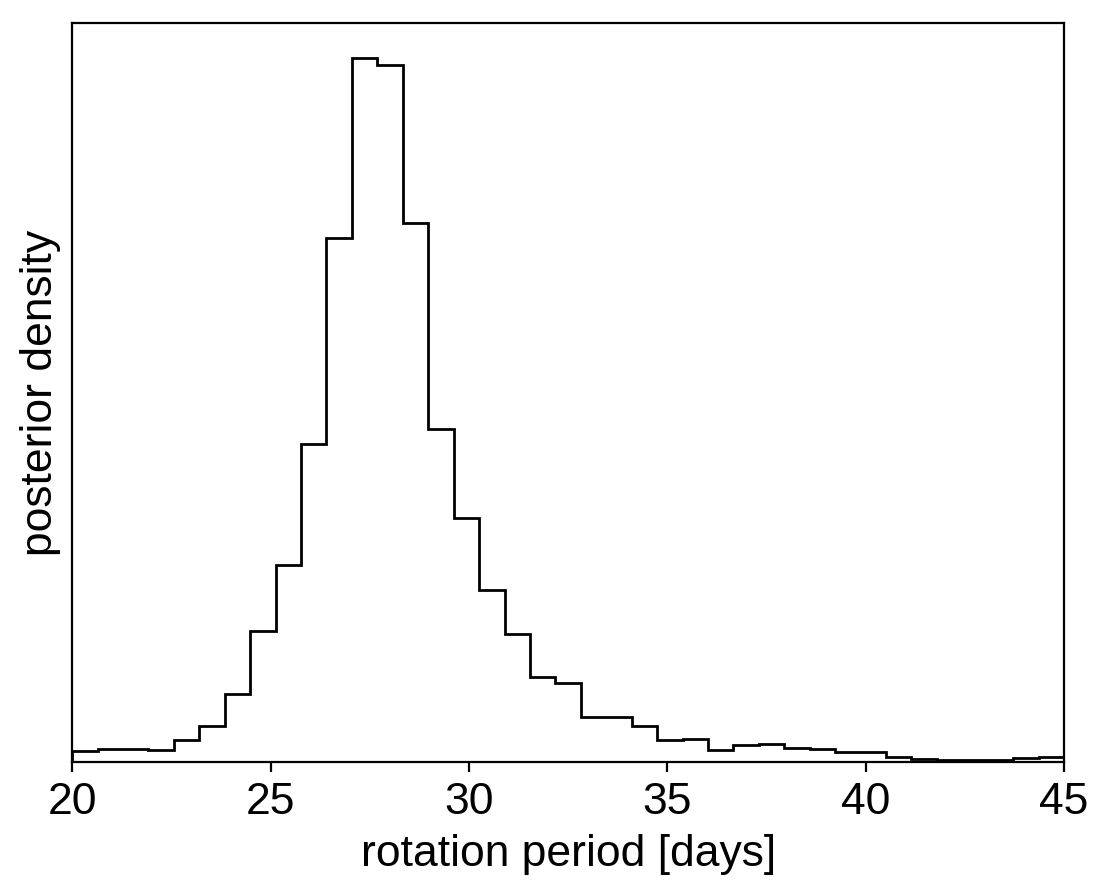

In [9]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [10]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [11]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Eric Agol and
            Rodrigo Luger and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.0},
   month = aug,
    year = 2019,
     doi = {10.5281/zenodo.3359880},
     url = {https://doi.org/10.5281/zenodo.3359880}
}
...
